In [1]:
#https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/multilayer_perceptron.py

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def one_hot(train, test):
    len_train = train.shape[0]
    out = pd.DataFrame(np.concatenate((test, train), axis = 0))
    one_hot = pd.get_dummies(out, columns=[0])
    train_one_hot = one_hot.iloc[:len_train]
    test_one_hot = one_hot.iloc[len_train:]
    return np.array(train_one_hot), np.array(test_one_hot)

In [3]:
def import_data(file_name, test_split, separator, bool_front, bool_one_hot_X):
    data = pd.read_csv(file_name, sep = separator)
    X_Y_train_val, X_Y_test = train_test_split(data, test_size=test_split)
    if bool_front == True:
        X_train_val = X_Y_train_val.iloc[:, :-1]
        Y_train_val = X_Y_train_val.iloc[:,-1]
        X_test = X_Y_test.iloc[:, :-1]
        Y_test = X_Y_test.iloc[:,-1]
    else:
        X_train_val = X_Y_train_val.iloc[:, 0:]
        Y_train_val = X_Y_train_val.iloc[:,0]
        X_test = X_Y_test.iloc[:, 0:]
        Y_test = X_Y_test.iloc[:,0]
    if bool_one_hot_X == True:
        X_train_val, X_test = one_hot(X_train_val, X_test)
    else:
        X_train_val = np.array(X_train_val)
        X_test = np.array(X_test) 
    Y_train_val, Y_test = one_hot(Y_train_val, Y_test)
    return X_train_val, Y_train_val, X_test, Y_test

In [4]:
def next_batch(X, Y, batch_size, batch_number, max_batch_number, randint):
    np.random.seed(randint)
    np.random.shuffle(np.array(X))
    np.random.shuffle(np.array(Y))
    batch_X = X[:batch_size,:]
    batch_Y = Y[:batch_size,:]
    return batch_X, batch_Y

In [5]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [6]:
def nn(data_name, separator, train_test_split, learning_rate, training_epochs, batch_size, n_hidden, display_step, momentum, ac_list, bool_true, bool_one_hot_X):

    X_train_val, Y_train_val, X_test, Y_test = import_data(data_name, train_test_split, separator, bool_true, bool_one_hot_X)

    n_input = X_train_val.shape[1]
    n_classes = Y_train_val.shape[1]

    n_hidden_1 = n_hidden # 1st layer number of neurons
    n_hidden_2 = n_hidden # 2nd layer number of neurons# MNIST data input (img shape: 28*28)

    # tf Graph input
    X = tf.placeholder("float", [None, n_input])
    Y = tf.placeholder("float", [None, n_classes])
    
    # Store layers weight & bias
    weights = {
        'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
        'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
    }
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1])),
        'b2': tf.Variable(tf.random_normal([n_hidden_2])),
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    # Construct model
    logits = multilayer_perceptron(X, weights, biases)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum = momentum)
    train_op = optimizer.minimize(loss_op)
    # Initializing the variables
    init = tf.global_variables_initializer()
    test_ac = []
    train_ac = []

    with tf.Session() as sess:
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(X_train_val.shape[0]/batch_size)
            # Loop over all batches
            for i in range(total_batch):
                batch_x, batch_y = next_batch(X_train_val, Y_train_val, batch_size, i, total_batch, np.random.randint(1000))
                # Run optimization op (backprop) and cost op (to get loss value
                _, c = sess.run([train_op, loss_op], feed_dict={X: batch_x,
                                                            Y: batch_y})
                # Compute average loss
                avg_cost += c / total_batch
            #shuffle epoch
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "cost={:.9f}".format(avg_cost))
            # test model
            pred = tf.nn.softmax( logits )
            correct_prediction = tf.equal( tf.argmax( pred, 1 ), tf.argmax( Y, 1 ) )
            
            # calculating accuracy
            accuracy = tf.reduce_mean( tf.cast( correct_prediction, "float" ) )
            train_ac.append(accuracy.eval( { X: X_train_val, Y: Y_train_val } ))
            test_ac.append(accuracy.eval( { X: X_test, Y: Y_test } ))
        print("Optimization Finished!")
    
        # Test model
        pred = tf.nn.softmax(logits)  # Apply softmax to logits
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print("Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

    n = 1
    plt.plot( train_ac )
    plt.title( "Training Accuracy vs Epoch" )
    plt.ylabel( "Accuracy" )
    plt.xlabel( "Epoch" )
    plt.grid()
    plt.show()
    n = n + 1
        
    plt.plot( test_ac )
    plt.title( "Testing Accuracy vs Epoch" )
    plt.ylabel( "Accuracy" )
    plt.xlabel( "Epoch" )
    plt.grid()
    plt.show()
    n = n + 1

    print("max test", np.max(test_ac))
    print("max train @ max test", train_ac[np.argmax(test_ac)])
    ac_list.append(np.max(test_ac))

Hidden Units:  1
Momentum:  0
Optimization Finished!
Accuracy: 0.0375


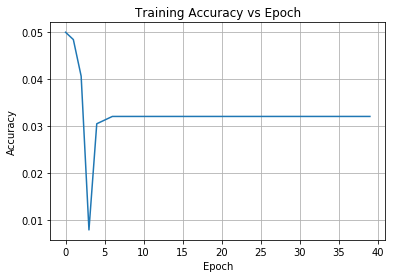

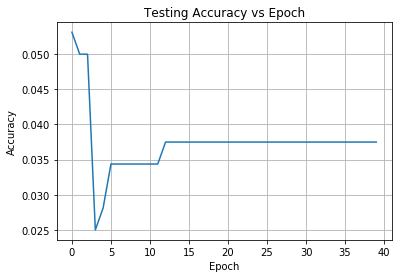

max test 0.053125
max train @ max test 0.050039094
Hidden Units:  1
Momentum:  0.2
Optimization Finished!
Accuracy: 0.0125


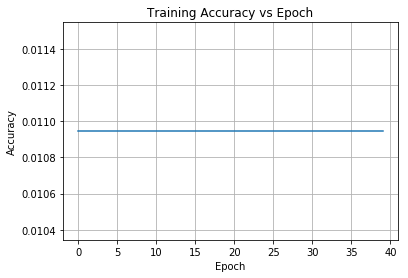

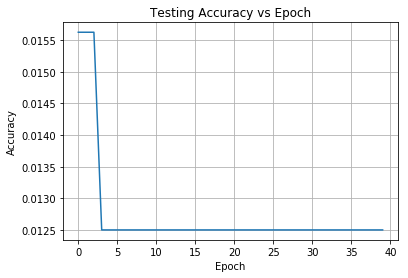

max test 0.015625
max train @ max test 0.010946051
Hidden Units:  1
Momentum:  0.5
Optimization Finished!
Accuracy: 0.34375


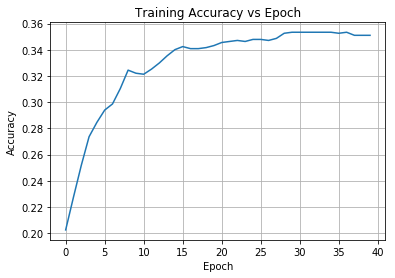

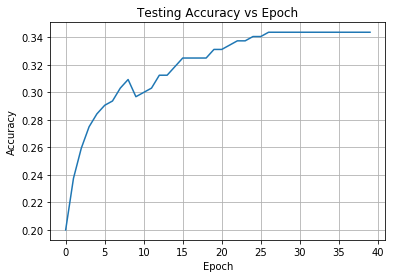

max test 0.34375
max train @ max test 0.3471462
Hidden Units:  1
Momentum:  0.9
Optimization Finished!
Accuracy: 0.35


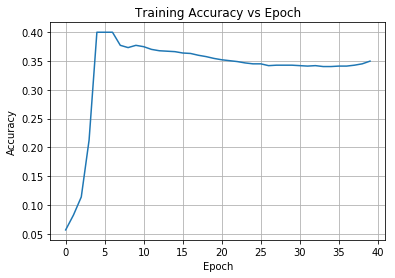

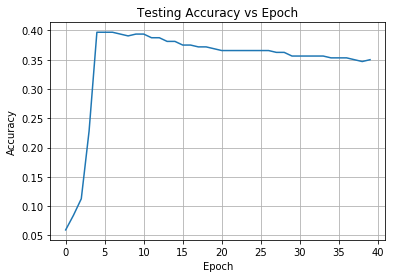

max test 0.396875
max train @ max test 0.3995309
Hidden Units:  2
Momentum:  0
Optimization Finished!
Accuracy: 0.134375


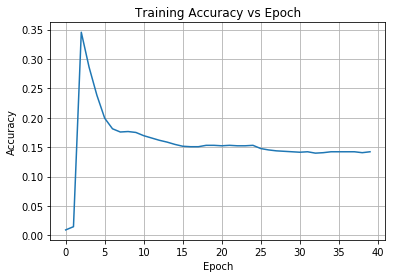

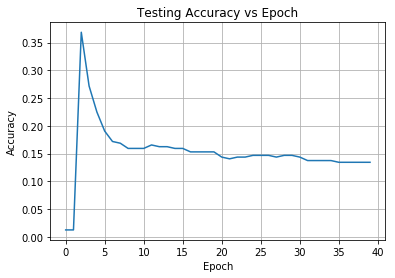

max test 0.36875
max train @ max test 0.3455825
Hidden Units:  2
Momentum:  0.2
Optimization Finished!
Accuracy: 0.125


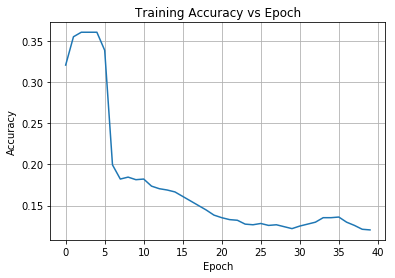

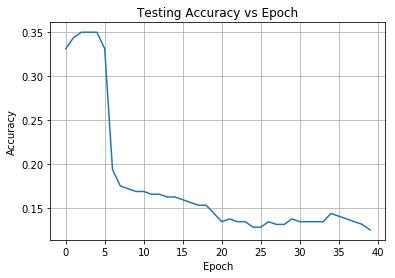

max test 0.35
max train @ max test 0.36043784
Hidden Units:  2
Momentum:  0.5
Optimization Finished!
Accuracy: 0.165625


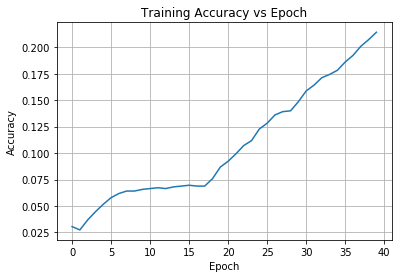

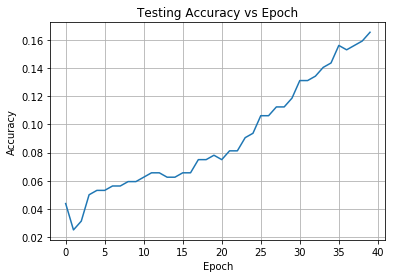

max test 0.165625
max train @ max test 0.21422987
Hidden Units:  2
Momentum:  0.9
Optimization Finished!
Accuracy: 0.3875


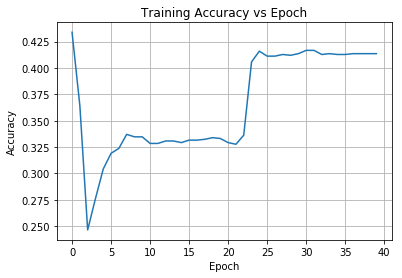

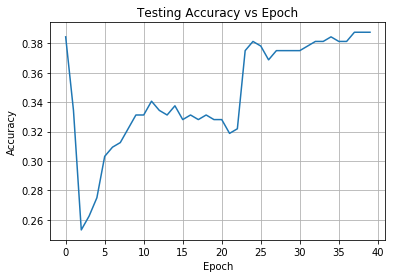

max test 0.3875
max train @ max test 0.41360438
Hidden Units:  4
Momentum:  0
Optimization Finished!
Accuracy: 0.31875


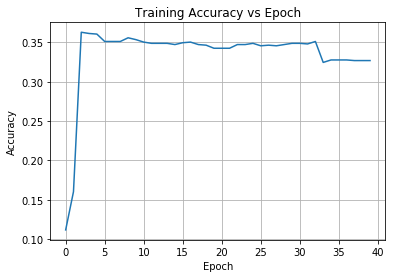

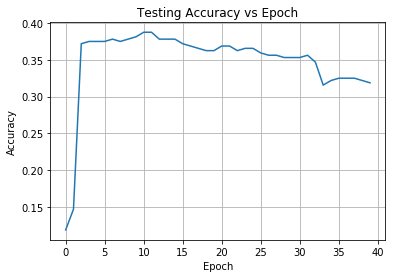

max test 0.3875
max train @ max test 0.35027364
Hidden Units:  4
Momentum:  0.2
Optimization Finished!
Accuracy: 0.403125


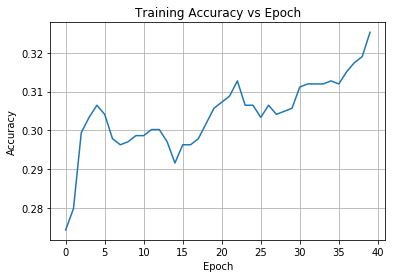

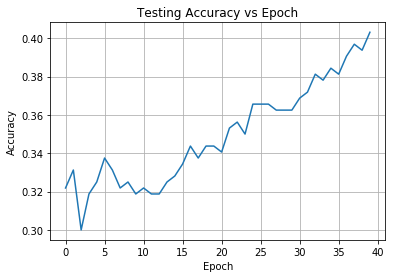

max test 0.403125
max train @ max test 0.3252541
Hidden Units:  4
Momentum:  0.5
Optimization Finished!
Accuracy: 0.2875


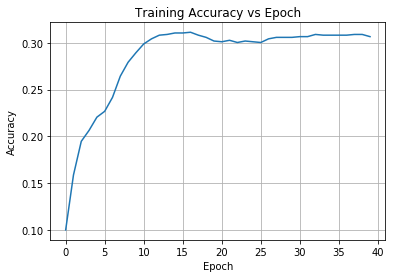

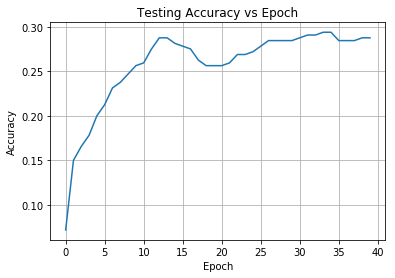

max test 0.29375
max train @ max test 0.30805317
Hidden Units:  4
Momentum:  0.9
Optimization Finished!
Accuracy: 0.35


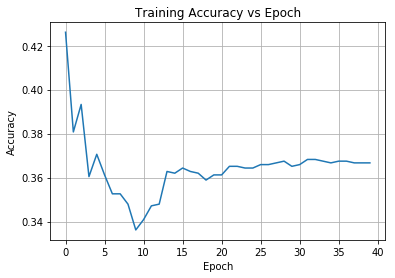

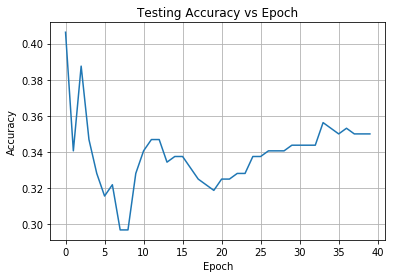

max test 0.40625
max train @ max test 0.42611414
Hidden Units:  8
Momentum:  0
Optimization Finished!
Accuracy: 0.353125


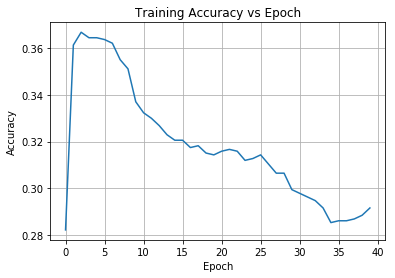

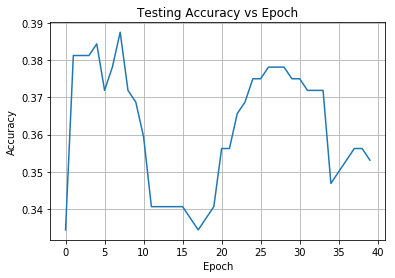

max test 0.3875
max train @ max test 0.35496482
Hidden Units:  8
Momentum:  0.2
Optimization Finished!
Accuracy: 0.3125


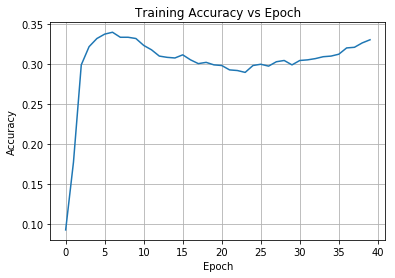

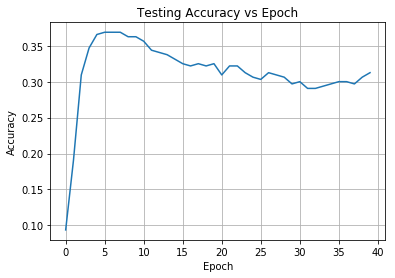

max test 0.36875
max train @ max test 0.336982
Hidden Units:  8
Momentum:  0.5
Optimization Finished!
Accuracy: 0.325


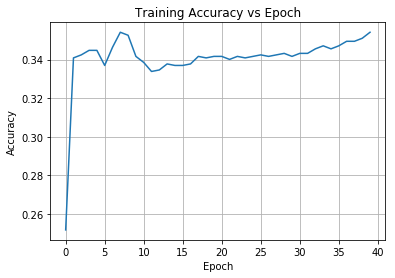

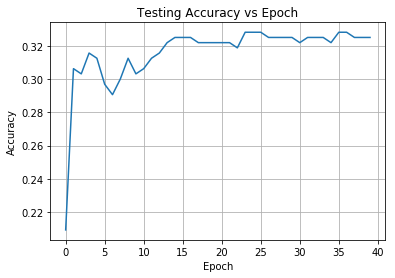

max test 0.328125
max train @ max test 0.34089133
Hidden Units:  8
Momentum:  0.9
Optimization Finished!
Accuracy: 0.3


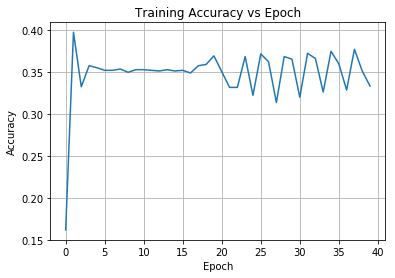

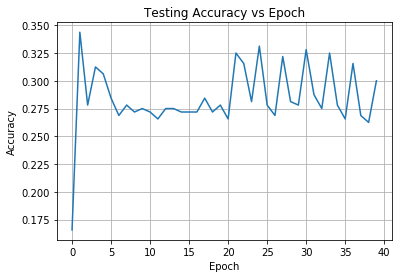

max test 0.34375
max train @ max test 0.3971853
Hidden Units:  32
Momentum:  0
Optimization Finished!
Accuracy: 0.3125


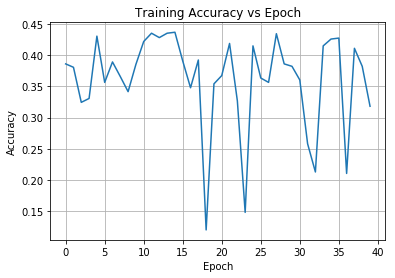

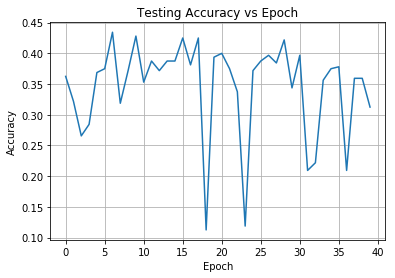

max test 0.434375
max train @ max test 0.3893667
Hidden Units:  32
Momentum:  0.2
Optimization Finished!
Accuracy: 0.375


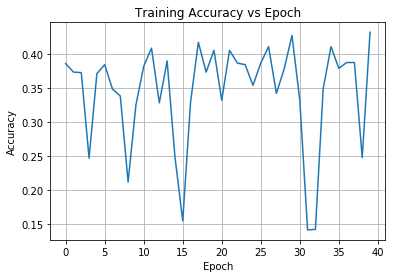

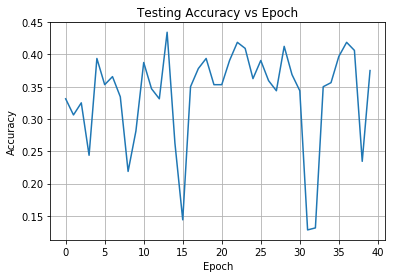

max test 0.434375
max train @ max test 0.39014855
Hidden Units:  32
Momentum:  0.5
Optimization Finished!
Accuracy: 0.38125


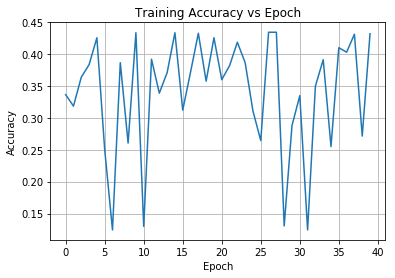

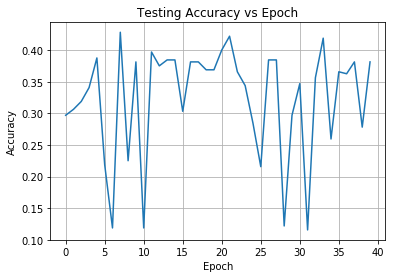

max test 0.428125
max train @ max test 0.38623926
Hidden Units:  32
Momentum:  0.9
Optimization Finished!
Accuracy: 0.31875


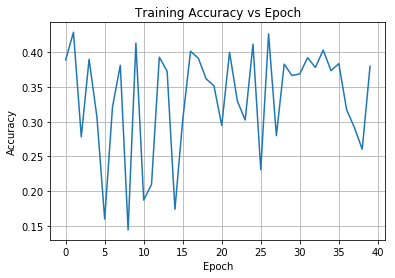

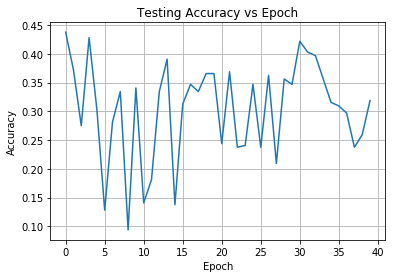

max test 0.4375
max train @ max test 0.3893667
Hidden Units:  128
Momentum:  0
Optimization Finished!
Accuracy: 0.121875


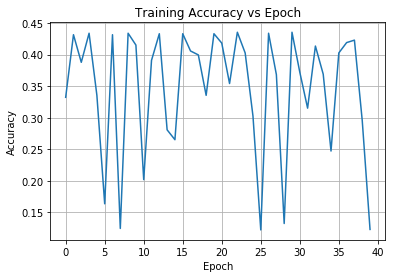

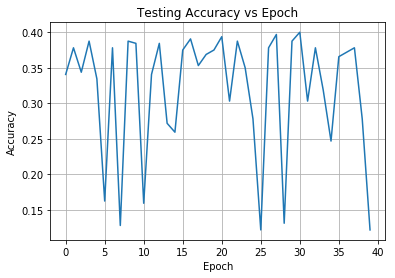

max test 0.4
max train @ max test 0.37216577
Hidden Units:  128
Momentum:  0.2
Optimization Finished!
Accuracy: 0.371875


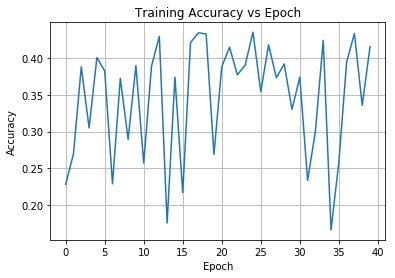

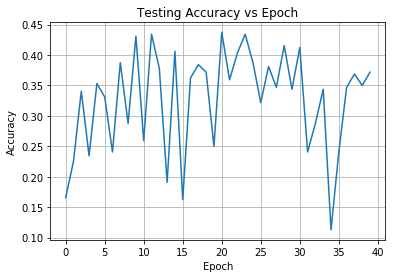

max test 0.4375
max train @ max test 0.38780296
Hidden Units:  128
Momentum:  0.5
Optimization Finished!
Accuracy: 0.240625


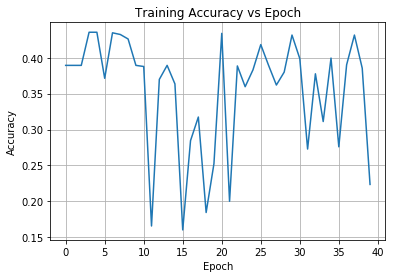

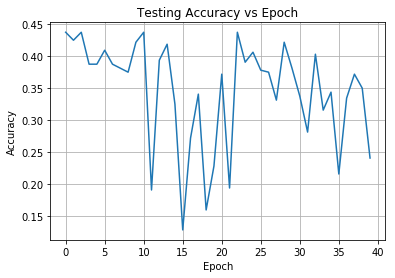

max test 0.4375
max train @ max test 0.3893667
Hidden Units:  128
Momentum:  0.9
Optimization Finished!
Accuracy: 0.35


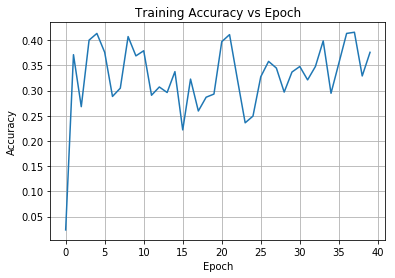

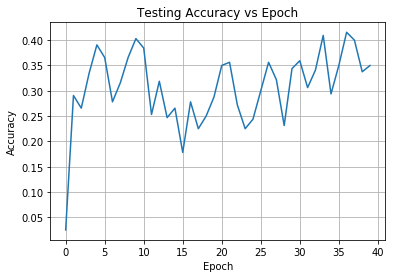

max test 0.415625
max train @ max test 0.41360438


In [9]:
# do the rest with the different hyperparameters, this si for winequality
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j  in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("winequality-red.csv", ";", 0.2, 0.0001, 40, 100, i, 1, j, ac_list, True, False)

In [10]:
out = np.argmax(np.array(ac_list)) +1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  128
Opt Momentum:  0.9
Maximum Test Accuracy:  0.4375


Hidden Units:  1
Momentum:  0
Epoch: 0001 cost=43.888956342
Epoch: 0002 cost=32.065185819
Epoch: 0003 cost=22.044752938
Epoch: 0004 cost=14.228359359
Epoch: 0005 cost=9.122248650
Epoch: 0006 cost=7.144538539
Epoch: 0007 cost=6.594119208
Epoch: 0008 cost=6.461622579
Epoch: 0009 cost=6.385967459
Epoch: 0010 cost=6.316467830
Epoch: 0011 cost=6.248375075
Epoch: 0012 cost=6.181147984
Epoch: 0013 cost=6.114714009
Epoch: 0014 cost=6.049058574
Epoch: 0015 cost=5.984173911
Epoch: 0016 cost=5.920053823
Epoch: 0017 cost=5.856691701
Epoch: 0018 cost=5.794082437
Epoch: 0019 cost=5.732220309
Epoch: 0020 cost=5.671098573
Epoch: 0021 cost=5.610713823
Epoch: 0022 cost=5.551061085
Epoch: 0023 cost=5.492135593
Epoch: 0024 cost=5.433934212
Epoch: 0025 cost=5.376451697
Epoch: 0026 cost=5.319685119
Epoch: 0027 cost=5.263630390
Epoch: 0028 cost=5.208284923
Epoch: 0029 cost=5.153645175
Epoch: 0030 cost=5.099708217
Epoch: 0031 cost=5.046472004
Epoch: 0032 cost=4.993934155
Epoch: 0033 cost=4.942091942
Epoch: 00

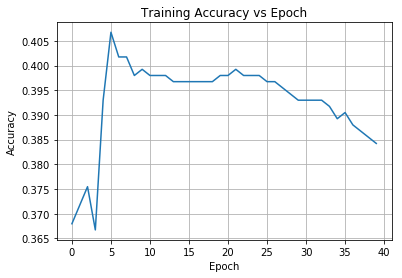

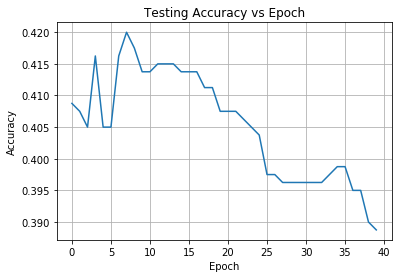

max test 0.42
max train @ max test 0.4017522
Hidden Units:  1
Momentum:  0.2
Epoch: 0001 cost=6.663995811
Epoch: 0002 cost=6.511385781
Epoch: 0003 cost=6.362048830
Epoch: 0004 cost=6.216700077
Epoch: 0005 cost=6.075071675
Epoch: 0006 cost=5.936926433
Epoch: 0007 cost=5.802050522
Epoch: 0008 cost=5.670252323
Epoch: 0009 cost=5.541357585
Epoch: 0010 cost=5.415210043
Epoch: 0011 cost=5.291668143
Epoch: 0012 cost=5.170603548
Epoch: 0013 cost=5.051898616
Epoch: 0014 cost=4.935447284
Epoch: 0015 cost=4.821154458
Epoch: 0016 cost=4.708930629
Epoch: 0017 cost=4.598696300
Epoch: 0018 cost=4.490381513
Epoch: 0019 cost=4.383922441
Epoch: 0020 cost=4.279262066
Epoch: 0021 cost=4.176350253
Epoch: 0022 cost=4.075145381
Epoch: 0023 cost=3.975611891
Epoch: 0024 cost=3.877720935
Epoch: 0025 cost=3.781452383
Epoch: 0026 cost=3.686794451
Epoch: 0027 cost=3.593742030
Epoch: 0028 cost=3.502299717
Epoch: 0029 cost=3.412481717
Epoch: 0030 cost=3.324311767
Epoch: 0031 cost=3.237825768
Epoch: 0032 cost=3.15307

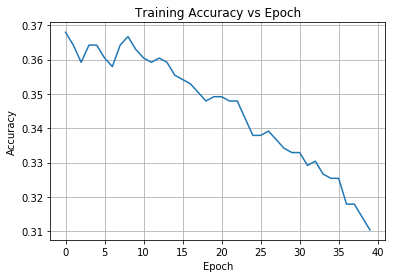

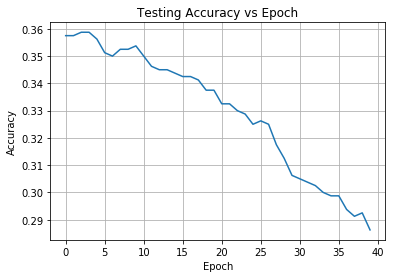

max test 0.35875
max train @ max test 0.359199
Hidden Units:  1
Momentum:  0.5
Epoch: 0001 cost=5.019070625
Epoch: 0002 cost=3.683369807
Epoch: 0003 cost=2.939281668
Epoch: 0004 cost=2.643560410
Epoch: 0005 cost=2.549147265
Epoch: 0006 cost=2.526415144
Epoch: 0007 cost=2.520576409
Epoch: 0008 cost=2.517373460
Epoch: 0009 cost=2.514497587
Epoch: 0010 cost=2.511661223
Epoch: 0011 cost=2.508832625
Epoch: 0012 cost=2.506008216
Epoch: 0013 cost=2.503187963
Epoch: 0014 cost=2.500371626
Epoch: 0015 cost=2.497559479
Epoch: 0016 cost=2.494751249
Epoch: 0017 cost=2.491947038
Epoch: 0018 cost=2.489147084
Epoch: 0019 cost=2.486351047
Epoch: 0020 cost=2.483559370
Epoch: 0021 cost=2.480771712
Epoch: 0022 cost=2.477988345
Epoch: 0023 cost=2.475209168
Epoch: 0024 cost=2.472434214
Epoch: 0025 cost=2.469663688
Epoch: 0026 cost=2.466897283
Epoch: 0027 cost=2.464135272
Epoch: 0028 cost=2.461377416
Epoch: 0029 cost=2.458624056
Epoch: 0030 cost=2.455875022
Epoch: 0031 cost=2.453130211
Epoch: 0032 cost=2.450

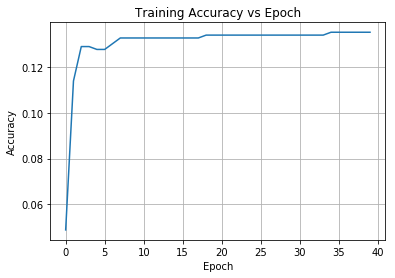

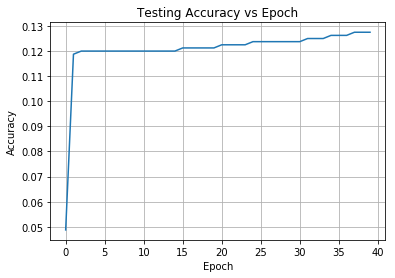

max test 0.1275
max train @ max test 0.13516895
Hidden Units:  1
Momentum:  0.9
Epoch: 0001 cost=52.645427704
Epoch: 0002 cost=19.867904186
Epoch: 0003 cost=6.139202118
Epoch: 0004 cost=8.727737767
Epoch: 0005 cost=3.213977967
Epoch: 0006 cost=3.549761942
Epoch: 0007 cost=2.198939392
Epoch: 0008 cost=2.193172778
Epoch: 0009 cost=2.022849389
Epoch: 0010 cost=1.903863839
Epoch: 0011 cost=1.888732416
Epoch: 0012 cost=1.878527948
Epoch: 0013 cost=1.863764524
Epoch: 0014 cost=1.857320258
Epoch: 0015 cost=1.854717187
Epoch: 0016 cost=1.851926361
Epoch: 0017 cost=1.849138277
Epoch: 0018 cost=1.846800464
Epoch: 0019 cost=1.844639421
Epoch: 0020 cost=1.842460002
Epoch: 0021 cost=1.840290308
Epoch: 0022 cost=1.838149548
Epoch: 0023 cost=1.836017711
Epoch: 0024 cost=1.833886845
Epoch: 0025 cost=1.831759180
Epoch: 0026 cost=1.829635177
Epoch: 0027 cost=1.827513712
Epoch: 0028 cost=1.825394375
Epoch: 0029 cost=1.823277473
Epoch: 0030 cost=1.821162718
Epoch: 0031 cost=1.819050448
Epoch: 0032 cost=1.

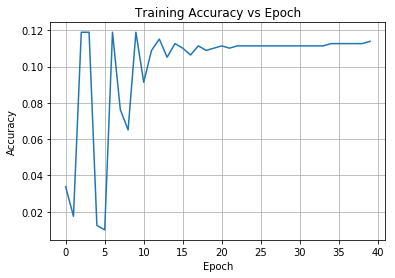

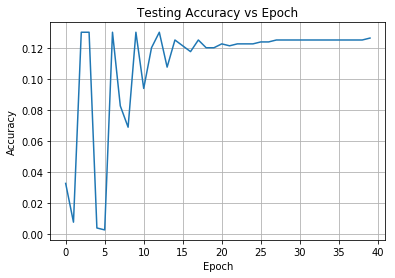

max test 0.13
max train @ max test 0.11889862
Hidden Units:  2
Momentum:  0
Epoch: 0001 cost=58.673157283
Epoch: 0002 cost=52.623573848
Epoch: 0003 cost=49.088914599
Epoch: 0004 cost=46.474927085
Epoch: 0005 cost=44.314386640
Epoch: 0006 cost=42.537952423
Epoch: 0007 cost=41.121942793
Epoch: 0008 cost=39.960837773
Epoch: 0009 cost=38.947435652
Epoch: 0010 cost=38.036339896
Epoch: 0011 cost=37.191902706
Epoch: 0012 cost=36.385887691
Epoch: 0013 cost=35.606837136
Epoch: 0014 cost=34.850533077
Epoch: 0015 cost=34.114904676
Epoch: 0016 cost=33.398624420
Epoch: 0017 cost=32.700703212
Epoch: 0018 cost=32.020321982
Epoch: 0019 cost=31.356780188
Epoch: 0020 cost=30.709459850
Epoch: 0021 cost=30.077797753
Epoch: 0022 cost=29.461271014
Epoch: 0023 cost=28.859386172
Epoch: 0024 cost=28.271687644
Epoch: 0025 cost=27.697741100
Epoch: 0026 cost=27.137133190
Epoch: 0027 cost=26.589461735
Epoch: 0028 cost=26.054340635
Epoch: 0029 cost=25.531409400
Epoch: 0030 cost=25.020308358
Epoch: 0031 cost=24.5207

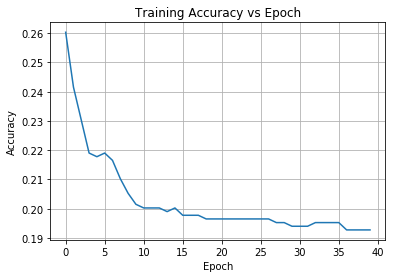

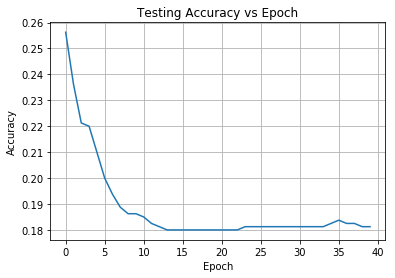

max test 0.25625
max train @ max test 0.2603254
Hidden Units:  2
Momentum:  0.2
Epoch: 0001 cost=21.978019987
Epoch: 0002 cost=16.436382021
Epoch: 0003 cost=15.225490979
Epoch: 0004 cost=14.668589728
Epoch: 0005 cost=14.291662080
Epoch: 0006 cost=13.973785945
Epoch: 0007 cost=13.680373873
Epoch: 0008 cost=13.398923056
Epoch: 0009 cost=13.125547682
Epoch: 0010 cost=12.858772550
Epoch: 0011 cost=12.598138264
Epoch: 0012 cost=12.345226833
Epoch: 0013 cost=12.103631020
Epoch: 0014 cost=11.873141016
Epoch: 0015 cost=11.652400970
Epoch: 0016 cost=11.440863201
Epoch: 0017 cost=11.238048417
Epoch: 0018 cost=11.043373244
Epoch: 0019 cost=10.856120382
Epoch: 0020 cost=10.675505774
Epoch: 0021 cost=10.500760078
Epoch: 0022 cost=10.331211771
Epoch: 0023 cost=10.166375978
Epoch: 0024 cost=10.005990982
Epoch: 0025 cost=9.849988392
Epoch: 0026 cost=9.698345729
Epoch: 0027 cost=9.550932339
Epoch: 0028 cost=9.407522474
Epoch: 0029 cost=9.267890113
Epoch: 0030 cost=9.131835529
Epoch: 0031 cost=8.9991921

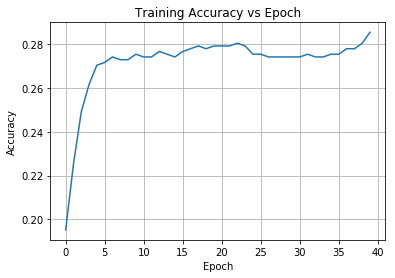

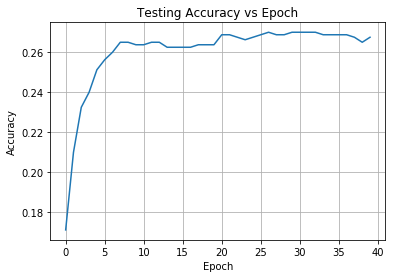

max test 0.27
max train @ max test 0.2740926
Hidden Units:  2
Momentum:  0.5
Epoch: 0001 cost=176.797690255
Epoch: 0002 cost=81.724348886
Epoch: 0003 cost=33.159517833
Epoch: 0004 cost=18.788499560
Epoch: 0005 cost=14.045258795
Epoch: 0006 cost=12.667303222
Epoch: 0007 cost=11.891934122
Epoch: 0008 cost=11.273396628
Epoch: 0009 cost=10.699208396
Epoch: 0010 cost=10.154744012
Epoch: 0011 cost=9.636073930
Epoch: 0012 cost=9.140668324
Epoch: 0013 cost=8.666295052
Epoch: 0014 cost=8.210880961
Epoch: 0015 cost=7.772838116
Epoch: 0016 cost=7.351324354
Epoch: 0017 cost=6.947410992
Epoch: 0018 cost=6.567388330
Epoch: 0019 cost=6.221258913
Epoch: 0020 cost=5.909353461
Epoch: 0021 cost=5.625850201
Epoch: 0022 cost=5.365604537
Epoch: 0023 cost=5.124038151
Epoch: 0024 cost=4.900536742
Epoch: 0025 cost=4.697562695
Epoch: 0026 cost=4.516753878
Epoch: 0027 cost=4.357992717
Epoch: 0028 cost=4.222176211
Epoch: 0029 cost=4.109630040
Epoch: 0030 cost=4.018513714
Epoch: 0031 cost=3.949149881
Epoch: 0032 c

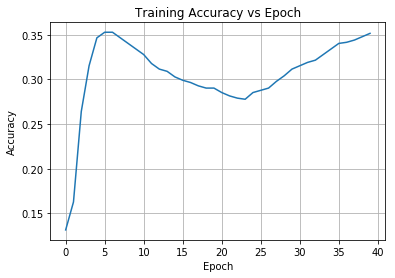

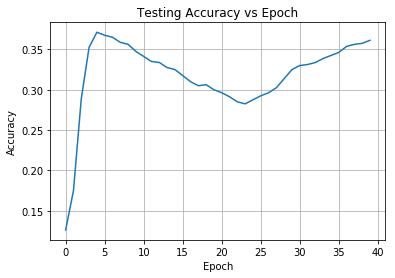

max test 0.37125
max train @ max test 0.34668335
Hidden Units:  2
Momentum:  0.9
Epoch: 0001 cost=26.792252132
Epoch: 0002 cost=18.597237723
Epoch: 0003 cost=11.174883979
Epoch: 0004 cost=6.817582744
Epoch: 0005 cost=4.137295995
Epoch: 0006 cost=3.354348489
Epoch: 0007 cost=2.994480474
Epoch: 0008 cost=2.664666857
Epoch: 0009 cost=2.409987075
Epoch: 0010 cost=2.233646529
Epoch: 0011 cost=2.091772045
Epoch: 0012 cost=1.968992472
Epoch: 0013 cost=1.860384209
Epoch: 0014 cost=1.764976246
Epoch: 0015 cost=1.680812648
Epoch: 0016 cost=1.607309580
Epoch: 0017 cost=1.545387251
Epoch: 0018 cost=1.497314385
Epoch: 0019 cost=1.464655723
Epoch: 0020 cost=1.444812553
Epoch: 0021 cost=1.431022763
Epoch: 0022 cost=1.418243442
Epoch: 0023 cost=1.405563934
Epoch: 0024 cost=1.393709029
Epoch: 0025 cost=1.383005295
Epoch: 0026 cost=1.373298866
Epoch: 0027 cost=1.364395244
Epoch: 0028 cost=1.356207507
Epoch: 0029 cost=1.348696249
Epoch: 0030 cost=1.341817873
Epoch: 0031 cost=1.335521953
Epoch: 0032 cost=

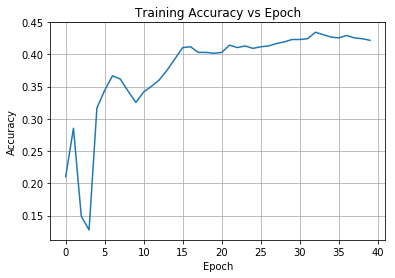

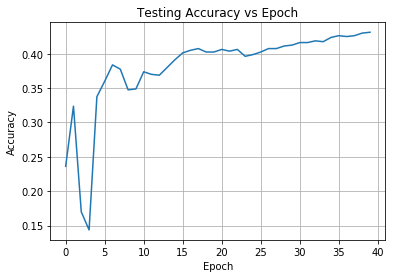

max test 0.43125
max train @ max test 0.42177722
Hidden Units:  4
Momentum:  0
Epoch: 0001 cost=65.730768476
Epoch: 0002 cost=51.309749058
Epoch: 0003 cost=44.084299905
Epoch: 0004 cost=38.742868696
Epoch: 0005 cost=34.252766200
Epoch: 0006 cost=30.254086358
Epoch: 0007 cost=26.630883898
Epoch: 0008 cost=23.500272751
Epoch: 0009 cost=21.047632217
Epoch: 0010 cost=19.351024900
Epoch: 0011 cost=18.176966803
Epoch: 0012 cost=17.291271755
Epoch: 0013 cost=16.628128052
Epoch: 0014 cost=16.115421704
Epoch: 0015 cost=15.697603498
Epoch: 0016 cost=15.337706838
Epoch: 0017 cost=15.018578121
Epoch: 0018 cost=14.729937008
Epoch: 0019 cost=14.463922501
Epoch: 0020 cost=14.215019635
Epoch: 0021 cost=13.979798998
Epoch: 0022 cost=13.756058829
Epoch: 0023 cost=13.541752407
Epoch: 0024 cost=13.334808213
Epoch: 0025 cost=13.133489745
Epoch: 0026 cost=12.936571121
Epoch: 0027 cost=12.743284634
Epoch: 0028 cost=12.553201948
Epoch: 0029 cost=12.366109576
Epoch: 0030 cost=12.181915828
Epoch: 0031 cost=12.0

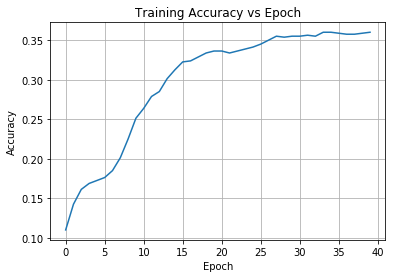

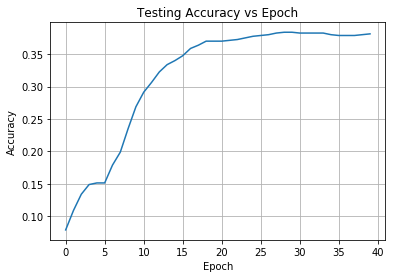

max test 0.38375
max train @ max test 0.35419273
Hidden Units:  4
Momentum:  0.2
Epoch: 0001 cost=960.171517508
Epoch: 0002 cost=415.361707415
Epoch: 0003 cost=200.579814366
Epoch: 0004 cost=102.684514727
Epoch: 0005 cost=72.438838414
Epoch: 0006 cost=59.793568747
Epoch: 0007 cost=49.614677974
Epoch: 0008 cost=40.192647661
Epoch: 0009 cost=31.876628331
Epoch: 0010 cost=26.764242990
Epoch: 0011 cost=24.999189377
Epoch: 0012 cost=23.947602408
Epoch: 0013 cost=23.082981927
Epoch: 0014 cost=22.359353202
Epoch: 0015 cost=21.738359451
Epoch: 0016 cost=21.164440155
Epoch: 0017 cost=20.628321784
Epoch: 0018 cost=20.128271103
Epoch: 0019 cost=19.664247513
Epoch: 0020 cost=19.228457315
Epoch: 0021 cost=18.811947959
Epoch: 0022 cost=18.414042064
Epoch: 0023 cost=18.034331730
Epoch: 0024 cost=17.668765477
Epoch: 0025 cost=17.313885553
Epoch: 0026 cost=16.968057632
Epoch: 0027 cost=16.630577087
Epoch: 0028 cost=16.301089968
Epoch: 0029 cost=15.979348728
Epoch: 0030 cost=15.665107455
Epoch: 0031 cos

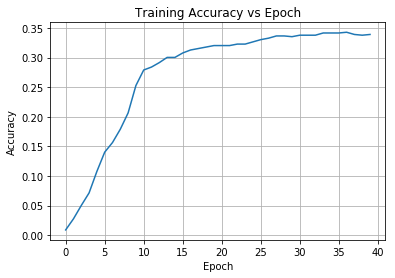

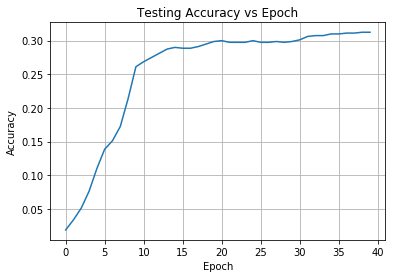

max test 0.3125
max train @ max test 0.3379224
Hidden Units:  4
Momentum:  0.5
Epoch: 0001 cost=174.345224653
Epoch: 0002 cost=75.472004482
Epoch: 0003 cost=62.898268563
Epoch: 0004 cost=58.582117353
Epoch: 0005 cost=54.623456138
Epoch: 0006 cost=50.984834399
Epoch: 0007 cost=47.628325871
Epoch: 0008 cost=44.512648991
Epoch: 0009 cost=41.606054579
Epoch: 0010 cost=38.888578687
Epoch: 0011 cost=36.342659542
Epoch: 0012 cost=33.945646558
Epoch: 0013 cost=31.678219931
Epoch: 0014 cost=29.525348391
Epoch: 0015 cost=27.474579402
Epoch: 0016 cost=25.514964512
Epoch: 0017 cost=23.636762619
Epoch: 0018 cost=21.831321444
Epoch: 0019 cost=20.090898241
Epoch: 0020 cost=18.408452988
Epoch: 0021 cost=16.777466093
Epoch: 0022 cost=15.191822869
Epoch: 0023 cost=13.645697866
Epoch: 0024 cost=12.136075837
Epoch: 0025 cost=11.136204720
Epoch: 0026 cost=10.780033248
Epoch: 0027 cost=10.468342509
Epoch: 0028 cost=10.168399266
Epoch: 0029 cost=9.878385816
Epoch: 0030 cost=9.597558158
Epoch: 0031 cost=9.325

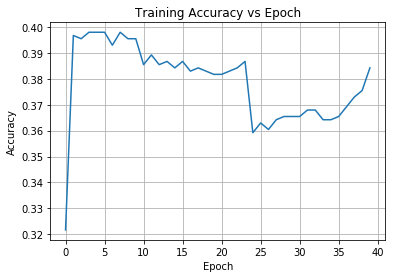

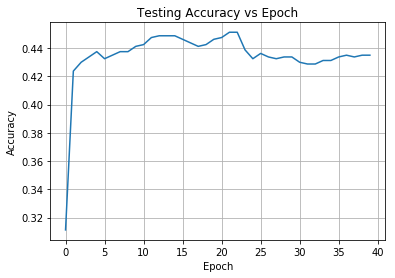

max test 0.45125
max train @ max test 0.38297874
Hidden Units:  4
Momentum:  0.9
Epoch: 0001 cost=192.090856280
Epoch: 0002 cost=60.464955466
Epoch: 0003 cost=55.787646157
Epoch: 0004 cost=34.049967630
Epoch: 0005 cost=24.878826686
Epoch: 0006 cost=19.536756788
Epoch: 0007 cost=16.248295920
Epoch: 0008 cost=13.443055834
Epoch: 0009 cost=11.618327550
Epoch: 0010 cost=10.223194531
Epoch: 0011 cost=9.023407664
Epoch: 0012 cost=8.047356333
Epoch: 0013 cost=7.265514306
Epoch: 0014 cost=6.649627413
Epoch: 0015 cost=6.142507689
Epoch: 0016 cost=5.737305505
Epoch: 0017 cost=5.424784115
Epoch: 0018 cost=5.195008210
Epoch: 0019 cost=5.015166351
Epoch: 0020 cost=4.866391114
Epoch: 0021 cost=4.743663379
Epoch: 0022 cost=4.635877541
Epoch: 0023 cost=4.537018640
Epoch: 0024 cost=4.444171633
Epoch: 0025 cost=4.355865206
Epoch: 0026 cost=4.271215916
Epoch: 0027 cost=4.189715522
Epoch: 0028 cost=4.111060756
Epoch: 0029 cost=4.035002981
Epoch: 0030 cost=3.961378677
Epoch: 0031 cost=3.890054362
Epoch: 00

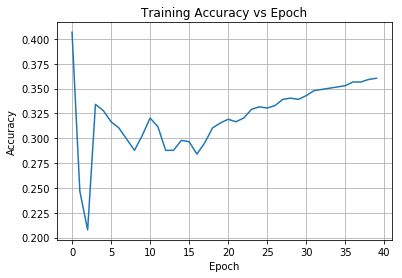

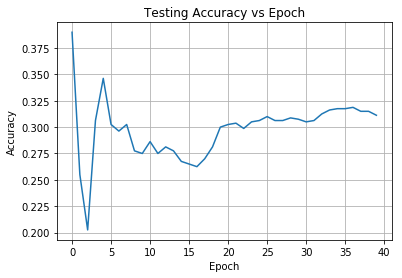

max test 0.39
max train @ max test 0.40675846
Hidden Units:  8
Momentum:  0
Epoch: 0001 cost=422.709965297
Epoch: 0002 cost=294.914712088
Epoch: 0003 cost=197.276687622
Epoch: 0004 cost=137.979715620
Epoch: 0005 cost=110.227250235
Epoch: 0006 cost=95.838800703
Epoch: 0007 cost=89.429961068
Epoch: 0008 cost=85.829794747
Epoch: 0009 cost=82.770469666
Epoch: 0010 cost=79.901091439
Epoch: 0011 cost=77.123556955
Epoch: 0012 cost=74.418506077
Epoch: 0013 cost=71.778233119
Epoch: 0014 cost=69.200680324
Epoch: 0015 cost=66.684488569
Epoch: 0016 cost=64.223007747
Epoch: 0017 cost=61.813179016
Epoch: 0018 cost=59.453503200
Epoch: 0019 cost=57.142425537
Epoch: 0020 cost=54.878297533
Epoch: 0021 cost=52.659505572
Epoch: 0022 cost=50.483345577
Epoch: 0023 cost=48.346412659
Epoch: 0024 cost=46.246015821
Epoch: 0025 cost=44.180155073
Epoch: 0026 cost=42.147568294
Epoch: 0027 cost=40.148199354
Epoch: 0028 cost=38.182825906
Epoch: 0029 cost=36.251378196
Epoch: 0030 cost=34.352348873
Epoch: 0031 cost=32

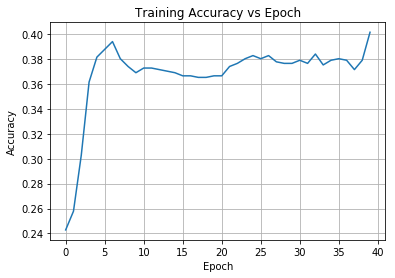

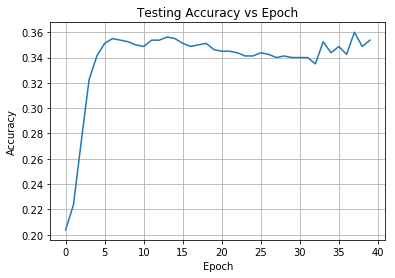

max test 0.36
max train @ max test 0.37171465
Hidden Units:  8
Momentum:  0.2
Epoch: 0001 cost=230.826865060
Epoch: 0002 cost=179.570574079
Epoch: 0003 cost=157.118397304
Epoch: 0004 cost=137.872617449
Epoch: 0005 cost=120.744614737
Epoch: 0006 cost=105.331560407
Epoch: 0007 cost=90.644511632
Epoch: 0008 cost=78.819400242
Epoch: 0009 cost=73.723074777
Epoch: 0010 cost=70.639210292
Epoch: 0011 cost=67.741019113
Epoch: 0012 cost=65.022097996
Epoch: 0013 cost=62.499166216
Epoch: 0014 cost=60.102575030
Epoch: 0015 cost=57.769574847
Epoch: 0016 cost=55.497153691
Epoch: 0017 cost=53.357905252
Epoch: 0018 cost=51.398752485
Epoch: 0019 cost=49.600970132
Epoch: 0020 cost=47.938080379
Epoch: 0021 cost=46.353788103
Epoch: 0022 cost=44.832818168
Epoch: 0023 cost=43.380346571
Epoch: 0024 cost=42.023737226
Epoch: 0025 cost=40.763445173
Epoch: 0026 cost=39.559356689
Epoch: 0027 cost=38.421204703
Epoch: 0028 cost=37.336656843
Epoch: 0029 cost=36.464415414
Epoch: 0030 cost=35.732598441
Epoch: 0031 cost

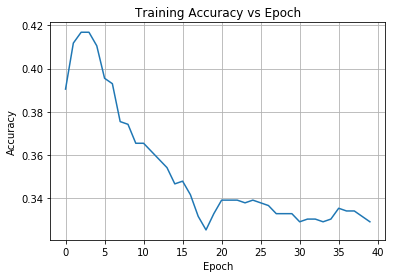

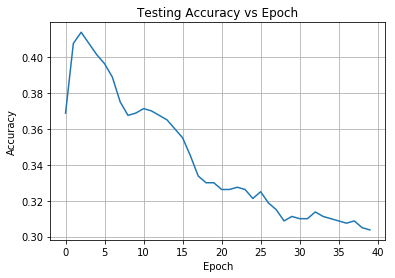

max test 0.41375
max train @ max test 0.41677096
Hidden Units:  8
Momentum:  0.5
Epoch: 0001 cost=353.454897199
Epoch: 0002 cost=213.968664987
Epoch: 0003 cost=178.818123954
Epoch: 0004 cost=148.256556920
Epoch: 0005 cost=120.619706290
Epoch: 0006 cost=97.122620719
Epoch: 0007 cost=82.685412816
Epoch: 0008 cost=72.156629290
Epoch: 0009 cost=62.420707703
Epoch: 0010 cost=53.380416870
Epoch: 0011 cost=45.331821442
Epoch: 0012 cost=38.841274806
Epoch: 0013 cost=33.354816437
Epoch: 0014 cost=28.089645113
Epoch: 0015 cost=23.503084728
Epoch: 0016 cost=20.962925502
Epoch: 0017 cost=18.969607489
Epoch: 0018 cost=17.175345830
Epoch: 0019 cost=15.498273032
Epoch: 0020 cost=13.956324714
Epoch: 0021 cost=12.667349952
Epoch: 0022 cost=11.771334648
Epoch: 0023 cost=11.197031294
Epoch: 0024 cost=10.783893721
Epoch: 0025 cost=10.452153342
Epoch: 0026 cost=10.156818935
Epoch: 0027 cost=9.908484186
Epoch: 0028 cost=9.706342425
Epoch: 0029 cost=9.545552117
Epoch: 0030 cost=9.373690605
Epoch: 0031 cost=9

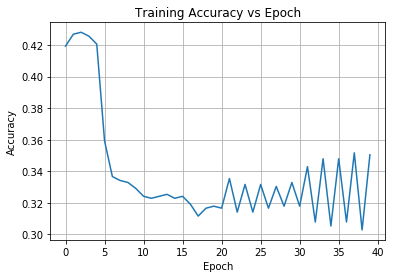

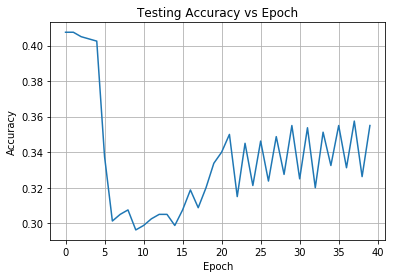

max test 0.4075
max train @ max test 0.4192741
Hidden Units:  8
Momentum:  0.9
Epoch: 0001 cost=141.401156834
Epoch: 0002 cost=100.876653399
Epoch: 0003 cost=75.360970633
Epoch: 0004 cost=59.502737318
Epoch: 0005 cost=44.843929291
Epoch: 0006 cost=34.596532549
Epoch: 0007 cost=26.456972940
Epoch: 0008 cost=19.637979507
Epoch: 0009 cost=17.381923403
Epoch: 0010 cost=16.097572463
Epoch: 0011 cost=14.380199569
Epoch: 0012 cost=13.536499977
Epoch: 0013 cost=12.729419300
Epoch: 0014 cost=12.072384426
Epoch: 0015 cost=11.491909981
Epoch: 0016 cost=10.952913557
Epoch: 0017 cost=10.436058862
Epoch: 0018 cost=9.943386350
Epoch: 0019 cost=9.464343207
Epoch: 0020 cost=9.010996274
Epoch: 0021 cost=8.583650861
Epoch: 0022 cost=8.179305758
Epoch: 0023 cost=7.791701249
Epoch: 0024 cost=7.418090412
Epoch: 0025 cost=7.059106009
Epoch: 0026 cost=6.714734146
Epoch: 0027 cost=6.388734136
Epoch: 0028 cost=6.089516367
Epoch: 0029 cost=5.819109985
Epoch: 0030 cost=5.557720934
Epoch: 0031 cost=5.305792672
Epo

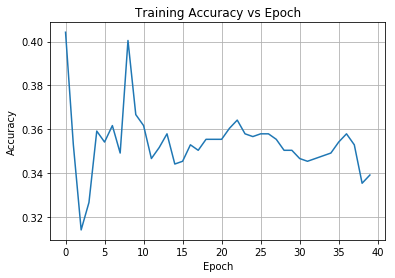

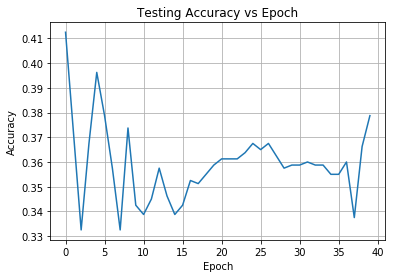

max test 0.4125
max train @ max test 0.40425533
Hidden Units:  32
Momentum:  0
Epoch: 0001 cost=1186.085196359
Epoch: 0002 cost=622.837768555
Epoch: 0003 cost=512.375667027
Epoch: 0004 cost=418.652491978
Epoch: 0005 cost=333.832057408
Epoch: 0006 cost=321.490936279
Epoch: 0007 cost=290.881264823
Epoch: 0008 cost=287.434463501
Epoch: 0009 cost=261.986264910
Epoch: 0010 cost=255.326450893
Epoch: 0011 cost=255.228543963
Epoch: 0012 cost=244.481212071
Epoch: 0013 cost=242.065732683
Epoch: 0014 cost=265.009996687
Epoch: 0015 cost=249.533543178
Epoch: 0016 cost=259.438943045
Epoch: 0017 cost=224.376111712
Epoch: 0018 cost=243.021935599
Epoch: 0019 cost=212.693959917
Epoch: 0020 cost=215.568793161
Epoch: 0021 cost=219.167048863
Epoch: 0022 cost=222.312460763
Epoch: 0023 cost=204.796190534
Epoch: 0024 cost=212.778362819
Epoch: 0025 cost=210.515993391
Epoch: 0026 cost=210.333336966
Epoch: 0027 cost=187.394790649
Epoch: 0028 cost=181.885674613
Epoch: 0029 cost=203.171714783
Epoch: 0030 cost=198.

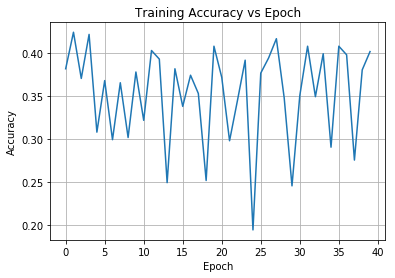

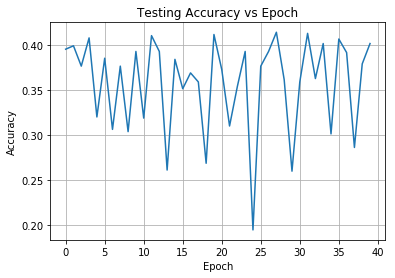

max test 0.41375
max train @ max test 0.41677096
Hidden Units:  32
Momentum:  0.2
Epoch: 0001 cost=1007.048989432
Epoch: 0002 cost=414.471505301
Epoch: 0003 cost=366.554399763
Epoch: 0004 cost=339.330487932
Epoch: 0005 cost=335.619868687
Epoch: 0006 cost=340.642560686
Epoch: 0007 cost=330.299229213
Epoch: 0008 cost=316.003444127
Epoch: 0009 cost=309.386535645
Epoch: 0010 cost=300.840244838
Epoch: 0011 cost=266.849417550
Epoch: 0012 cost=277.734126500
Epoch: 0013 cost=269.210298811
Epoch: 0014 cost=238.245622907
Epoch: 0015 cost=287.707645961
Epoch: 0016 cost=247.609438215
Epoch: 0017 cost=282.109470912
Epoch: 0018 cost=269.950511387
Epoch: 0019 cost=282.591498239
Epoch: 0020 cost=244.611097063
Epoch: 0021 cost=218.376488822
Epoch: 0022 cost=265.441007342
Epoch: 0023 cost=217.762895857
Epoch: 0024 cost=189.898120335
Epoch: 0025 cost=196.648960658
Epoch: 0026 cost=177.780964443
Epoch: 0027 cost=195.370128087
Epoch: 0028 cost=186.877867562
Epoch: 0029 cost=196.410558428
Epoch: 0030 cost=2

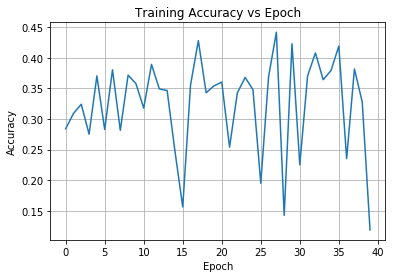

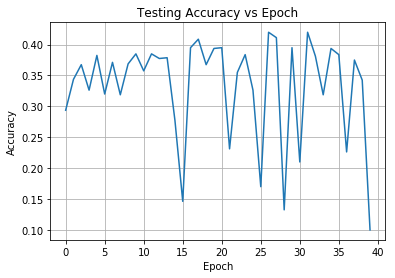

max test 0.42
max train @ max test 0.36921152
Hidden Units:  32
Momentum:  0.5
Epoch: 0001 cost=1900.815647670
Epoch: 0002 cost=271.895069667
Epoch: 0003 cost=187.917962211
Epoch: 0004 cost=169.951812744
Epoch: 0005 cost=178.126534598
Epoch: 0006 cost=177.821550642
Epoch: 0007 cost=176.359935216
Epoch: 0008 cost=181.295709882
Epoch: 0009 cost=196.061510359
Epoch: 0010 cost=182.049076625
Epoch: 0011 cost=139.721575056
Epoch: 0012 cost=189.388696943
Epoch: 0013 cost=171.046713693
Epoch: 0014 cost=147.016169957
Epoch: 0015 cost=122.640953064
Epoch: 0016 cost=133.737513951
Epoch: 0017 cost=116.650132315
Epoch: 0018 cost=107.793980190
Epoch: 0019 cost=142.151669638
Epoch: 0020 cost=138.062075479
Epoch: 0021 cost=121.199601310
Epoch: 0022 cost=151.831118992
Epoch: 0023 cost=117.607540676
Epoch: 0024 cost=75.639243535
Epoch: 0025 cost=88.961358752
Epoch: 0026 cost=87.961876460
Epoch: 0027 cost=94.903588976
Epoch: 0028 cost=73.608479091
Epoch: 0029 cost=100.819772993
Epoch: 0030 cost=85.130480

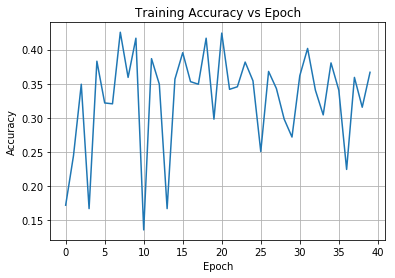

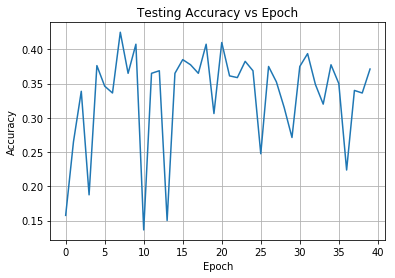

max test 0.425
max train @ max test 0.42553192
Hidden Units:  32
Momentum:  0.9
Epoch: 0001 cost=729.589037214
Epoch: 0002 cost=430.747894287
Epoch: 0003 cost=308.822208949
Epoch: 0004 cost=175.181782314
Epoch: 0005 cost=152.474428449
Epoch: 0006 cost=104.564314161
Epoch: 0007 cost=82.510791234
Epoch: 0008 cost=95.668042864
Epoch: 0009 cost=95.412318638
Epoch: 0010 cost=67.928764888
Epoch: 0011 cost=50.999439240
Epoch: 0012 cost=41.804725102
Epoch: 0013 cost=56.505395072
Epoch: 0014 cost=62.002845219
Epoch: 0015 cost=50.926759992
Epoch: 0016 cost=72.986343929
Epoch: 0017 cost=61.656170436
Epoch: 0018 cost=66.330372947
Epoch: 0019 cost=52.798830850
Epoch: 0020 cost=55.518452236
Epoch: 0021 cost=49.713786261
Epoch: 0022 cost=63.077917916
Epoch: 0023 cost=40.753468650
Epoch: 0024 cost=58.670688629
Epoch: 0025 cost=54.957150051
Epoch: 0026 cost=48.220485142
Epoch: 0027 cost=53.945814950
Epoch: 0028 cost=45.465174539
Epoch: 0029 cost=53.744870867
Epoch: 0030 cost=44.551897866
Epoch: 0031 co

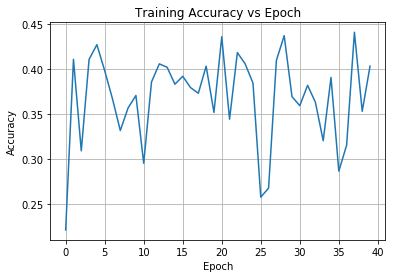

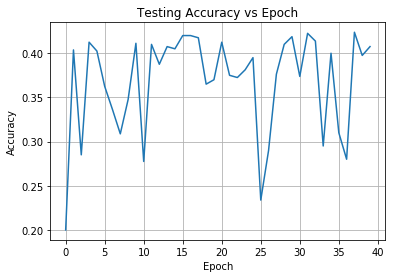

max test 0.42375
max train @ max test 0.44055068
Hidden Units:  128
Momentum:  0
Epoch: 0001 cost=4639.104143415
Epoch: 0002 cost=2776.782034738
Epoch: 0003 cost=2203.885253906
Epoch: 0004 cost=2817.885968890
Epoch: 0005 cost=2338.124040876
Epoch: 0006 cost=2212.630161830
Epoch: 0007 cost=2027.474243164
Epoch: 0008 cost=2257.429103306
Epoch: 0009 cost=2087.770612444
Epoch: 0010 cost=2416.065638951
Epoch: 0011 cost=1781.865827288
Epoch: 0012 cost=1596.844360352
Epoch: 0013 cost=1968.967825753
Epoch: 0014 cost=1787.346906390
Epoch: 0015 cost=1838.661865234
Epoch: 0016 cost=1904.212036133
Epoch: 0017 cost=1462.782767160
Epoch: 0018 cost=1576.355215890
Epoch: 0019 cost=1294.420061384
Epoch: 0020 cost=1585.682904925
Epoch: 0021 cost=1305.540570940
Epoch: 0022 cost=1369.262390137
Epoch: 0023 cost=1163.583356585
Epoch: 0024 cost=1149.801269531
Epoch: 0025 cost=1303.669695173
Epoch: 0026 cost=1157.274021694
Epoch: 0027 cost=1319.845101493
Epoch: 0028 cost=1107.071881975
Epoch: 0029 cost=1071.7

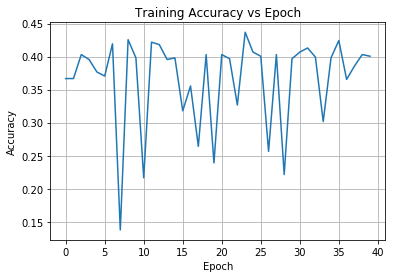

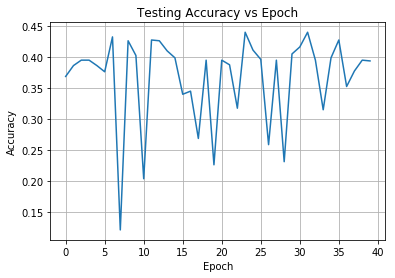

max test 0.44
max train @ max test 0.436796
Hidden Units:  128
Momentum:  0.2
Epoch: 0001 cost=2679.442871094
Epoch: 0002 cost=2693.183820452
Epoch: 0003 cost=2710.759225028
Epoch: 0004 cost=1992.289385114
Epoch: 0005 cost=2368.851152693
Epoch: 0006 cost=1671.492178781
Epoch: 0007 cost=2245.047258650
Epoch: 0008 cost=2200.491768973
Epoch: 0009 cost=2015.096191406
Epoch: 0010 cost=1881.326991490
Epoch: 0011 cost=2109.580636161
Epoch: 0012 cost=1780.332066127
Epoch: 0013 cost=1789.257611956
Epoch: 0014 cost=1564.247811454
Epoch: 0015 cost=1864.164446150
Epoch: 0016 cost=1777.307163783
Epoch: 0017 cost=1283.892735073
Epoch: 0018 cost=1487.914027623
Epoch: 0019 cost=1687.379656110
Epoch: 0020 cost=1548.549525670
Epoch: 0021 cost=1236.452008929
Epoch: 0022 cost=1433.235613142
Epoch: 0023 cost=1448.689566476
Epoch: 0024 cost=1404.997436523
Epoch: 0025 cost=1173.136308943
Epoch: 0026 cost=1254.823765346
Epoch: 0027 cost=1266.863289969
Epoch: 0028 cost=1539.901428223
Epoch: 0029 cost=978.57398

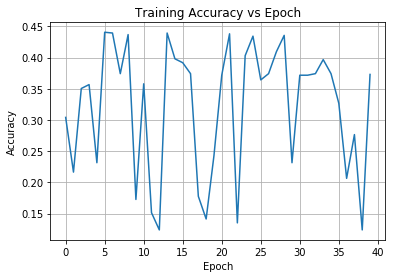

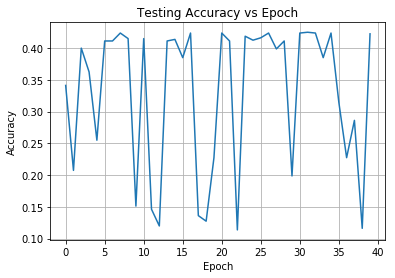

max test 0.425
max train @ max test 0.37171465
Hidden Units:  128
Momentum:  0.5
Epoch: 0001 cost=6370.309640067
Epoch: 0002 cost=5280.899797712
Epoch: 0003 cost=3697.065429688
Epoch: 0004 cost=4568.971784319
Epoch: 0005 cost=3308.894304548
Epoch: 0006 cost=2279.018083845
Epoch: 0007 cost=1627.783142090
Epoch: 0008 cost=2584.024361747
Epoch: 0009 cost=3118.681867327
Epoch: 0010 cost=1480.567783901
Epoch: 0011 cost=1930.758335658
Epoch: 0012 cost=1607.186998640
Epoch: 0013 cost=1755.410827637
Epoch: 0014 cost=1247.938162667
Epoch: 0015 cost=1316.227539062
Epoch: 0016 cost=985.527086530
Epoch: 0017 cost=1273.673270089
Epoch: 0018 cost=1030.209394182
Epoch: 0019 cost=1048.656720843
Epoch: 0020 cost=1325.771545410
Epoch: 0021 cost=933.926034110
Epoch: 0022 cost=946.265345982
Epoch: 0023 cost=713.811257499
Epoch: 0024 cost=967.715144566
Epoch: 0025 cost=1020.131155831
Epoch: 0026 cost=920.569802420
Epoch: 0027 cost=1058.626552037
Epoch: 0028 cost=826.499193464
Epoch: 0029 cost=689.878204346

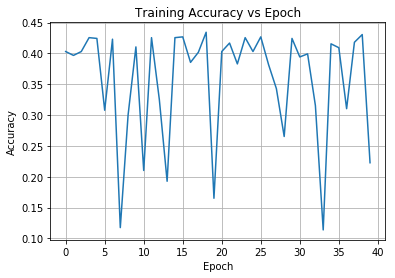

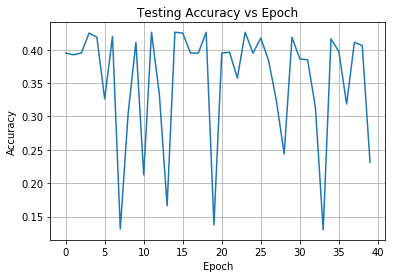

max test 0.42625
max train @ max test 0.42553192
Hidden Units:  128
Momentum:  0.9
Epoch: 0001 cost=8522.619140625
Epoch: 0002 cost=5230.375767299
Epoch: 0003 cost=3518.631696429
Epoch: 0004 cost=2204.338779994
Epoch: 0005 cost=1393.259347098
Epoch: 0006 cost=1324.771911621
Epoch: 0007 cost=901.192722866
Epoch: 0008 cost=794.413504464
Epoch: 0009 cost=801.869140625
Epoch: 0010 cost=710.205370222
Epoch: 0011 cost=452.399183001
Epoch: 0012 cost=360.711308071
Epoch: 0013 cost=291.025924683
Epoch: 0014 cost=346.787580218
Epoch: 0015 cost=294.623986380
Epoch: 0016 cost=242.623528617
Epoch: 0017 cost=402.710950579
Epoch: 0018 cost=481.427433559
Epoch: 0019 cost=314.408102853
Epoch: 0020 cost=257.795959473
Epoch: 0021 cost=188.012332371
Epoch: 0022 cost=162.165723528
Epoch: 0023 cost=168.253386361
Epoch: 0024 cost=167.653961182
Epoch: 0025 cost=125.732462202
Epoch: 0026 cost=120.354068211
Epoch: 0027 cost=223.011629377
Epoch: 0028 cost=232.135062081
Epoch: 0029 cost=139.952650888
Epoch: 0030 

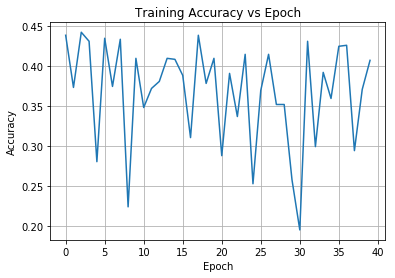

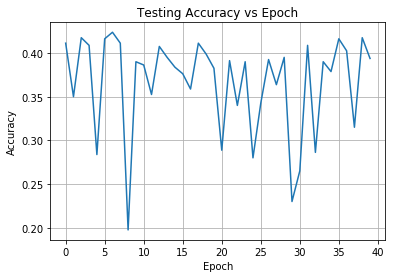

max test 0.42375
max train @ max test 0.37421778


In [7]:
# do the rest with the different hyperparameters, this si for winequality
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    
    for j  in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("winequality-red.csv", ";", 0.5, 0.0001, 40, 100, i, 1, j, ac_list, True, False)

In [8]:
out = np.argmax(np.array(ac_list)) +1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  4
Opt Momentum:  0.5
Maximum Test Accuracy:  0.45125


Hidden Units:  1
Momentum:  0
Epoch: 0001 cost=19.784210205
Epoch: 0002 cost=18.197867076
Epoch: 0003 cost=16.665069580
Epoch: 0004 cost=15.181904793
Epoch: 0005 cost=13.745131175
Epoch: 0006 cost=12.352366765
Epoch: 0007 cost=11.002380371
Epoch: 0008 cost=9.695551236
Epoch: 0009 cost=8.434602737
Epoch: 0010 cost=7.225774765
Epoch: 0011 cost=6.080678781
Epoch: 0012 cost=5.019377232
Epoch: 0013 cost=4.075407028
Epoch: 0014 cost=3.301381270
Epoch: 0015 cost=2.760396560
Epoch: 0016 cost=2.471316258
Epoch: 0017 cost=2.358317852
Epoch: 0018 cost=2.323192199
Epoch: 0019 cost=2.313393116
Epoch: 0020 cost=2.310598135
Epoch: 0021 cost=2.309708754
Epoch: 0022 cost=2.309365273
Epoch: 0023 cost=2.309185187
Epoch: 0024 cost=2.309056123
Epoch: 0025 cost=2.308942954
Epoch: 0026 cost=2.308834871
Epoch: 0027 cost=2.308728456
Epoch: 0028 cost=2.308622599
Epoch: 0029 cost=2.308516900
Epoch: 0030 cost=2.308411201
Epoch: 0031 cost=2.308305740
Epoch: 0032 cost=2.308200200
Epoch: 0033 cost=2.308094660
Epoch:

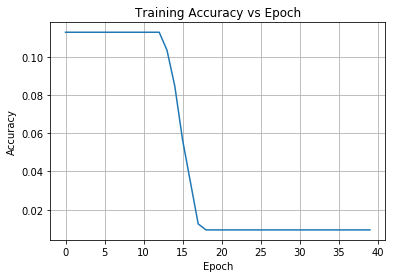

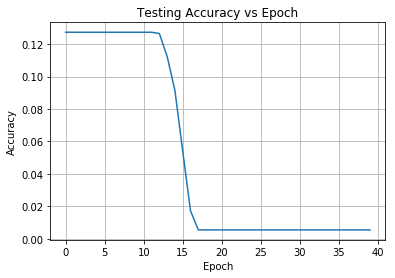

max test 0.12734374
max train @ max test 0.11285266
Hidden Units:  1
Momentum:  0.2
Epoch: 0001 cost=80.166753133
Epoch: 0002 cost=70.875335693
Epoch: 0003 cost=62.429228465
Epoch: 0004 cost=55.039549510
Epoch: 0005 cost=48.556900024
Epoch: 0006 cost=42.860446930
Epoch: 0007 cost=37.850840251
Epoch: 0008 cost=33.446898142
Epoch: 0009 cost=29.596280416
Epoch: 0010 cost=26.230192184
Epoch: 0011 cost=23.266285578
Epoch: 0012 cost=20.660127004
Epoch: 0013 cost=18.399291356
Epoch: 0014 cost=16.443312645
Epoch: 0015 cost=14.731760661
Epoch: 0016 cost=13.229811986
Epoch: 0017 cost=11.903623581
Epoch: 0018 cost=10.719180743
Epoch: 0019 cost=9.650982539
Epoch: 0020 cost=8.681170781
Epoch: 0021 cost=7.796435674
Epoch: 0022 cost=6.985884190
Epoch: 0023 cost=6.240149816
Epoch: 0024 cost=5.551439921
Epoch: 0025 cost=4.913820426
Epoch: 0026 cost=4.323513031
Epoch: 0027 cost=3.779435714
Epoch: 0028 cost=3.284109990
Epoch: 0029 cost=2.844661554
Epoch: 0030 cost=2.472717603
Epoch: 0031 cost=2.180912733

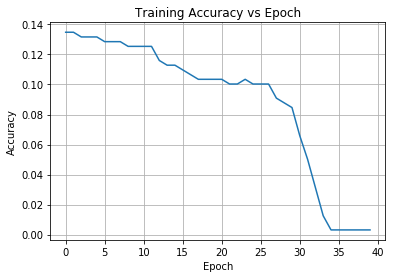

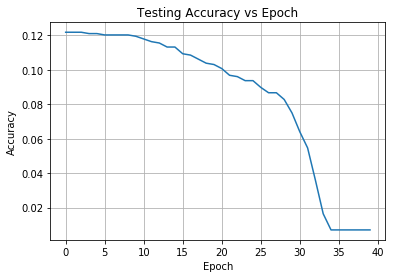

max test 0.121875
max train @ max test 0.13479623
Hidden Units:  1
Momentum:  0.5
Epoch: 0001 cost=140.372019450
Epoch: 0002 cost=128.903086344
Epoch: 0003 cost=116.765714010
Epoch: 0004 cost=105.869249980
Epoch: 0005 cost=96.253611247
Epoch: 0006 cost=87.758038839
Epoch: 0007 cost=80.225255330
Epoch: 0008 cost=73.521402995
Epoch: 0009 cost=67.534144084
Epoch: 0010 cost=62.168984731
Epoch: 0011 cost=57.346019745
Epoch: 0012 cost=52.997427622
Epoch: 0013 cost=49.065350850
Epoch: 0014 cost=45.500217438
Epoch: 0015 cost=42.259389242
Epoch: 0016 cost=39.306056976
Epoch: 0017 cost=36.608325958
Epoch: 0018 cost=34.138446808
Epoch: 0019 cost=31.872236252
Epoch: 0020 cost=29.788489660
Epoch: 0021 cost=27.868618011
Epoch: 0022 cost=26.096253713
Epoch: 0023 cost=24.456947962
Epoch: 0024 cost=22.937921524
Epoch: 0025 cost=21.527833303
Epoch: 0026 cost=20.216620763
Epoch: 0027 cost=18.995330175
Epoch: 0028 cost=17.855991999
Epoch: 0029 cost=16.791521072
Epoch: 0030 cost=15.795619647
Epoch: 0031 co

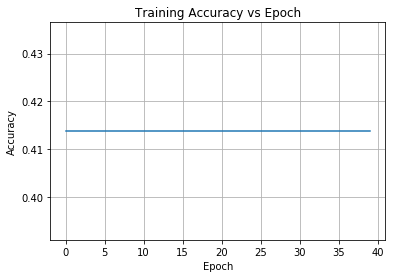

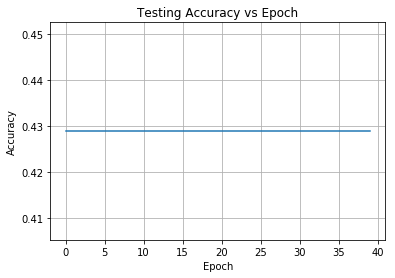

max test 0.42890626
max train @ max test 0.41379312
Hidden Units:  1
Momentum:  0.9
Epoch: 0001 cost=10.626468658
Epoch: 0002 cost=9.684157054
Epoch: 0003 cost=8.156846682
Epoch: 0004 cost=6.390567303
Epoch: 0005 cost=4.703421116
Epoch: 0006 cost=3.583422820
Epoch: 0007 cost=3.842616002
Epoch: 0008 cost=4.237881343
Epoch: 0009 cost=3.805891116
Epoch: 0010 cost=3.270841360
Epoch: 0011 cost=3.225406726
Epoch: 0012 cost=3.314649741
Epoch: 0013 cost=3.267118295
Epoch: 0014 cost=3.116385221
Epoch: 0015 cost=2.979993502
Epoch: 0016 cost=2.943851312
Epoch: 0017 cost=2.940359036
Epoch: 0018 cost=2.887913545
Epoch: 0019 cost=2.822296937
Epoch: 0020 cost=2.785731395
Epoch: 0021 cost=2.762297948
Epoch: 0022 cost=2.730929772
Epoch: 0023 cost=2.693285227
Epoch: 0024 cost=2.659645240
Epoch: 0025 cost=2.632483880
Epoch: 0026 cost=2.606466055
Epoch: 0027 cost=2.578640064
Epoch: 0028 cost=2.551032782
Epoch: 0029 cost=2.525485118
Epoch: 0030 cost=2.501379490
Epoch: 0031 cost=2.477589130
Epoch: 0032 cost

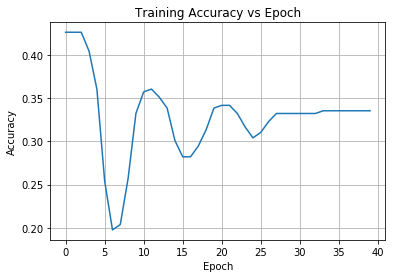

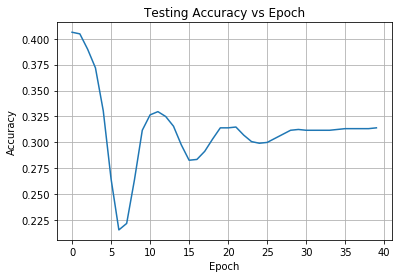

max test 0.40625
max train @ max test 0.4263323
Hidden Units:  2
Momentum:  0
Epoch: 0001 cost=36.136669159
Epoch: 0002 cost=32.556433996
Epoch: 0003 cost=29.953907013
Epoch: 0004 cost=28.410149892
Epoch: 0005 cost=27.491485596
Epoch: 0006 cost=26.828016917
Epoch: 0007 cost=26.299669902
Epoch: 0008 cost=25.838034312
Epoch: 0009 cost=25.393759410
Epoch: 0010 cost=24.957594554
Epoch: 0011 cost=24.528837204
Epoch: 0012 cost=24.107165655
Epoch: 0013 cost=23.692247391
Epoch: 0014 cost=23.283744812
Epoch: 0015 cost=22.881348292
Epoch: 0016 cost=22.484779994
Epoch: 0017 cost=22.093805949
Epoch: 0018 cost=21.708230337
Epoch: 0019 cost=21.327889760
Epoch: 0020 cost=20.952667872
Epoch: 0021 cost=20.582491557
Epoch: 0022 cost=20.217307409
Epoch: 0023 cost=19.857081095
Epoch: 0024 cost=19.501764933
Epoch: 0025 cost=19.151277542
Epoch: 0026 cost=18.805516561
Epoch: 0027 cost=18.464337031
Epoch: 0028 cost=18.127588908
Epoch: 0029 cost=17.795127233
Epoch: 0030 cost=17.466815313
Epoch: 0031 cost=17.14

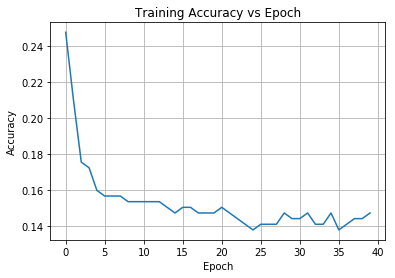

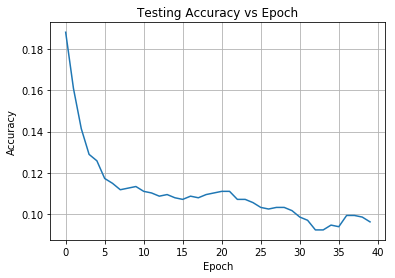

max test 0.18828125
max train @ max test 0.24764891
Hidden Units:  2
Momentum:  0.2
Epoch: 0001 cost=63.888741811
Epoch: 0002 cost=57.963310242
Epoch: 0003 cost=54.244729360
Epoch: 0004 cost=51.885389964
Epoch: 0005 cost=50.258857727
Epoch: 0006 cost=48.996089935
Epoch: 0007 cost=47.890548706
Epoch: 0008 cost=46.838147481
Epoch: 0009 cost=45.820027669
Epoch: 0010 cost=44.834818522
Epoch: 0011 cost=43.882806142
Epoch: 0012 cost=42.960952759
Epoch: 0013 cost=42.066435496
Epoch: 0014 cost=41.197794596
Epoch: 0015 cost=40.353936513
Epoch: 0016 cost=39.533860524
Epoch: 0017 cost=38.736597697
Epoch: 0018 cost=37.961246490
Epoch: 0019 cost=37.206930796
Epoch: 0020 cost=36.472829183
Epoch: 0021 cost=35.758145650
Epoch: 0022 cost=35.062109629
Epoch: 0023 cost=34.384000142
Epoch: 0024 cost=33.723122915
Epoch: 0025 cost=33.078802745
Epoch: 0026 cost=32.450402578
Epoch: 0027 cost=31.837306976
Epoch: 0028 cost=31.238919576
Epoch: 0029 cost=30.654685974
Epoch: 0030 cost=30.084070206
Epoch: 0031 cost

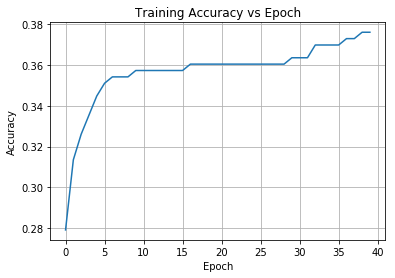

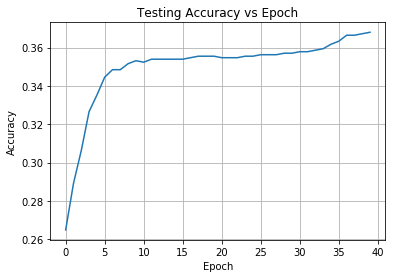

max test 0.36796874
max train @ max test 0.37617555
Hidden Units:  2
Momentum:  0.5
Epoch: 0001 cost=19.080451330
Epoch: 0002 cost=17.722028097
Epoch: 0003 cost=16.533810933
Epoch: 0004 cost=15.681595167
Epoch: 0005 cost=14.975677172
Epoch: 0006 cost=14.364959081
Epoch: 0007 cost=13.856902440
Epoch: 0008 cost=13.433046659
Epoch: 0009 cost=13.070415815
Epoch: 0010 cost=12.754748027
Epoch: 0011 cost=12.475452423
Epoch: 0012 cost=12.222287178
Epoch: 0013 cost=11.988216718
Epoch: 0014 cost=11.769235293
Epoch: 0015 cost=11.562850952
Epoch: 0016 cost=11.367226601
Epoch: 0017 cost=11.180845579
Epoch: 0018 cost=11.002414385
Epoch: 0019 cost=10.830841700
Epoch: 0020 cost=10.665216446
Epoch: 0021 cost=10.504782995
Epoch: 0022 cost=10.348924319
Epoch: 0023 cost=10.197134654
Epoch: 0024 cost=10.048998197
Epoch: 0025 cost=9.904166857
Epoch: 0026 cost=9.762351990
Epoch: 0027 cost=9.623303413
Epoch: 0028 cost=9.486811638
Epoch: 0029 cost=9.352692286
Epoch: 0030 cost=9.220788002
Epoch: 0031 cost=9.090

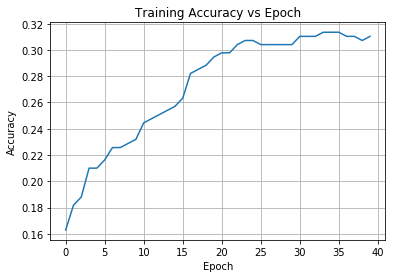

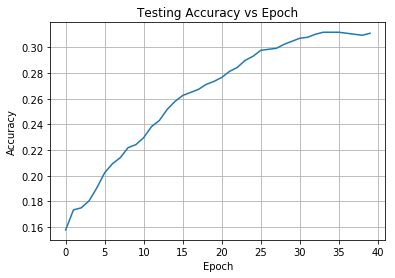

max test 0.31171876
max train @ max test 0.31347963
Hidden Units:  2
Momentum:  0.9
Epoch: 0001 cost=30.853424708
Epoch: 0002 cost=27.456981023
Epoch: 0003 cost=22.486607869
Epoch: 0004 cost=17.580703735
Epoch: 0005 cost=13.646843274
Epoch: 0006 cost=10.890059153
Epoch: 0007 cost=9.008387248
Epoch: 0008 cost=7.616666317
Epoch: 0009 cost=6.558137735
Epoch: 0010 cost=5.655995846
Epoch: 0011 cost=4.958281517
Epoch: 0012 cost=4.577446938
Epoch: 0013 cost=4.439877828
Epoch: 0014 cost=4.359113216
Epoch: 0015 cost=4.275681019
Epoch: 0016 cost=4.171599070
Epoch: 0017 cost=4.048556169
Epoch: 0018 cost=3.918793678
Epoch: 0019 cost=3.796337207
Epoch: 0020 cost=3.691048066
Epoch: 0021 cost=3.606683413
Epoch: 0022 cost=3.540446281
Epoch: 0023 cost=3.483476321
Epoch: 0024 cost=3.427127759
Epoch: 0025 cost=3.369317691
Epoch: 0026 cost=3.313423634
Epoch: 0027 cost=3.262759288
Epoch: 0028 cost=3.217720509
Epoch: 0029 cost=3.176604350
Epoch: 0030 cost=3.137596210
Epoch: 0031 cost=3.099817435
Epoch: 0032

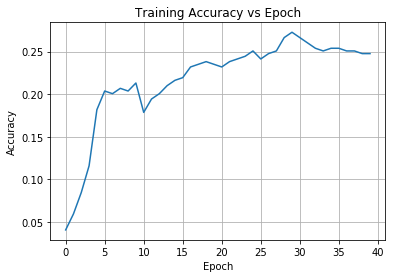

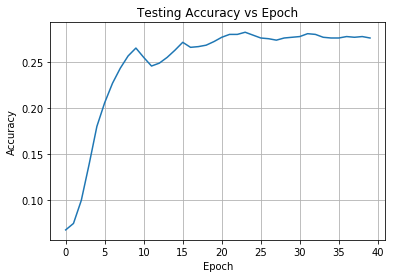

max test 0.2828125
max train @ max test 0.24451411
Hidden Units:  4
Momentum:  0
Epoch: 0001 cost=94.097724915
Epoch: 0002 cost=87.496950785
Epoch: 0003 cost=81.408899943
Epoch: 0004 cost=75.711380005
Epoch: 0005 cost=70.481529236
Epoch: 0006 cost=65.746536255
Epoch: 0007 cost=61.343513489
Epoch: 0008 cost=57.281382243
Epoch: 0009 cost=53.526067098
Epoch: 0010 cost=50.086833954
Epoch: 0011 cost=47.142588298
Epoch: 0012 cost=44.743006388
Epoch: 0013 cost=42.714547475
Epoch: 0014 cost=40.963231405
Epoch: 0015 cost=39.537076314
Epoch: 0016 cost=38.329577128
Epoch: 0017 cost=37.360336304
Epoch: 0018 cost=36.588186900
Epoch: 0019 cost=35.999563853
Epoch: 0020 cost=35.483488719
Epoch: 0021 cost=35.011412303
Epoch: 0022 cost=34.579073588
Epoch: 0023 cost=34.176911672
Epoch: 0024 cost=33.795285543
Epoch: 0025 cost=33.430084229
Epoch: 0026 cost=33.078711192
Epoch: 0027 cost=32.738348643
Epoch: 0028 cost=32.406696320
Epoch: 0029 cost=32.083628972
Epoch: 0030 cost=31.773885727
Epoch: 0031 cost=31

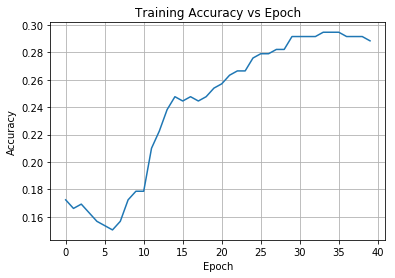

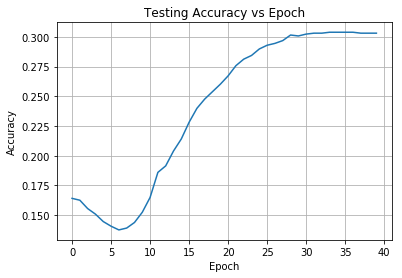

max test 0.30390626
max train @ max test 0.29467085
Hidden Units:  4
Momentum:  0.2
Epoch: 0001 cost=216.324462891
Epoch: 0002 cost=180.860102336
Epoch: 0003 cost=148.926818848
Epoch: 0004 cost=120.038497925
Epoch: 0005 cost=96.163177490
Epoch: 0006 cost=82.406244914
Epoch: 0007 cost=73.886817932
Epoch: 0008 cost=67.161588033
Epoch: 0009 cost=61.380489349
Epoch: 0010 cost=56.350688934
Epoch: 0011 cost=51.961130778
Epoch: 0012 cost=48.215531667
Epoch: 0013 cost=45.060986837
Epoch: 0014 cost=42.393751780
Epoch: 0015 cost=40.378014882
Epoch: 0016 cost=38.812637329
Epoch: 0017 cost=37.420276642
Epoch: 0018 cost=36.248221080
Epoch: 0019 cost=35.352934519
Epoch: 0020 cost=34.595300039
Epoch: 0021 cost=33.912857056
Epoch: 0022 cost=33.265598297
Epoch: 0023 cost=32.655152639
Epoch: 0024 cost=32.130673091
Epoch: 0025 cost=31.689668020
Epoch: 0026 cost=31.281202952
Epoch: 0027 cost=30.893765767
Epoch: 0028 cost=30.528970083
Epoch: 0029 cost=30.186773300
Epoch: 0030 cost=29.862621943
Epoch: 0031 

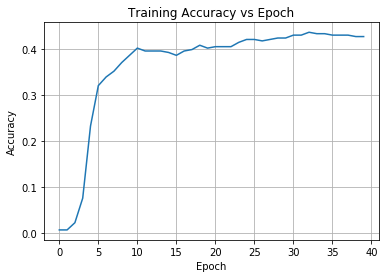

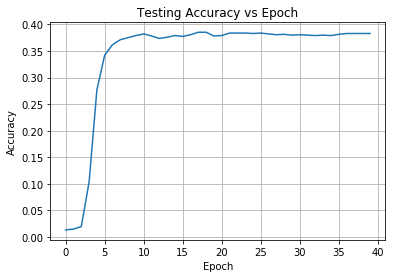

max test 0.38515624
max train @ max test 0.39811912
Hidden Units:  4
Momentum:  0.5
Epoch: 0001 cost=553.813496908
Epoch: 0002 cost=329.101816813
Epoch: 0003 cost=220.038324992
Epoch: 0004 cost=138.342931112
Epoch: 0005 cost=68.112222036
Epoch: 0006 cost=48.278964996
Epoch: 0007 cost=45.831358592
Epoch: 0008 cost=44.245184580
Epoch: 0009 cost=43.039211273
Epoch: 0010 cost=41.905185699
Epoch: 0011 cost=40.799575806
Epoch: 0012 cost=39.715047201
Epoch: 0013 cost=38.647974650
Epoch: 0014 cost=37.597001394
Epoch: 0015 cost=36.561353048
Epoch: 0016 cost=35.541076660
Epoch: 0017 cost=34.538623810
Epoch: 0018 cost=33.559637705
Epoch: 0019 cost=32.610187531
Epoch: 0020 cost=31.697172165
Epoch: 0021 cost=30.819444021
Epoch: 0022 cost=29.974304199
Epoch: 0023 cost=29.162591934
Epoch: 0024 cost=28.380228043
Epoch: 0025 cost=27.623897552
Epoch: 0026 cost=26.891654968
Epoch: 0027 cost=26.180641810
Epoch: 0028 cost=25.488946915
Epoch: 0029 cost=24.816358566
Epoch: 0030 cost=24.161280950
Epoch: 0031 

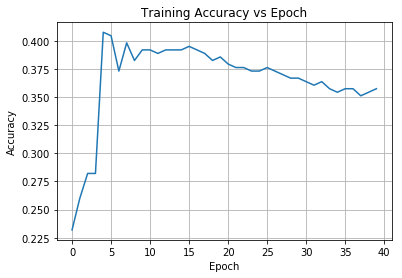

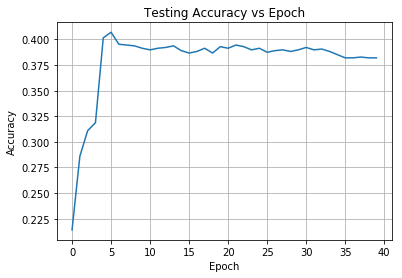

max test 0.40703124
max train @ max test 0.40438873
Hidden Units:  4
Momentum:  0.9
Epoch: 0001 cost=76.367146810
Epoch: 0002 cost=66.009081523
Epoch: 0003 cost=62.209482829
Epoch: 0004 cost=55.248168945
Epoch: 0005 cost=46.452587128
Epoch: 0006 cost=38.831235250
Epoch: 0007 cost=34.507623037
Epoch: 0008 cost=30.204780579
Epoch: 0009 cost=27.859909693
Epoch: 0010 cost=24.350632985
Epoch: 0011 cost=20.897476832
Epoch: 0012 cost=17.912623088
Epoch: 0013 cost=14.985313733
Epoch: 0014 cost=13.238228798
Epoch: 0015 cost=11.779108047
Epoch: 0016 cost=11.014014244
Epoch: 0017 cost=10.219202995
Epoch: 0018 cost=9.573027611
Epoch: 0019 cost=8.838099798
Epoch: 0020 cost=8.250668526
Epoch: 0021 cost=7.670564651
Epoch: 0022 cost=7.199766318
Epoch: 0023 cost=6.724236488
Epoch: 0024 cost=6.368313154
Epoch: 0025 cost=6.097707589
Epoch: 0026 cost=5.865565936
Epoch: 0027 cost=5.691902955
Epoch: 0028 cost=5.543156942
Epoch: 0029 cost=5.413668315
Epoch: 0030 cost=5.296098391
Epoch: 0031 cost=5.198392709


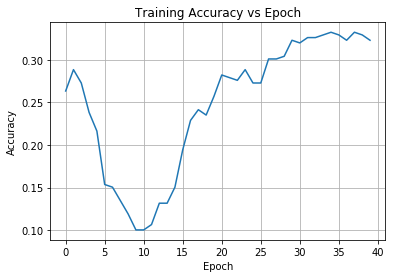

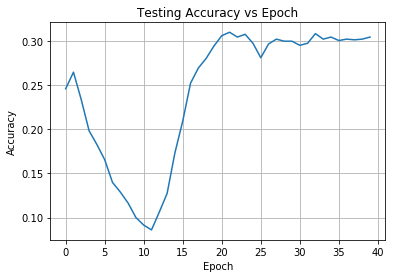

max test 0.31015626
max train @ max test 0.27899686
Hidden Units:  8
Momentum:  0
Epoch: 0001 cost=475.228312174
Epoch: 0002 cost=289.629435221
Epoch: 0003 cost=243.410008748
Epoch: 0004 cost=215.135904948
Epoch: 0005 cost=188.905019124
Epoch: 0006 cost=164.114715576
Epoch: 0007 cost=140.579442342
Epoch: 0008 cost=120.416208903
Epoch: 0009 cost=104.299769084
Epoch: 0010 cost=89.032923381
Epoch: 0011 cost=74.385322571
Epoch: 0012 cost=60.348424276
Epoch: 0013 cost=47.302321116
Epoch: 0014 cost=37.535888672
Epoch: 0015 cost=34.104783376
Epoch: 0016 cost=32.844553630
Epoch: 0017 cost=31.900966644
Epoch: 0018 cost=31.008250554
Epoch: 0019 cost=30.128441493
Epoch: 0020 cost=29.255781174
Epoch: 0021 cost=28.389083862
Epoch: 0022 cost=27.528105418
Epoch: 0023 cost=26.673180262
Epoch: 0024 cost=25.835201899
Epoch: 0025 cost=25.026027044
Epoch: 0026 cost=24.229357402
Epoch: 0027 cost=23.440071106
Epoch: 0028 cost=22.657031377
Epoch: 0029 cost=21.879758199
Epoch: 0030 cost=21.107947667
Epoch: 00

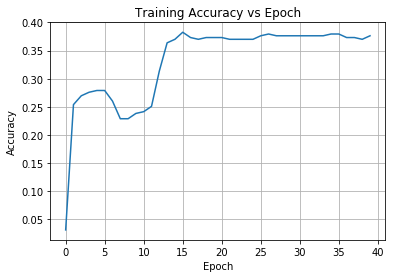

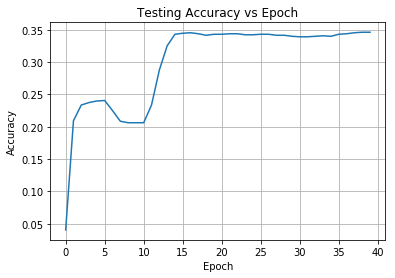

max test 0.34609374
max train @ max test 0.36990595
Hidden Units:  8
Momentum:  0.2
Epoch: 0001 cost=522.719451904
Epoch: 0002 cost=273.381261190
Epoch: 0003 cost=129.056083679
Epoch: 0004 cost=94.521247864
Epoch: 0005 cost=90.838696798
Epoch: 0006 cost=88.463645935
Epoch: 0007 cost=86.465677897
Epoch: 0008 cost=84.567769368
Epoch: 0009 cost=82.741383870
Epoch: 0010 cost=80.961545308
Epoch: 0011 cost=79.213556925
Epoch: 0012 cost=77.492006938
Epoch: 0013 cost=75.794471741
Epoch: 0014 cost=74.119506836
Epoch: 0015 cost=72.466044108
Epoch: 0016 cost=70.833134969
Epoch: 0017 cost=69.219881694
Epoch: 0018 cost=67.625528971
Epoch: 0019 cost=66.049367269
Epoch: 0020 cost=64.490896861
Epoch: 0021 cost=62.949954987
Epoch: 0022 cost=61.426862081
Epoch: 0023 cost=59.921784719
Epoch: 0024 cost=58.435288747
Epoch: 0025 cost=56.968259176
Epoch: 0026 cost=55.521504720
Epoch: 0027 cost=54.095939636
Epoch: 0028 cost=52.736272176
Epoch: 0029 cost=51.371381124
Epoch: 0030 cost=50.015380859
Epoch: 0031 c

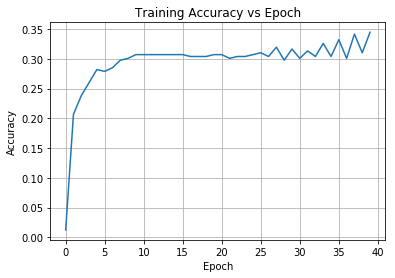

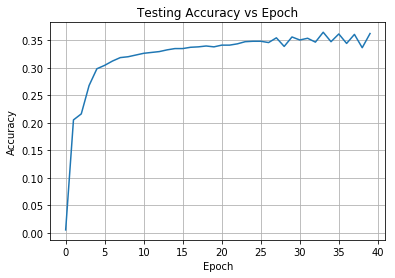

max test 0.36484376
max train @ max test 0.3260188
Hidden Units:  8
Momentum:  0.5
Epoch: 0001 cost=427.786804199
Epoch: 0002 cost=213.441533407
Epoch: 0003 cost=135.305880229
Epoch: 0004 cost=74.448769887
Epoch: 0005 cost=39.133772532
Epoch: 0006 cost=32.767809550
Epoch: 0007 cost=28.577121735
Epoch: 0008 cost=25.171377818
Epoch: 0009 cost=22.062337240
Epoch: 0010 cost=19.250096003
Epoch: 0011 cost=18.210650762
Epoch: 0012 cost=17.663017909
Epoch: 0013 cost=17.178796132
Epoch: 0014 cost=16.737073263
Epoch: 0015 cost=16.331054688
Epoch: 0016 cost=15.950146993
Epoch: 0017 cost=15.587837537
Epoch: 0018 cost=15.241546631
Epoch: 0019 cost=14.908714612
Epoch: 0020 cost=14.586795807
Epoch: 0021 cost=14.274738630
Epoch: 0022 cost=13.972758929
Epoch: 0023 cost=13.681640307
Epoch: 0024 cost=13.402081172
Epoch: 0025 cost=13.134018580
Epoch: 0026 cost=12.876776695
Epoch: 0027 cost=12.630009969
Epoch: 0028 cost=12.394023259
Epoch: 0029 cost=12.168939273
Epoch: 0030 cost=11.954043070
Epoch: 0031 co

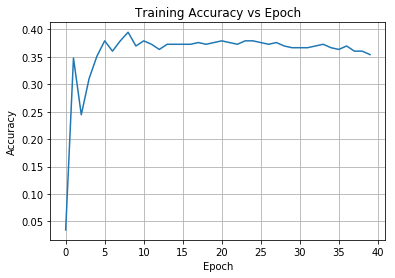

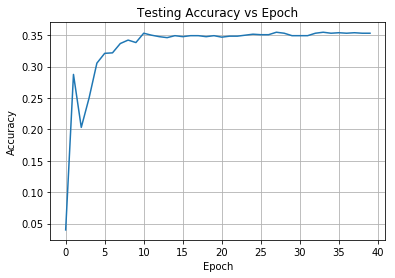

max test 0.3546875
max train @ max test 0.37617555
Hidden Units:  8
Momentum:  0.9
Epoch: 0001 cost=865.425028483
Epoch: 0002 cost=184.737345378
Epoch: 0003 cost=121.865854899
Epoch: 0004 cost=131.834103902
Epoch: 0005 cost=82.798283895
Epoch: 0006 cost=104.524843852
Epoch: 0007 cost=81.025517782
Epoch: 0008 cost=80.124745687
Epoch: 0009 cost=63.213102976
Epoch: 0010 cost=51.282089233
Epoch: 0011 cost=45.420356750
Epoch: 0012 cost=41.310569763
Epoch: 0013 cost=39.454683940
Epoch: 0014 cost=31.965020498
Epoch: 0015 cost=37.701784134
Epoch: 0016 cost=54.332712809
Epoch: 0017 cost=39.217731476
Epoch: 0018 cost=29.276817958
Epoch: 0019 cost=37.627293269
Epoch: 0020 cost=35.151659012
Epoch: 0021 cost=28.897923152
Epoch: 0022 cost=22.096900940
Epoch: 0023 cost=19.458097458
Epoch: 0024 cost=25.454802195
Epoch: 0025 cost=25.388427099
Epoch: 0026 cost=28.732794444
Epoch: 0027 cost=28.293276469
Epoch: 0028 cost=32.925648371
Epoch: 0029 cost=35.247953415
Epoch: 0030 cost=40.119703293
Epoch: 0031 

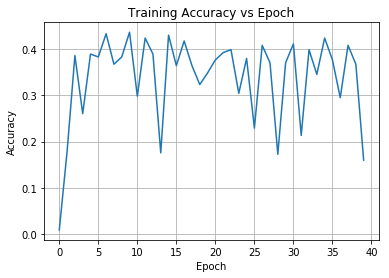

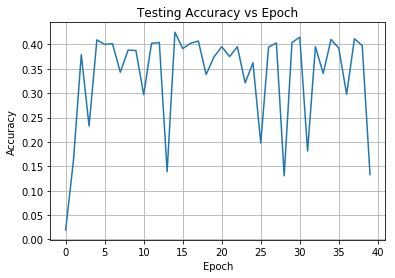

max test 0.425
max train @ max test 0.42946708
Hidden Units:  32
Momentum:  0
Epoch: 0001 cost=1170.373250326
Epoch: 0002 cost=343.741566976
Epoch: 0003 cost=243.973851522
Epoch: 0004 cost=262.366058350
Epoch: 0005 cost=216.772852580
Epoch: 0006 cost=261.212575277
Epoch: 0007 cost=197.416926066
Epoch: 0008 cost=239.242767334
Epoch: 0009 cost=224.358642578
Epoch: 0010 cost=231.586161296
Epoch: 0011 cost=196.422800700
Epoch: 0012 cost=212.258499146
Epoch: 0013 cost=223.177215576
Epoch: 0014 cost=240.555852254
Epoch: 0015 cost=177.569615682
Epoch: 0016 cost=216.265780131
Epoch: 0017 cost=205.070566813
Epoch: 0018 cost=226.242813110
Epoch: 0019 cost=192.564315796
Epoch: 0020 cost=201.510920207
Epoch: 0021 cost=191.555175781
Epoch: 0022 cost=191.812001546
Epoch: 0023 cost=167.771985372
Epoch: 0024 cost=173.476684570
Epoch: 0025 cost=216.245437622
Epoch: 0026 cost=186.518870036
Epoch: 0027 cost=206.994450887
Epoch: 0028 cost=211.656697591
Epoch: 0029 cost=169.131767273
Epoch: 0030 cost=192.1

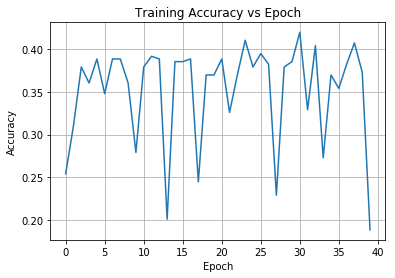

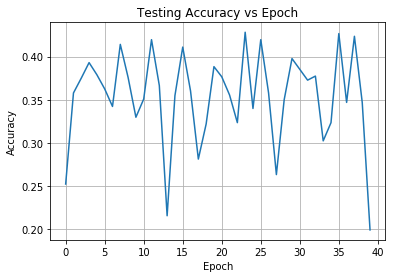

max test 0.428125
max train @ max test 0.4106583
Hidden Units:  32
Momentum:  0.2
Epoch: 0001 cost=606.424489339
Epoch: 0002 cost=357.612609863
Epoch: 0003 cost=438.927307129
Epoch: 0004 cost=384.087702433
Epoch: 0005 cost=380.403137207
Epoch: 0006 cost=353.896748861
Epoch: 0007 cost=366.016138713
Epoch: 0008 cost=314.431874593
Epoch: 0009 cost=334.317565918
Epoch: 0010 cost=296.127873739
Epoch: 0011 cost=304.151824951
Epoch: 0012 cost=257.826232910
Epoch: 0013 cost=298.704661051
Epoch: 0014 cost=255.832310994
Epoch: 0015 cost=284.479807536
Epoch: 0016 cost=205.308593750
Epoch: 0017 cost=264.031519572
Epoch: 0018 cost=308.958557129
Epoch: 0019 cost=226.884147644
Epoch: 0020 cost=229.328099569
Epoch: 0021 cost=265.921544393
Epoch: 0022 cost=184.551823934
Epoch: 0023 cost=241.976504008
Epoch: 0024 cost=280.444376628
Epoch: 0025 cost=223.888745626
Epoch: 0026 cost=239.087819417
Epoch: 0027 cost=162.234171549
Epoch: 0028 cost=284.578709920
Epoch: 0029 cost=209.579872131
Epoch: 0030 cost=22

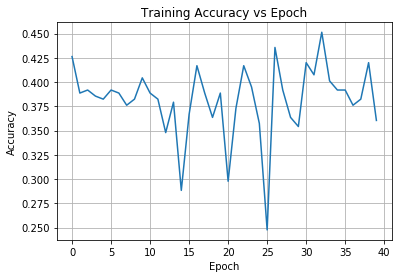

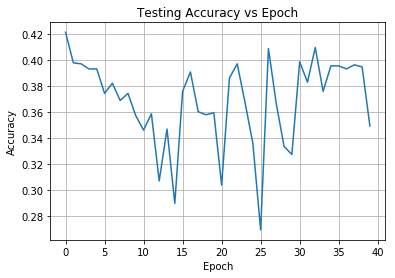

max test 0.42109376
max train @ max test 0.4263323
Hidden Units:  32
Momentum:  0.5
Epoch: 0001 cost=2571.407796224
Epoch: 0002 cost=786.544738770
Epoch: 0003 cost=519.007130941
Epoch: 0004 cost=361.783671061
Epoch: 0005 cost=309.535614014
Epoch: 0006 cost=274.231394450
Epoch: 0007 cost=245.040471395
Epoch: 0008 cost=224.525309245
Epoch: 0009 cost=191.234629313
Epoch: 0010 cost=170.123428345
Epoch: 0011 cost=167.709574382
Epoch: 0012 cost=155.076731364
Epoch: 0013 cost=171.126973470
Epoch: 0014 cost=217.071217855
Epoch: 0015 cost=154.361714681
Epoch: 0016 cost=151.277259827
Epoch: 0017 cost=191.019017537
Epoch: 0018 cost=198.383191427
Epoch: 0019 cost=146.040079753
Epoch: 0020 cost=154.376253764
Epoch: 0021 cost=147.612154643
Epoch: 0022 cost=142.563575745
Epoch: 0023 cost=173.457906087
Epoch: 0024 cost=142.589035034
Epoch: 0025 cost=178.911048889
Epoch: 0026 cost=108.727943420
Epoch: 0027 cost=136.823654175
Epoch: 0028 cost=167.722516378
Epoch: 0029 cost=69.574301402
Epoch: 0030 cost=

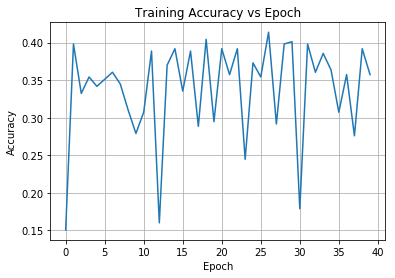

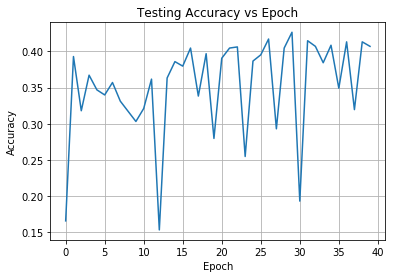

max test 0.4265625
max train @ max test 0.4012539
Hidden Units:  32
Momentum:  0.9
Epoch: 0001 cost=2540.614054362
Epoch: 0002 cost=818.563802083
Epoch: 0003 cost=883.523559570
Epoch: 0004 cost=671.073608398
Epoch: 0005 cost=513.649637858
Epoch: 0006 cost=658.387145996
Epoch: 0007 cost=456.610850016
Epoch: 0008 cost=515.048777262
Epoch: 0009 cost=487.721567790
Epoch: 0010 cost=394.987253825
Epoch: 0011 cost=346.477813721
Epoch: 0012 cost=355.212666829
Epoch: 0013 cost=278.545379639
Epoch: 0014 cost=298.795211792
Epoch: 0015 cost=236.907196045
Epoch: 0016 cost=195.613281250
Epoch: 0017 cost=148.154317220
Epoch: 0018 cost=134.339841207
Epoch: 0019 cost=115.989613851
Epoch: 0020 cost=109.066477458
Epoch: 0021 cost=126.466303507
Epoch: 0022 cost=103.803904215
Epoch: 0023 cost=91.005953471
Epoch: 0024 cost=93.840721130
Epoch: 0025 cost=82.747907003
Epoch: 0026 cost=83.326276143
Epoch: 0027 cost=92.996136983
Epoch: 0028 cost=156.690783183
Epoch: 0029 cost=155.570765177
Epoch: 0030 cost=154.6

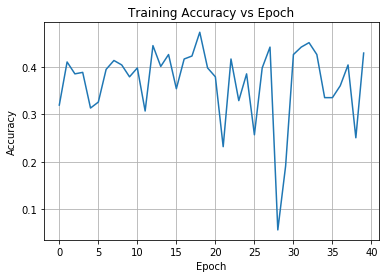

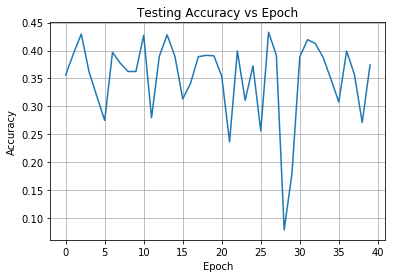

max test 0.4328125
max train @ max test 0.39811912
Hidden Units:  128
Momentum:  0
Epoch: 0001 cost=6331.907063802
Epoch: 0002 cost=3304.470052083
Epoch: 0003 cost=2767.609130859
Epoch: 0004 cost=2155.499064128
Epoch: 0005 cost=2184.047281901
Epoch: 0006 cost=2103.667643229
Epoch: 0007 cost=2593.485514323
Epoch: 0008 cost=1951.569681803
Epoch: 0009 cost=2245.757405599
Epoch: 0010 cost=2738.277140299
Epoch: 0011 cost=2113.605305990
Epoch: 0012 cost=2818.964558919
Epoch: 0013 cost=2232.696655273
Epoch: 0014 cost=1908.265096029
Epoch: 0015 cost=3140.948771159
Epoch: 0016 cost=2119.196166992
Epoch: 0017 cost=1631.626770020
Epoch: 0018 cost=2120.506266276
Epoch: 0019 cost=2184.428344727
Epoch: 0020 cost=2705.566975911
Epoch: 0021 cost=1955.867716471
Epoch: 0022 cost=2004.881673177
Epoch: 0023 cost=2578.521321615
Epoch: 0024 cost=1838.735595703
Epoch: 0025 cost=1710.237833659
Epoch: 0026 cost=1509.302490234
Epoch: 0027 cost=2039.653564453
Epoch: 0028 cost=1720.114624023
Epoch: 0029 cost=1935

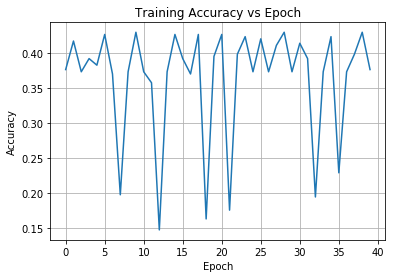

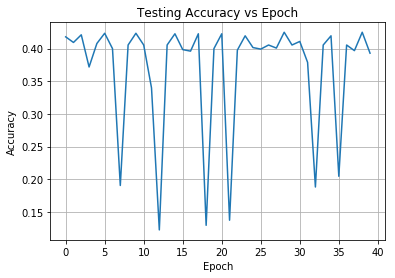

max test 0.425
max train @ max test 0.42946708
Hidden Units:  128
Momentum:  0.2
Epoch: 0001 cost=2800.967773438
Epoch: 0002 cost=4474.749593099
Epoch: 0003 cost=4740.437744141
Epoch: 0004 cost=2428.884724935
Epoch: 0005 cost=2864.537516276
Epoch: 0006 cost=4701.924967448
Epoch: 0007 cost=2907.876302083
Epoch: 0008 cost=4547.680175781
Epoch: 0009 cost=3589.909016927
Epoch: 0010 cost=4101.494140625
Epoch: 0011 cost=3171.140421549
Epoch: 0012 cost=2933.784423828
Epoch: 0013 cost=3285.739746094
Epoch: 0014 cost=2131.866536458
Epoch: 0015 cost=2644.627644857
Epoch: 0016 cost=2467.769938151
Epoch: 0017 cost=3394.724446615
Epoch: 0018 cost=3337.350423177
Epoch: 0019 cost=2213.982910156
Epoch: 0020 cost=2715.173828125
Epoch: 0021 cost=2618.644612630
Epoch: 0022 cost=3014.758626302
Epoch: 0023 cost=2903.778238932
Epoch: 0024 cost=2789.542154948
Epoch: 0025 cost=2092.207112630
Epoch: 0026 cost=3411.312093099
Epoch: 0027 cost=2675.332804362
Epoch: 0028 cost=1959.627665202
Epoch: 0029 cost=1495.6

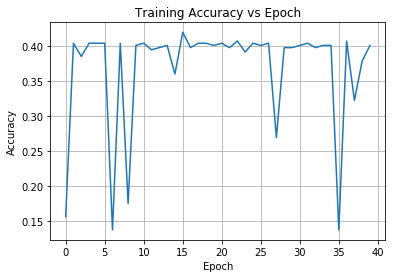

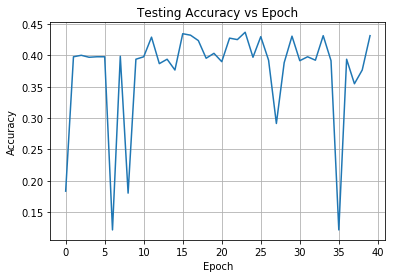

max test 0.43671876
max train @ max test 0.39184952
Hidden Units:  128
Momentum:  0.5
Epoch: 0001 cost=7826.012207031
Epoch: 0002 cost=3988.466389974
Epoch: 0003 cost=4810.944986979
Epoch: 0004 cost=4523.307942708
Epoch: 0005 cost=3541.967773438
Epoch: 0006 cost=2698.206502279
Epoch: 0007 cost=2436.366088867
Epoch: 0008 cost=1703.588745117
Epoch: 0009 cost=3815.929199219
Epoch: 0010 cost=4083.753255208
Epoch: 0011 cost=2202.610799154
Epoch: 0012 cost=2458.353149414
Epoch: 0013 cost=2777.151977539
Epoch: 0014 cost=1783.755126953
Epoch: 0015 cost=2742.017659505
Epoch: 0016 cost=2978.878092448
Epoch: 0017 cost=1885.877075195
Epoch: 0018 cost=3360.442545573
Epoch: 0019 cost=2579.227416992
Epoch: 0020 cost=2889.385579427
Epoch: 0021 cost=1625.654012044
Epoch: 0022 cost=2269.782796224
Epoch: 0023 cost=2357.607828776
Epoch: 0024 cost=1308.342407227
Epoch: 0025 cost=2243.974812826
Epoch: 0026 cost=1240.788635254
Epoch: 0027 cost=1164.310160319
Epoch: 0028 cost=1511.952270508
Epoch: 0029 cost=1

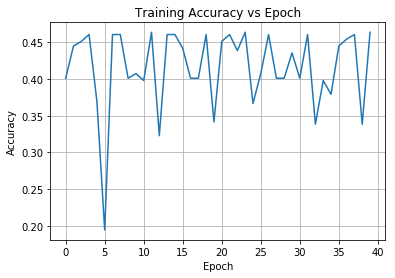

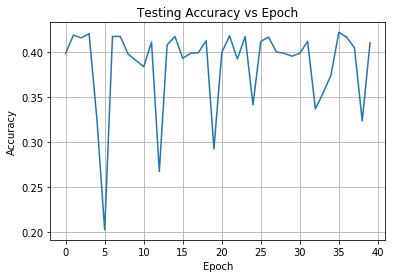

max test 0.421875
max train @ max test 0.44514108
Hidden Units:  128
Momentum:  0.9
Epoch: 0001 cost=4974.816731771
Epoch: 0002 cost=6056.497884115
Epoch: 0003 cost=7814.078287760
Epoch: 0004 cost=4635.428792318
Epoch: 0005 cost=3655.626220703
Epoch: 0006 cost=5270.985188802
Epoch: 0007 cost=2882.333333333
Epoch: 0008 cost=1722.267618815
Epoch: 0009 cost=1810.421997070
Epoch: 0010 cost=1569.973144531
Epoch: 0011 cost=1815.465332031
Epoch: 0012 cost=1513.536336263
Epoch: 0013 cost=1421.092081706
Epoch: 0014 cost=1174.610717773
Epoch: 0015 cost=1083.012471517
Epoch: 0016 cost=874.915018717
Epoch: 0017 cost=1160.529256185
Epoch: 0018 cost=860.258402507
Epoch: 0019 cost=720.261006673
Epoch: 0020 cost=566.170725505
Epoch: 0021 cost=411.780588786
Epoch: 0022 cost=238.648020426
Epoch: 0023 cost=344.197662354
Epoch: 0024 cost=271.064336141
Epoch: 0025 cost=327.507283529
Epoch: 0026 cost=416.943710327
Epoch: 0027 cost=556.570149740
Epoch: 0028 cost=716.291483561
Epoch: 0029 cost=569.484751383
E

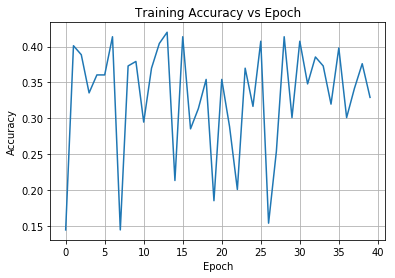

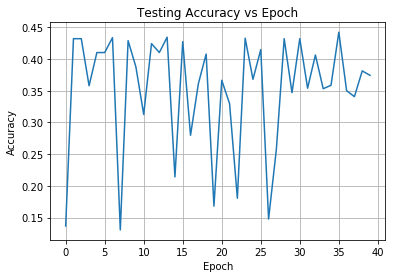

max test 0.4421875
max train @ max test 0.39811912


In [9]:
# do the rest with the different hyperparameters, this si for winequality
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j  in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("winequality-red.csv", ";", 0.8, 0.0001, 40, 100, i, 1, j, ac_list, True, False)

In [11]:
out = np.argmax(np.array(ac_list)) +1
#print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
#print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Maximum Test Accuracy:  0.4421875


Hidden Units:  1
Momentum:  0
Optimization Finished!
Accuracy: 0.0023923444


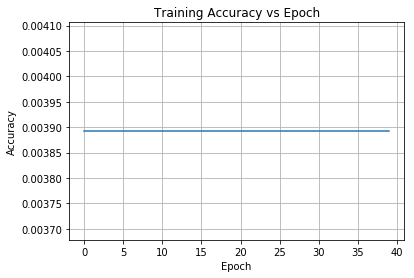

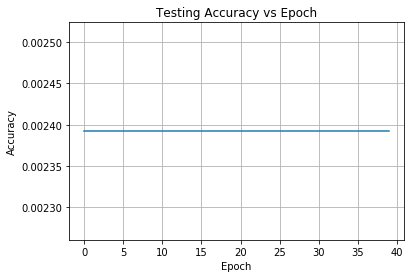

max test 0.0023923444
max train @ max test 0.0038922157
Hidden Units:  1
Momentum:  0.2
Optimization Finished!
Accuracy: 0.02631579


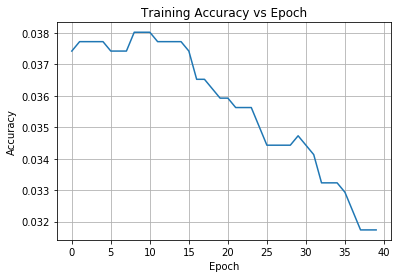

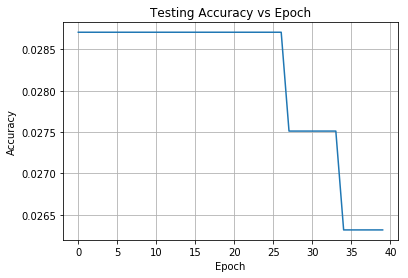

max test 0.028708134
max train @ max test 0.03742515
Hidden Units:  1
Momentum:  0.5
Optimization Finished!
Accuracy: 0.051435407


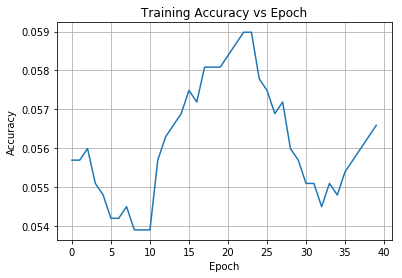

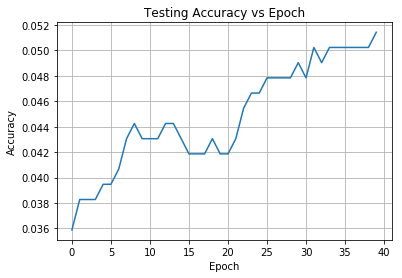

max test 0.051435407
max train @ max test 0.056586828
Hidden Units:  1
Momentum:  0.9
Optimization Finished!
Accuracy: 0.0


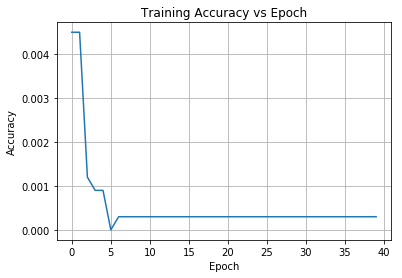

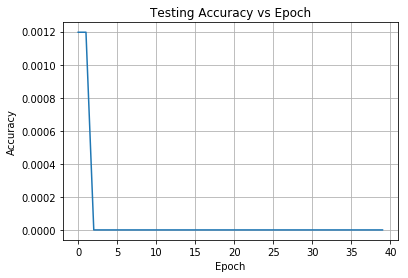

max test 0.0011961722
max train @ max test 0.004491018
Hidden Units:  2
Momentum:  0
Optimization Finished!
Accuracy: 0.02631579


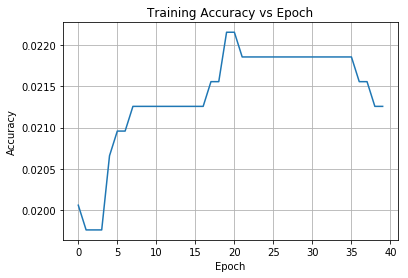

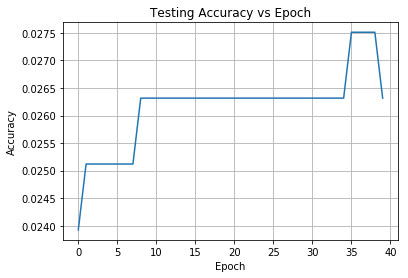

max test 0.027511962
max train @ max test 0.021856287
Hidden Units:  2
Momentum:  0.2
Optimization Finished!
Accuracy: 0.11244019


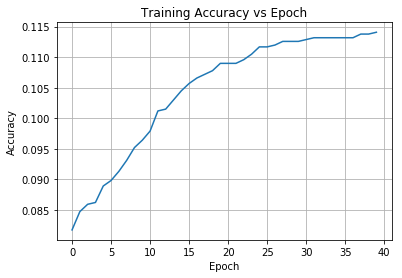

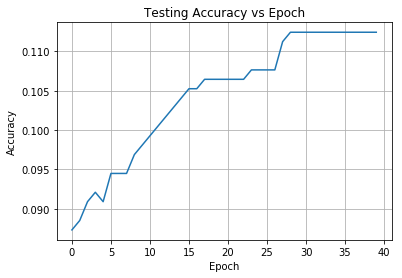

max test 0.11244019
max train @ max test 0.11257485
Hidden Units:  2
Momentum:  0.5
Optimization Finished!
Accuracy: 0.013157895


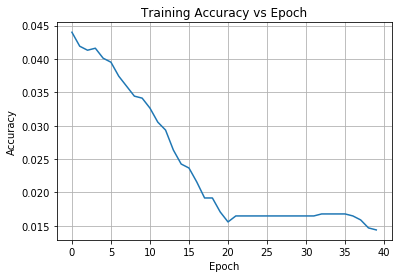

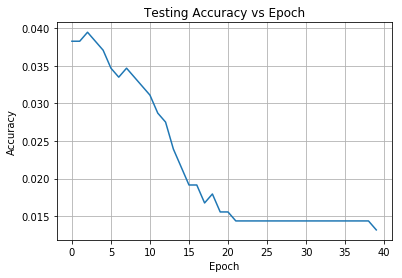

max test 0.039473683
max train @ max test 0.041317366
Hidden Units:  2
Momentum:  0.9
Optimization Finished!
Accuracy: 0.13636364


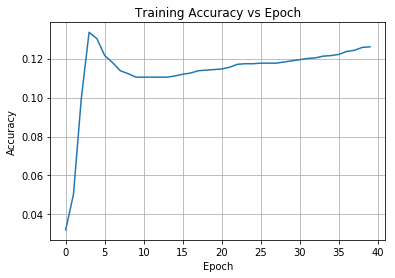

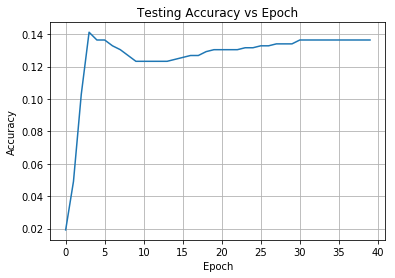

max test 0.14114833
max train @ max test 0.13353294
Hidden Units:  4
Momentum:  0
Optimization Finished!
Accuracy: 0.08014354


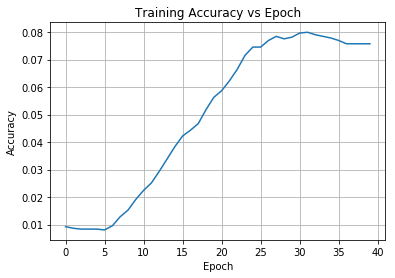

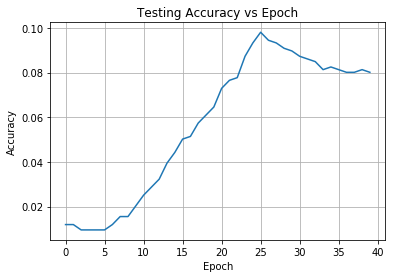

max test 0.098086126
max train @ max test 0.0745509
Hidden Units:  4
Momentum:  0.2
Optimization Finished!
Accuracy: 0.015550239


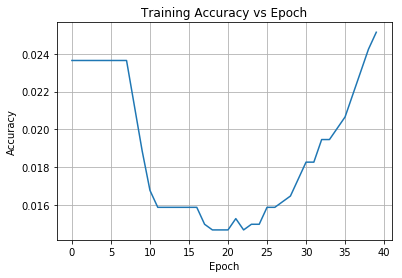

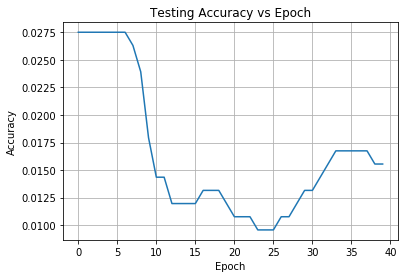

max test 0.027511962
max train @ max test 0.023652695
Hidden Units:  4
Momentum:  0.5
Optimization Finished!
Accuracy: 0.08492823


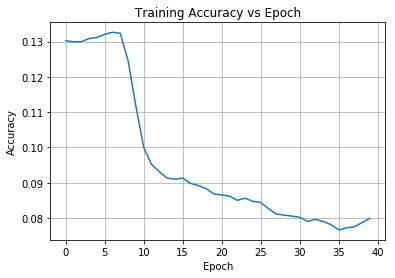

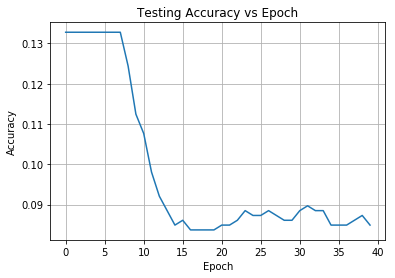

max test 0.13277511
max train @ max test 0.13023952
Hidden Units:  4
Momentum:  0.9
Optimization Finished!
Accuracy: 0.08492823


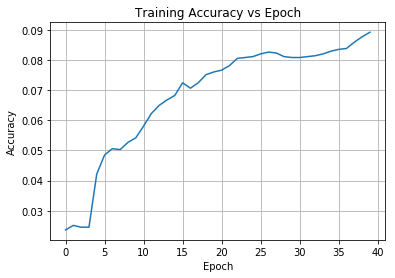

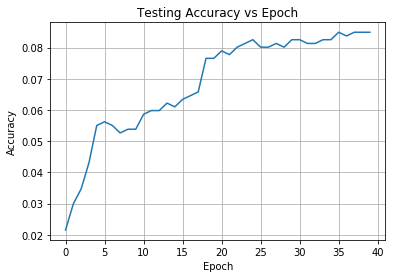

max test 0.08492823
max train @ max test 0.08353294
Hidden Units:  8
Momentum:  0
Optimization Finished!
Accuracy: 0.08373206


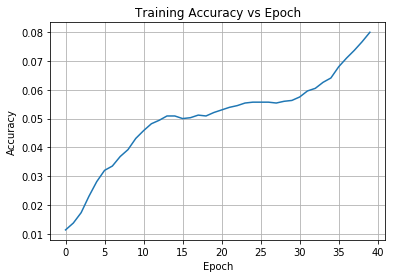

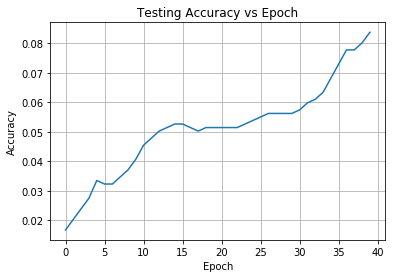

max test 0.08373206
max train @ max test 0.07994012
Hidden Units:  8
Momentum:  0.2
Optimization Finished!
Accuracy: 0.04784689


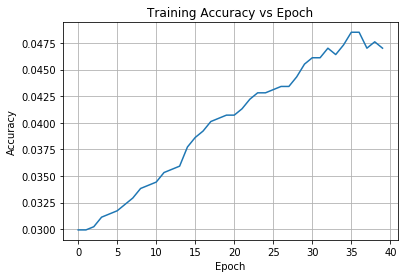

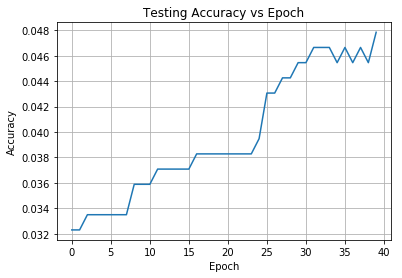

max test 0.04784689
max train @ max test 0.04700599
Hidden Units:  8
Momentum:  0.5
Optimization Finished!
Accuracy: 0.09330144


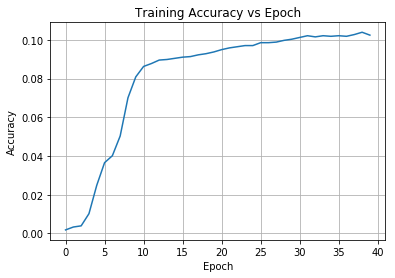

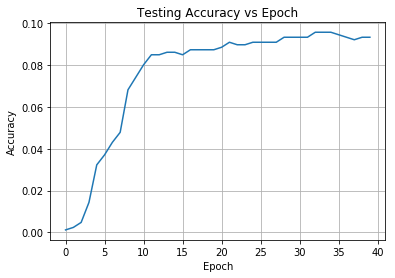

max test 0.09569378
max train @ max test 0.10149701
Hidden Units:  8
Momentum:  0.9
Optimization Finished!
Accuracy: 0.15789473


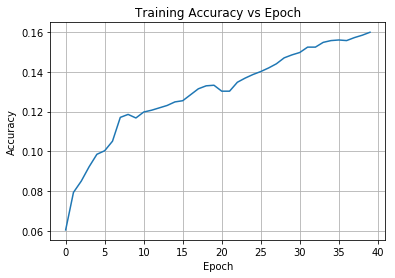

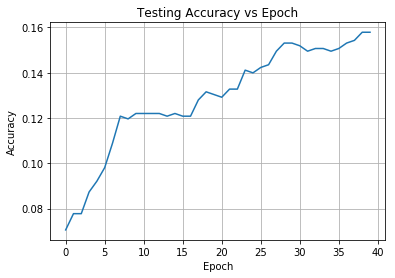

max test 0.15789473
max train @ max test 0.15838324
Hidden Units:  32
Momentum:  0
Optimization Finished!
Accuracy: 0.12200957


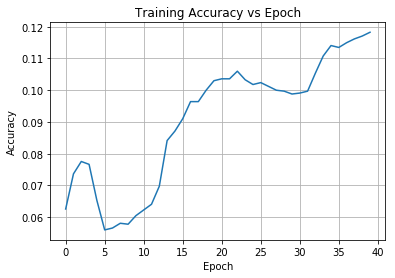

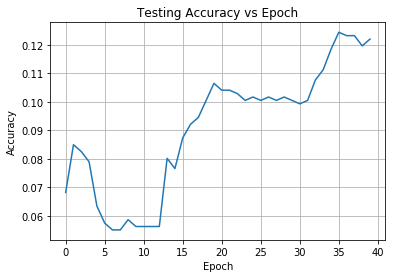

max test 0.12440191
max train @ max test 0.11347305
Hidden Units:  32
Momentum:  0.2
Optimization Finished!
Accuracy: 0.16626795


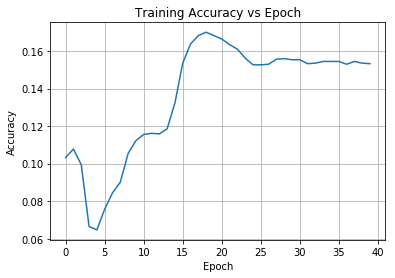

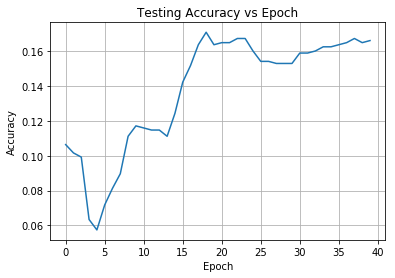

max test 0.17105263
max train @ max test 0.17005987
Hidden Units:  32
Momentum:  0.5
Optimization Finished!
Accuracy: 0.1555024


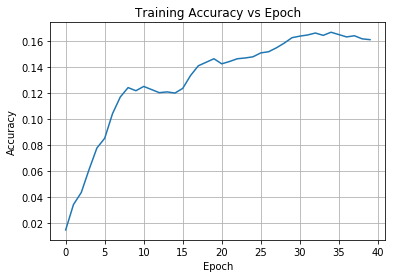

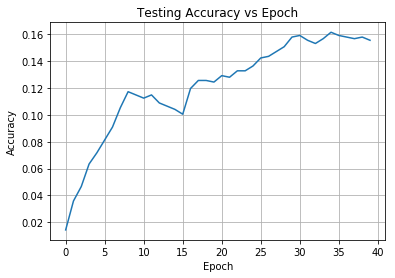

max test 0.16148326
max train @ max test 0.16676646
Hidden Units:  32
Momentum:  0.9
Optimization Finished!
Accuracy: 0.20574163


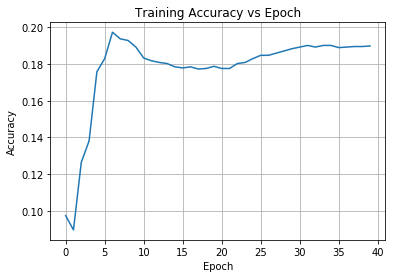

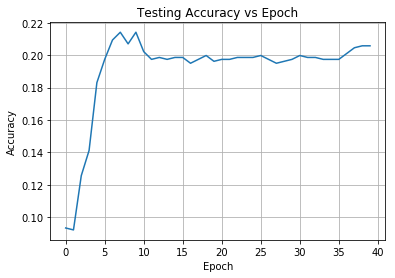

max test 0.21411483
max train @ max test 0.19371258
Hidden Units:  128
Momentum:  0
Optimization Finished!
Accuracy: 0.16985646


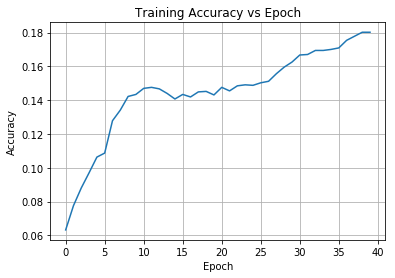

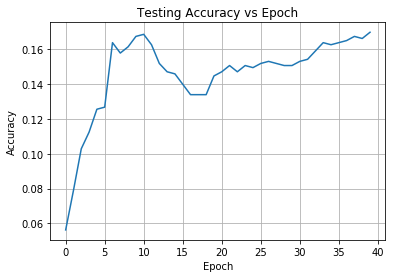

max test 0.16985646
max train @ max test 0.18023951
Hidden Units:  128
Momentum:  0.2
Optimization Finished!
Accuracy: 0.13157895


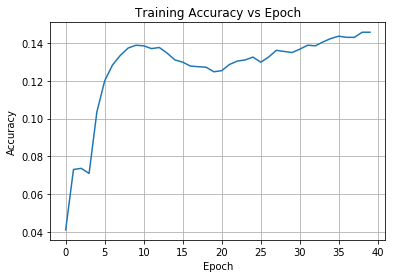

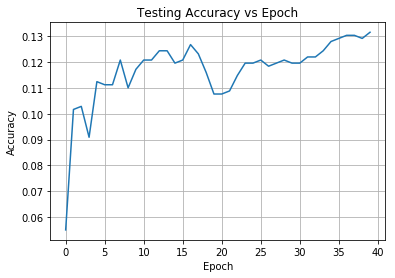

max test 0.13157895
max train @ max test 0.14580838
Hidden Units:  128
Momentum:  0.5
Optimization Finished!
Accuracy: 0.21052632


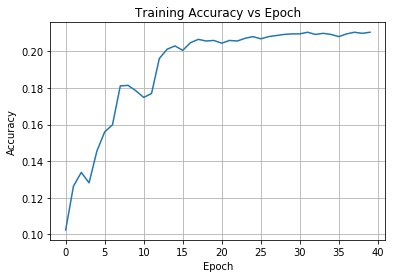

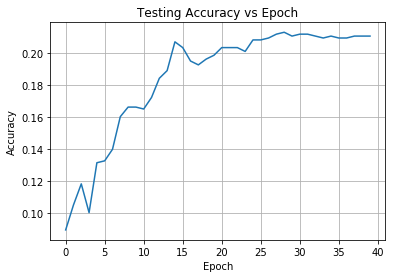

max test 0.21291865
max train @ max test 0.20928144
Hidden Units:  128
Momentum:  0.9
Optimization Finished!
Accuracy: 0.20574163


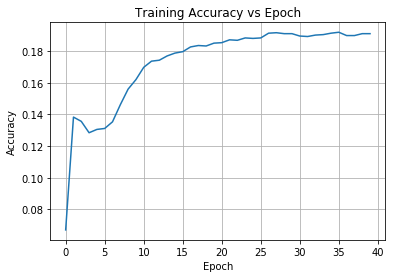

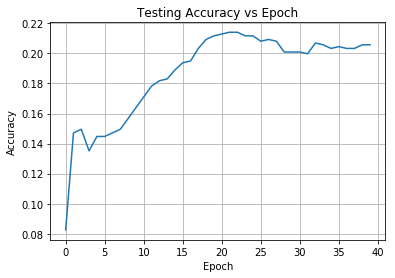

max test 0.21411483
max train @ max test 0.18712574


In [11]:
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("abalone.data", ",", 0.2, 0.0001, 40, 100, i, 1, j, ac_list, True, True)

In [12]:
out = np.argmax(np.array(ac_list)) +1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  128
Opt Momentum:  0.9
Maximum Test Accuracy:  0.21411483


Hidden Units:  1
Momentum:  0
Epoch: 0001 cost=5.325182176
Epoch: 0002 cost=5.312433815
Epoch: 0003 cost=5.299859214
Epoch: 0004 cost=5.287455130
Epoch: 0005 cost=5.275218320
Epoch: 0006 cost=5.263145161
Epoch: 0007 cost=5.251232076
Epoch: 0008 cost=5.239476347
Epoch: 0009 cost=5.227876067
Epoch: 0010 cost=5.216427374
Epoch: 0011 cost=5.205127382
Epoch: 0012 cost=5.193972993
Epoch: 0013 cost=5.182962251
Epoch: 0014 cost=5.172092128
Epoch: 0015 cost=5.161359167
Epoch: 0016 cost=5.150761509
Epoch: 0017 cost=5.140296698
Epoch: 0018 cost=5.129962397
Epoch: 0019 cost=5.119756150
Epoch: 0020 cost=5.109675694
Epoch: 0021 cost=5.099718738
Epoch: 0022 cost=5.089882827
Epoch: 0023 cost=5.080165911
Epoch: 0024 cost=5.070566010
Epoch: 0025 cost=5.061081481
Epoch: 0026 cost=5.051709366
Epoch: 0027 cost=5.042448115
Epoch: 0028 cost=5.033295536
Epoch: 0029 cost=5.024249840
Epoch: 0030 cost=5.015309596
Epoch: 0031 cost=5.006472254
Epoch: 0032 cost=4.997736907
Epoch: 0033 cost=4.989101648
Epoch: 0034 c

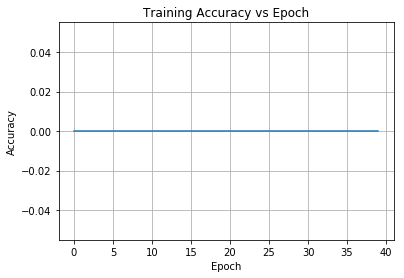

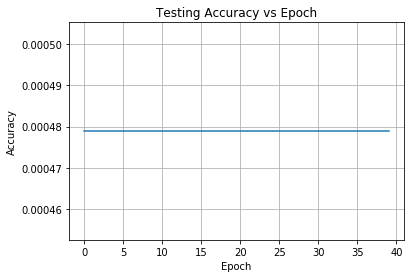

max test 0.0004789272
max train @ max test 0.0
Hidden Units:  1
Momentum:  0.2
Epoch: 0001 cost=4.365254283
Epoch: 0002 cost=4.343856478
Epoch: 0003 cost=4.323109674
Epoch: 0004 cost=4.303004742
Epoch: 0005 cost=4.283517337
Epoch: 0006 cost=4.264623690
Epoch: 0007 cost=4.246301579
Epoch: 0008 cost=4.228529739
Epoch: 0009 cost=4.211287856
Epoch: 0010 cost=4.194556332
Epoch: 0011 cost=4.178315830
Epoch: 0012 cost=4.162549233
Epoch: 0013 cost=4.147239685
Epoch: 0014 cost=4.132370520
Epoch: 0015 cost=4.117925930
Epoch: 0016 cost=4.103891301
Epoch: 0017 cost=4.090252137
Epoch: 0018 cost=4.076995277
Epoch: 0019 cost=4.064107347
Epoch: 0020 cost=4.051575637
Epoch: 0021 cost=4.039388108
Epoch: 0022 cost=4.027533317
Epoch: 0023 cost=4.016000128
Epoch: 0024 cost=4.004777873
Epoch: 0025 cost=3.993856430
Epoch: 0026 cost=3.983225656
Epoch: 0027 cost=3.972876215
Epoch: 0028 cost=3.962799215
Epoch: 0029 cost=3.952985871
Epoch: 0030 cost=3.943427527
Epoch: 0031 cost=3.934116447
Epoch: 0032 cost=3.925

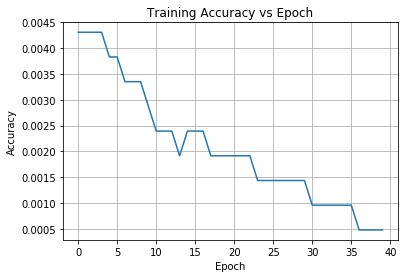

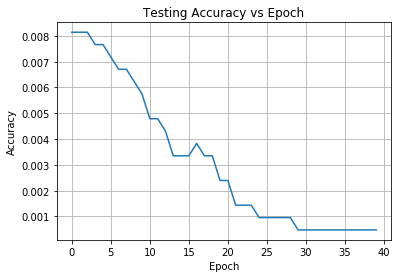

max test 0.008141763
max train @ max test 0.004310345
Hidden Units:  1
Momentum:  0.5
Epoch: 0001 cost=4.548947573
Epoch: 0002 cost=4.528545475
Epoch: 0003 cost=4.508861661
Epoch: 0004 cost=4.489972663
Epoch: 0005 cost=4.471847677
Epoch: 0006 cost=4.454457760
Epoch: 0007 cost=4.437774205
Epoch: 0008 cost=4.421769357
Epoch: 0009 cost=4.406416583
Epoch: 0010 cost=4.391689777
Epoch: 0011 cost=4.377563858
Epoch: 0012 cost=4.364015341
Epoch: 0013 cost=4.351020527
Epoch: 0014 cost=4.338556480
Epoch: 0015 cost=4.326601934
Epoch: 0016 cost=4.315135241
Epoch: 0017 cost=4.304136109
Epoch: 0018 cost=4.293584800
Epoch: 0019 cost=4.283462691
Epoch: 0020 cost=4.273751593
Epoch: 0021 cost=4.264433742
Epoch: 0022 cost=4.255492282
Epoch: 0023 cost=4.246910858
Epoch: 0024 cost=4.238673687
Epoch: 0025 cost=4.230766106
Epoch: 0026 cost=4.223173070
Epoch: 0027 cost=4.215881419
Epoch: 0028 cost=4.208876896
Epoch: 0029 cost=4.202146935
Epoch: 0030 cost=4.195679045
Epoch: 0031 cost=4.189461541
Epoch: 0032 cos

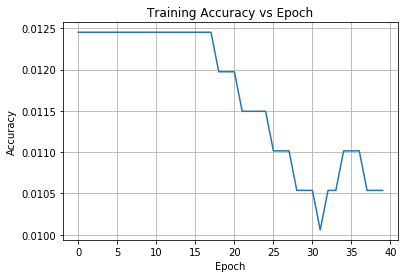

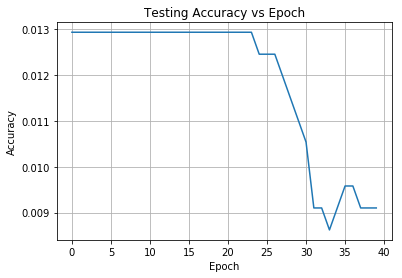

max test 0.012931035
max train @ max test 0.012452107
Hidden Units:  1
Momentum:  0.9
Epoch: 0001 cost=4.898302197
Epoch: 0002 cost=4.736095381
Epoch: 0003 cost=4.568030262
Epoch: 0004 cost=4.421606302
Epoch: 0005 cost=4.296126986
Epoch: 0006 cost=4.188318253
Epoch: 0007 cost=4.095264840
Epoch: 0008 cost=4.014600635
Epoch: 0009 cost=3.944410360
Epoch: 0010 cost=3.883130550
Epoch: 0011 cost=3.829472649
Epoch: 0012 cost=3.782364666
Epoch: 0013 cost=3.740908504
Epoch: 0014 cost=3.704345441
Epoch: 0015 cost=3.672031188
Epoch: 0016 cost=3.643415415
Epoch: 0017 cost=3.618026197
Epoch: 0018 cost=3.595456672
Epoch: 0019 cost=3.575354743
Epoch: 0020 cost=3.557415926
Epoch: 0021 cost=3.541374993
Epoch: 0022 cost=3.527001226
Epoch: 0023 cost=3.514092779
Epoch: 0024 cost=3.502473605
Epoch: 0025 cost=3.491989481
Epoch: 0026 cost=3.482505381
Epoch: 0027 cost=3.473902655
Epoch: 0028 cost=3.466077244
Epoch: 0029 cost=3.458937573
Epoch: 0030 cost=3.452403343
Epoch: 0031 cost=3.446403480
Epoch: 0032 cos

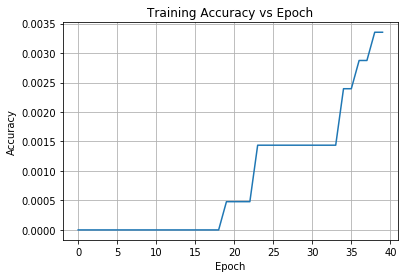

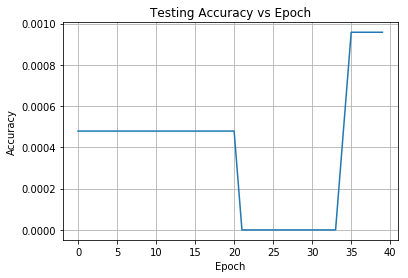

max test 0.0009578544
max train @ max test 0.002394636
Hidden Units:  2
Momentum:  0
Epoch: 0001 cost=8.709200716
Epoch: 0002 cost=8.622819567
Epoch: 0003 cost=8.539301538
Epoch: 0004 cost=8.458470297
Epoch: 0005 cost=8.380164051
Epoch: 0006 cost=8.304233551
Epoch: 0007 cost=8.230546045
Epoch: 0008 cost=8.158977985
Epoch: 0009 cost=8.089419651
Epoch: 0010 cost=8.021767497
Epoch: 0011 cost=7.955930591
Epoch: 0012 cost=7.891824317
Epoch: 0013 cost=7.829371548
Epoch: 0014 cost=7.768500137
Epoch: 0015 cost=7.709145212
Epoch: 0016 cost=7.651247311
Epoch: 0017 cost=7.594753528
Epoch: 0018 cost=7.539610386
Epoch: 0019 cost=7.485772705
Epoch: 0020 cost=7.433198118
Epoch: 0021 cost=7.381845999
Epoch: 0022 cost=7.331679988
Epoch: 0023 cost=7.282664227
Epoch: 0024 cost=7.234766960
Epoch: 0025 cost=7.187958312
Epoch: 0026 cost=7.142210841
Epoch: 0027 cost=7.097498274
Epoch: 0028 cost=7.053795934
Epoch: 0029 cost=7.011080456
Epoch: 0030 cost=6.969329977
Epoch: 0031 cost=6.928523755
Epoch: 0032 cost

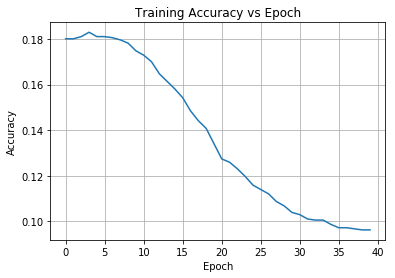

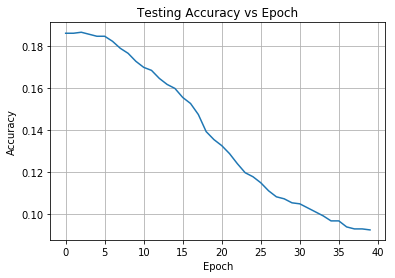

max test 0.18678162
max train @ max test 0.18103448
Hidden Units:  2
Momentum:  0.2
Epoch: 0001 cost=16.102540827
Epoch: 0002 cost=15.600365257
Epoch: 0003 cost=15.129996729
Epoch: 0004 cost=14.690424824
Epoch: 0005 cost=14.279671764
Epoch: 0006 cost=13.895387459
Epoch: 0007 cost=13.535042429
Epoch: 0008 cost=13.196114206
Epoch: 0009 cost=12.876218557
Epoch: 0010 cost=12.573190880
Epoch: 0011 cost=12.285130119
Epoch: 0012 cost=12.010397291
Epoch: 0013 cost=11.747596550
Epoch: 0014 cost=11.495545816
Epoch: 0015 cost=11.253244448
Epoch: 0016 cost=11.019844437
Epoch: 0017 cost=10.794628572
Epoch: 0018 cost=10.576979256
Epoch: 0019 cost=10.366365242
Epoch: 0020 cost=10.162325239
Epoch: 0021 cost=9.964457464
Epoch: 0022 cost=9.772406340
Epoch: 0023 cost=9.585859823
Epoch: 0024 cost=9.404536867
Epoch: 0025 cost=9.228188658
Epoch: 0026 cost=9.056590080
Epoch: 0027 cost=8.889539146
Epoch: 0028 cost=8.726851749
Epoch: 0029 cost=8.568361807
Epoch: 0030 cost=8.413915968
Epoch: 0031 cost=8.2633823

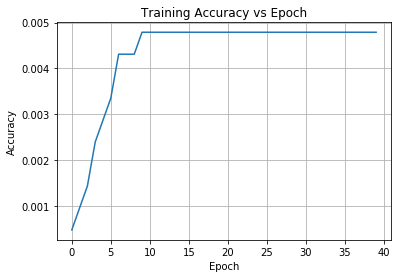

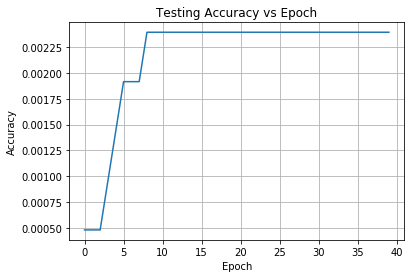

max test 0.002394636
max train @ max test 0.004310345
Hidden Units:  2
Momentum:  0.5
Epoch: 0001 cost=9.872736931
Epoch: 0002 cost=9.652974176
Epoch: 0003 cost=9.441141987
Epoch: 0004 cost=9.237944031
Epoch: 0005 cost=9.042969465
Epoch: 0006 cost=8.855837107
Epoch: 0007 cost=8.676195908
Epoch: 0008 cost=8.503717518
Epoch: 0009 cost=8.338093090
Epoch: 0010 cost=8.179033566
Epoch: 0011 cost=8.026264930
Epoch: 0012 cost=7.879529142
Epoch: 0013 cost=7.738580942
Epoch: 0014 cost=7.603186154
Epoch: 0015 cost=7.473122597
Epoch: 0016 cost=7.348178053
Epoch: 0017 cost=7.228150082
Epoch: 0018 cost=7.112844896
Epoch: 0019 cost=7.002075148
Epoch: 0020 cost=6.895662451
Epoch: 0021 cost=6.793434787
Epoch: 0022 cost=6.695226622
Epoch: 0023 cost=6.600879288
Epoch: 0024 cost=6.510238218
Epoch: 0025 cost=6.423155141
Epoch: 0026 cost=6.339486074
Epoch: 0027 cost=6.259091783
Epoch: 0028 cost=6.181838894
Epoch: 0029 cost=6.107596850
Epoch: 0030 cost=6.036240673
Epoch: 0031 cost=5.967647815
Epoch: 0032 cos

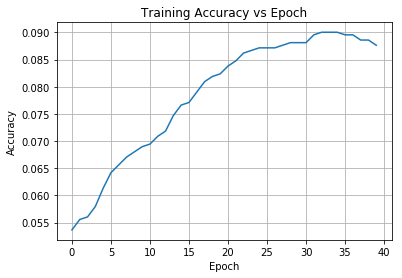

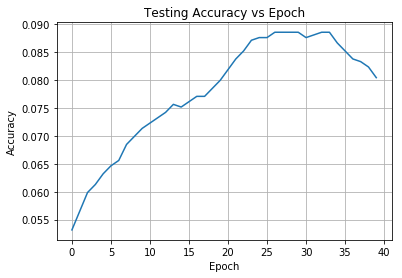

max test 0.08860153
max train @ max test 0.08716475
Hidden Units:  2
Momentum:  0.9
Epoch: 0001 cost=5.624670959
Epoch: 0002 cost=5.462938094
Epoch: 0003 cost=5.289068222
Epoch: 0004 cost=5.130843973
Epoch: 0005 cost=4.989193511
Epoch: 0006 cost=4.862214708
Epoch: 0007 cost=4.748036623
Epoch: 0008 cost=4.645088220
Epoch: 0009 cost=4.552069831
Epoch: 0010 cost=4.467897415
Epoch: 0011 cost=4.391652250
Epoch: 0012 cost=4.322541022
Epoch: 0013 cost=4.259863639
Epoch: 0014 cost=4.202989984
Epoch: 0015 cost=4.151341987
Epoch: 0016 cost=4.104385710
Epoch: 0017 cost=4.061625838
Epoch: 0018 cost=4.022604775
Epoch: 0019 cost=3.986903131
Epoch: 0020 cost=3.954139936
Epoch: 0021 cost=3.923973167
Epoch: 0022 cost=3.896098495
Epoch: 0023 cost=3.870248854
Epoch: 0024 cost=3.846189988
Epoch: 0025 cost=3.823718894
Epoch: 0026 cost=3.802659726
Epoch: 0027 cost=3.782860756
Epoch: 0028 cost=3.764191043
Epoch: 0029 cost=3.746537304
Epoch: 0030 cost=3.729801917
Epoch: 0031 cost=3.713899767
Epoch: 0032 cost=

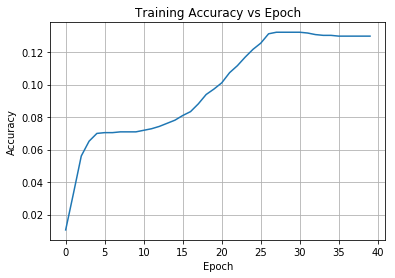

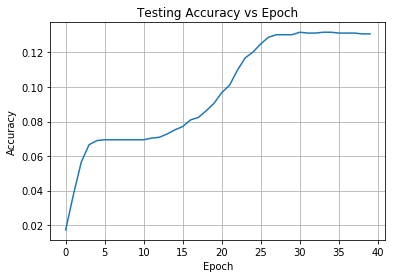

max test 0.13170499
max train @ max test 0.13218391
Hidden Units:  4
Momentum:  0
Epoch: 0001 cost=6.535467315
Epoch: 0002 cost=6.506900477
Epoch: 0003 cost=6.479045963
Epoch: 0004 cost=6.451883292
Epoch: 0005 cost=6.425392723
Epoch: 0006 cost=6.399554110
Epoch: 0007 cost=6.374348140
Epoch: 0008 cost=6.349755549
Epoch: 0009 cost=6.325756574
Epoch: 0010 cost=6.302334094
Epoch: 0011 cost=6.279470420
Epoch: 0012 cost=6.257145429
Epoch: 0013 cost=6.235341978
Epoch: 0014 cost=6.214044333
Epoch: 0015 cost=6.193236327
Epoch: 0016 cost=6.172901797
Epoch: 0017 cost=6.153024387
Epoch: 0018 cost=6.133590007
Epoch: 0019 cost=6.114582872
Epoch: 0020 cost=6.095990229
Epoch: 0021 cost=6.077797174
Epoch: 0022 cost=6.059990740
Epoch: 0023 cost=6.042557669
Epoch: 0024 cost=6.025485802
Epoch: 0025 cost=6.008763075
Epoch: 0026 cost=5.992378378
Epoch: 0027 cost=5.976319623
Epoch: 0028 cost=5.960577250
Epoch: 0029 cost=5.945140171
Epoch: 0030 cost=5.929999948
Epoch: 0031 cost=5.915146899
Epoch: 0032 cost=5.

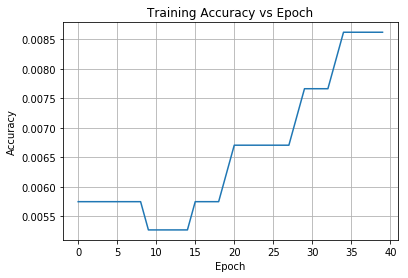

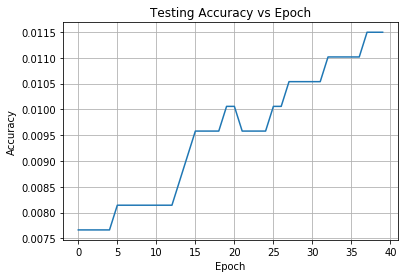

max test 0.011494253
max train @ max test 0.00862069
Hidden Units:  4
Momentum:  0.2
Epoch: 0001 cost=10.838504076
Epoch: 0002 cost=10.606521559
Epoch: 0003 cost=10.393527794
Epoch: 0004 cost=10.196829224
Epoch: 0005 cost=10.013739681
Epoch: 0006 cost=9.841944933
Epoch: 0007 cost=9.679561663
Epoch: 0008 cost=9.525119209
Epoch: 0009 cost=9.377501965
Epoch: 0010 cost=9.235885859
Epoch: 0011 cost=9.099675417
Epoch: 0012 cost=8.968455744
Epoch: 0013 cost=8.841949320
Epoch: 0014 cost=8.719981527
Epoch: 0015 cost=8.602456093
Epoch: 0016 cost=8.489330387
Epoch: 0017 cost=8.380595684
Epoch: 0018 cost=8.276256800
Epoch: 0019 cost=8.176313734
Epoch: 0020 cost=8.080746078
Epoch: 0021 cost=7.989502430
Epoch: 0022 cost=7.902490854
Epoch: 0023 cost=7.819576359
Epoch: 0024 cost=7.740578198
Epoch: 0025 cost=7.665279388
Epoch: 0026 cost=7.593433976
Epoch: 0027 cost=7.524779940
Epoch: 0028 cost=7.459048772
Epoch: 0029 cost=7.395976901
Epoch: 0030 cost=7.335312486
Epoch: 0031 cost=7.276821804
Epoch: 0032

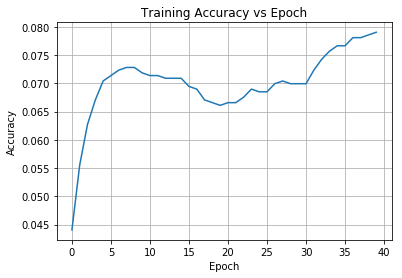

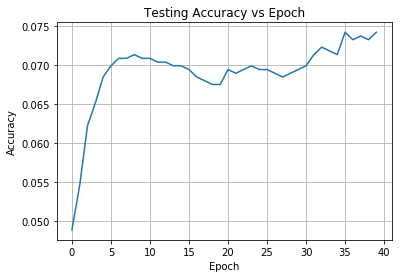

max test 0.07423372
max train @ max test 0.07662835
Hidden Units:  4
Momentum:  0.5
Epoch: 0001 cost=8.817111731
Epoch: 0002 cost=8.647673368
Epoch: 0003 cost=8.488805580
Epoch: 0004 cost=8.340120363
Epoch: 0005 cost=8.200463438
Epoch: 0006 cost=8.068831110
Epoch: 0007 cost=7.944358444
Epoch: 0008 cost=7.826304197
Epoch: 0009 cost=7.714034224
Epoch: 0010 cost=7.607003641
Epoch: 0011 cost=7.504747868
Epoch: 0012 cost=7.406866097
Epoch: 0013 cost=7.313013005
Epoch: 0014 cost=7.222887659
Epoch: 0015 cost=7.136227560
Epoch: 0016 cost=7.052800894
Epoch: 0017 cost=6.972403359
Epoch: 0018 cost=6.894852614
Epoch: 0019 cost=6.819984317
Epoch: 0020 cost=6.747650886
Epoch: 0021 cost=6.677717638
Epoch: 0022 cost=6.610062575
Epoch: 0023 cost=6.544572091
Epoch: 0024 cost=6.481141996
Epoch: 0025 cost=6.419675541
Epoch: 0026 cost=6.360082793
Epoch: 0027 cost=6.302279544
Epoch: 0028 cost=6.246186328
Epoch: 0029 cost=6.191728711
Epoch: 0030 cost=6.138837147
Epoch: 0031 cost=6.087445188
Epoch: 0032 cost=

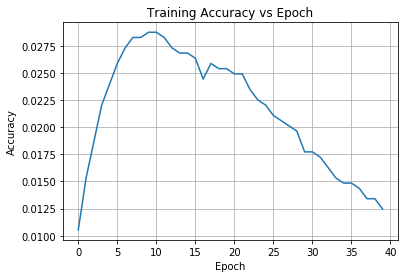

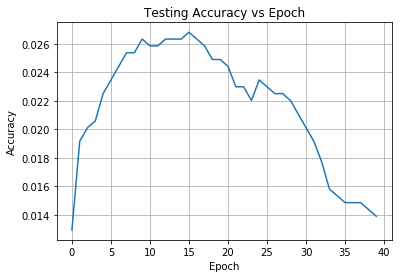

max test 0.026819924
max train @ max test 0.026340997
Hidden Units:  4
Momentum:  0.9
Epoch: 0001 cost=9.997968197
Epoch: 0002 cost=8.708593607
Epoch: 0003 cost=7.570327711
Epoch: 0004 cost=6.788114643
Epoch: 0005 cost=6.258276486
Epoch: 0006 cost=5.873487496
Epoch: 0007 cost=5.577932048
Epoch: 0008 cost=5.347524476
Epoch: 0009 cost=5.169473934
Epoch: 0010 cost=5.033352256
Epoch: 0011 cost=4.929030490
Epoch: 0012 cost=4.847479248
Epoch: 0013 cost=4.781710768
Epoch: 0014 cost=4.726857138
Epoch: 0015 cost=4.679698157
Epoch: 0016 cost=4.638122463
Epoch: 0017 cost=4.600725603
Epoch: 0018 cost=4.566554189
Epoch: 0019 cost=4.534945464
Epoch: 0020 cost=4.505428576
Epoch: 0021 cost=4.477661371
Epoch: 0022 cost=4.451388431
Epoch: 0023 cost=4.426415944
Epoch: 0024 cost=4.402592635
Epoch: 0025 cost=4.379798031
Epoch: 0026 cost=4.357934475
Epoch: 0027 cost=4.336920190
Epoch: 0028 cost=4.316686726
Epoch: 0029 cost=4.297174525
Epoch: 0030 cost=4.278332257
Epoch: 0031 cost=4.260114241
Epoch: 0032 cos

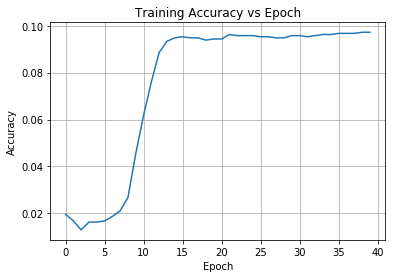

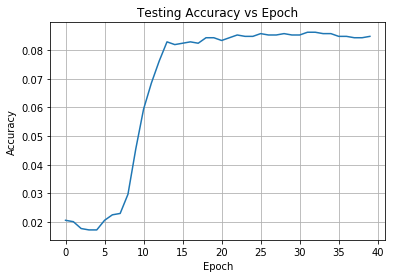

max test 0.0862069
max train @ max test 0.095306516
Hidden Units:  8
Momentum:  0
Epoch: 0001 cost=25.158678150
Epoch: 0002 cost=24.233380985
Epoch: 0003 cost=23.412807274
Epoch: 0004 cost=22.688041401
Epoch: 0005 cost=22.050256062
Epoch: 0006 cost=21.488794422
Epoch: 0007 cost=20.992093658
Epoch: 0008 cost=20.549557590
Epoch: 0009 cost=20.151834679
Epoch: 0010 cost=19.790040112
Epoch: 0011 cost=19.455611229
Epoch: 0012 cost=19.141125774
Epoch: 0013 cost=18.841052818
Epoch: 0014 cost=18.551739502
Epoch: 0015 cost=18.270944118
Epoch: 0016 cost=17.997337055
Epoch: 0017 cost=17.730128574
Epoch: 0018 cost=17.468842983
Epoch: 0019 cost=17.213173485
Epoch: 0020 cost=16.962906551
Epoch: 0021 cost=16.717893124
Epoch: 0022 cost=16.478026962
Epoch: 0023 cost=16.243234634
Epoch: 0024 cost=16.013474607
Epoch: 0025 cost=15.788732195
Epoch: 0026 cost=15.569012976
Epoch: 0027 cost=15.354337358
Epoch: 0028 cost=15.144732618
Epoch: 0029 cost=14.940227938
Epoch: 0030 cost=14.740851498
Epoch: 0031 cost=1

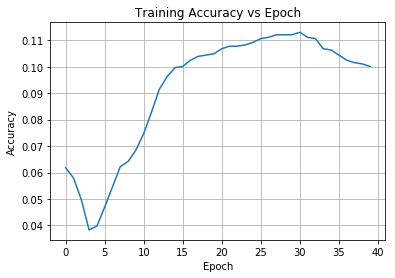

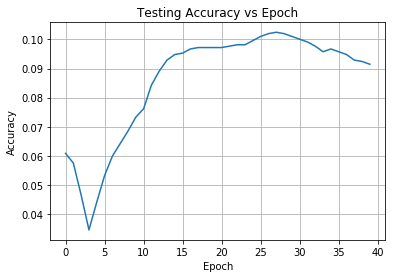

max test 0.102490425
max train @ max test 0.112068966
Hidden Units:  8
Momentum:  0.2
Epoch: 0001 cost=23.162507820
Epoch: 0002 cost=22.312446213
Epoch: 0003 cost=21.476945019
Epoch: 0004 cost=20.655144787
Epoch: 0005 cost=19.846700287
Epoch: 0006 cost=19.052393150
Epoch: 0007 cost=18.274066353
Epoch: 0008 cost=17.513780689
Epoch: 0009 cost=16.773093224
Epoch: 0010 cost=16.054618645
Epoch: 0011 cost=15.364957714
Epoch: 0012 cost=14.715770340
Epoch: 0013 cost=14.121535015
Epoch: 0014 cost=13.593358421
Epoch: 0015 cost=13.132794952
Epoch: 0016 cost=12.732578611
Epoch: 0017 cost=12.382338619
Epoch: 0018 cost=12.073017693
Epoch: 0019 cost=11.798058558
Epoch: 0020 cost=11.552786303
Epoch: 0021 cost=11.333467531
Epoch: 0022 cost=11.136664772
Epoch: 0023 cost=10.959007835
Epoch: 0024 cost=10.797255087
Epoch: 0025 cost=10.648447704
Epoch: 0026 cost=10.510055780
Epoch: 0027 cost=10.380026007
Epoch: 0028 cost=10.256763411
Epoch: 0029 cost=10.139056396
Epoch: 0030 cost=10.026000214
Epoch: 0031 co

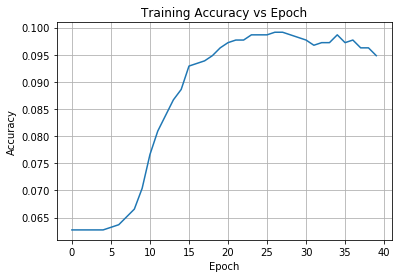

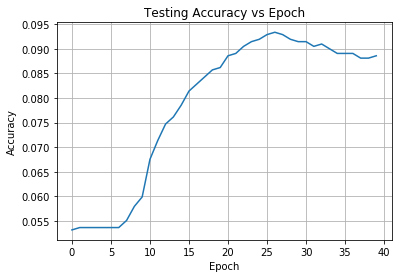

max test 0.09339081
max train @ max test 0.09913793
Hidden Units:  8
Momentum:  0.5
Epoch: 0001 cost=36.732357407
Epoch: 0002 cost=32.850444698
Epoch: 0003 cost=29.198734760
Epoch: 0004 cost=25.776207352
Epoch: 0005 cost=22.652979660
Epoch: 0006 cost=19.922280884
Epoch: 0007 cost=17.704993343
Epoch: 0008 cost=16.023171616
Epoch: 0009 cost=14.863136530
Epoch: 0010 cost=14.058900881
Epoch: 0011 cost=13.455312443
Epoch: 0012 cost=12.970987463
Epoch: 0013 cost=12.562371588
Epoch: 0014 cost=12.204144716
Epoch: 0015 cost=11.881214046
Epoch: 0016 cost=11.584481621
Epoch: 0017 cost=11.308351088
Epoch: 0018 cost=11.049290991
Epoch: 0019 cost=10.804992628
Epoch: 0020 cost=10.573859501
Epoch: 0021 cost=10.354680443
Epoch: 0022 cost=10.146423769
Epoch: 0023 cost=9.948121119
Epoch: 0024 cost=9.758817625
Epoch: 0025 cost=9.577580547
Epoch: 0026 cost=9.403516054
Epoch: 0027 cost=9.235805511
Epoch: 0028 cost=9.073720932
Epoch: 0029 cost=8.916639614
Epoch: 0030 cost=8.764041853
Epoch: 0031 cost=8.61550

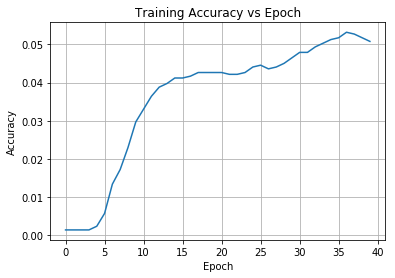

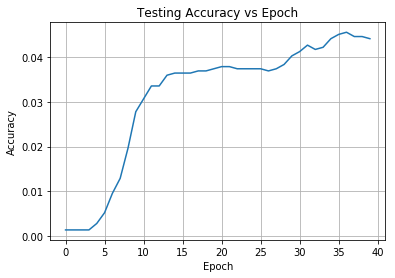

max test 0.045498084
max train @ max test 0.05316092
Hidden Units:  8
Momentum:  0.9
Epoch: 0001 cost=28.526412296
Epoch: 0002 cost=22.201299095
Epoch: 0003 cost=16.601405334
Epoch: 0004 cost=13.589826870
Epoch: 0005 cost=12.203128338
Epoch: 0006 cost=11.121413946
Epoch: 0007 cost=10.222228193
Epoch: 0008 cost=9.503864956
Epoch: 0009 cost=8.934286547
Epoch: 0010 cost=8.466589689
Epoch: 0011 cost=8.066217589
Epoch: 0012 cost=7.713868475
Epoch: 0013 cost=7.399022937
Epoch: 0014 cost=7.115421128
Epoch: 0015 cost=6.858806133
Epoch: 0016 cost=6.626008964
Epoch: 0017 cost=6.414609838
Epoch: 0018 cost=6.222685218
Epoch: 0019 cost=6.048485661
Epoch: 0020 cost=5.890131140
Epoch: 0021 cost=5.745524645
Epoch: 0022 cost=5.612538767
Epoch: 0023 cost=5.489296770
Epoch: 0024 cost=5.374324584
Epoch: 0025 cost=5.266538668
Epoch: 0026 cost=5.165150595
Epoch: 0027 cost=5.069562149
Epoch: 0028 cost=4.979290152
Epoch: 0029 cost=4.893918395
Epoch: 0030 cost=4.813071609
Epoch: 0031 cost=4.736403251
Epoch: 00

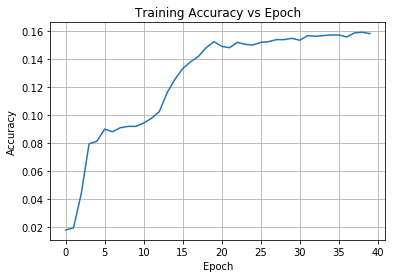

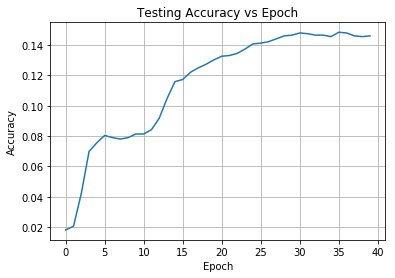

max test 0.14846744
max train @ max test 0.15708812
Hidden Units:  32
Momentum:  0
Epoch: 0001 cost=156.567308044
Epoch: 0002 cost=147.051603699
Epoch: 0003 cost=138.617565918
Epoch: 0004 cost=130.913994217
Epoch: 0005 cost=123.566608047
Epoch: 0006 cost=116.869505692
Epoch: 0007 cost=111.393104935
Epoch: 0008 cost=106.724065018
Epoch: 0009 cost=102.456411743
Epoch: 0010 cost=98.427510071
Epoch: 0011 cost=94.571550751
Epoch: 0012 cost=90.843981934
Epoch: 0013 cost=87.208263397
Epoch: 0014 cost=83.643602371
Epoch: 0015 cost=80.138197708
Epoch: 0016 cost=76.685085297
Epoch: 0017 cost=73.286012650
Epoch: 0018 cost=69.955966949
Epoch: 0019 cost=66.723136139
Epoch: 0020 cost=63.715071678
Epoch: 0021 cost=61.144955826
Epoch: 0022 cost=58.985034943
Epoch: 0023 cost=57.057260513
Epoch: 0024 cost=55.238922119
Epoch: 0025 cost=53.482909775
Epoch: 0026 cost=51.772334671
Epoch: 0027 cost=50.101055145
Epoch: 0028 cost=48.466802406
Epoch: 0029 cost=46.871381187
Epoch: 0030 cost=45.334501266
Epoch: 0

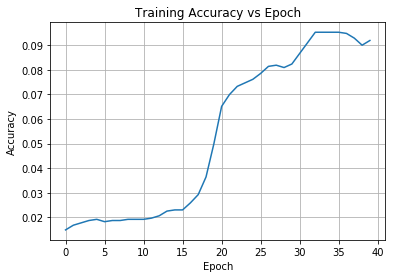

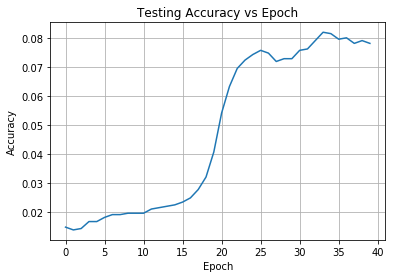

max test 0.08189655
max train @ max test 0.095306516
Hidden Units:  32
Momentum:  0.2
Epoch: 0001 cost=137.598458099
Epoch: 0002 cost=127.318488312
Epoch: 0003 cost=117.873122406
Epoch: 0004 cost=108.973517609
Epoch: 0005 cost=100.364295197
Epoch: 0006 cost=92.044483566
Epoch: 0007 cost=84.012791061
Epoch: 0008 cost=77.008291626
Epoch: 0009 cost=71.538811493
Epoch: 0010 cost=67.472573471
Epoch: 0011 cost=64.511035347
Epoch: 0012 cost=61.873751450
Epoch: 0013 cost=59.401999664
Epoch: 0014 cost=57.026120186
Epoch: 0015 cost=54.719809723
Epoch: 0016 cost=52.472468758
Epoch: 0017 cost=50.276532555
Epoch: 0018 cost=48.125558853
Epoch: 0019 cost=46.013910103
Epoch: 0020 cost=43.938199997
Epoch: 0021 cost=41.904837608
Epoch: 0022 cost=39.980412865
Epoch: 0023 cost=38.395788002
Epoch: 0024 cost=37.160967064
Epoch: 0025 cost=36.091901207
Epoch: 0026 cost=35.098785019
Epoch: 0027 cost=34.144471931
Epoch: 0028 cost=33.213045692
Epoch: 0029 cost=32.297166538
Epoch: 0030 cost=31.393623066
Epoch: 00

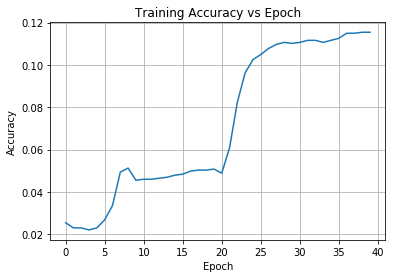

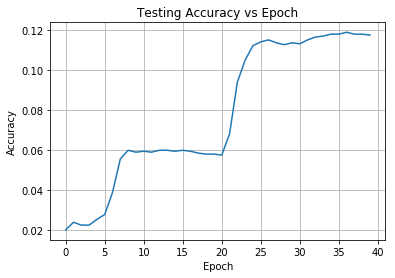

max test 0.118773945
max train @ max test 0.11494253
Hidden Units:  32
Momentum:  0.5
Epoch: 0001 cost=158.797734833
Epoch: 0002 cost=132.788657379
Epoch: 0003 cost=112.176895523
Epoch: 0004 cost=95.803524780
Epoch: 0005 cost=84.978406143
Epoch: 0006 cost=76.040320969
Epoch: 0007 cost=67.604686928
Epoch: 0008 cost=59.478600502
Epoch: 0009 cost=51.612580872
Epoch: 0010 cost=44.542102051
Epoch: 0011 cost=40.052822495
Epoch: 0012 cost=36.989709854
Epoch: 0013 cost=34.349439621
Epoch: 0014 cost=31.944662380
Epoch: 0015 cost=29.753209782
Epoch: 0016 cost=27.788937759
Epoch: 0017 cost=26.008039284
Epoch: 0018 cost=24.318261909
Epoch: 0019 cost=22.675324059
Epoch: 0020 cost=21.102948570
Epoch: 0021 cost=19.757338047
Epoch: 0022 cost=18.562110710
Epoch: 0023 cost=17.458008003
Epoch: 0024 cost=16.489892292
Epoch: 0025 cost=15.722522545
Epoch: 0026 cost=15.126838160
Epoch: 0027 cost=14.640603256
Epoch: 0028 cost=14.214784718
Epoch: 0029 cost=13.826750708
Epoch: 0030 cost=13.466758966
Epoch: 0031

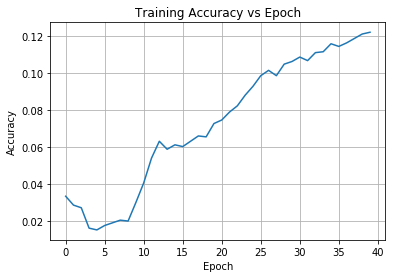

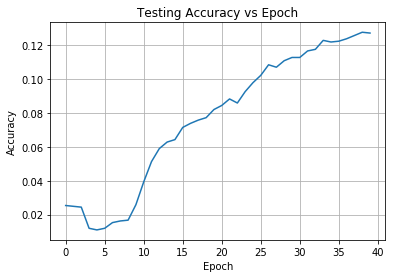

max test 0.12739463
max train @ max test 0.12116858
Hidden Units:  32
Momentum:  0.9
Epoch: 0001 cost=119.794360733
Epoch: 0002 cost=77.497029877
Epoch: 0003 cost=49.103251076
Epoch: 0004 cost=35.599556732
Epoch: 0005 cost=30.537311935
Epoch: 0006 cost=27.164741039
Epoch: 0007 cost=24.197755432
Epoch: 0008 cost=21.603636742
Epoch: 0009 cost=19.462244987
Epoch: 0010 cost=17.796737766
Epoch: 0011 cost=16.342718887
Epoch: 0012 cost=14.987228298
Epoch: 0013 cost=13.696213484
Epoch: 0014 cost=12.491205692
Epoch: 0015 cost=11.536537075
Epoch: 0016 cost=10.841128016
Epoch: 0017 cost=10.249357700
Epoch: 0018 cost=9.712115717
Epoch: 0019 cost=9.226389313
Epoch: 0020 cost=8.781270075
Epoch: 0021 cost=8.364948511
Epoch: 0022 cost=7.968318200
Epoch: 0023 cost=7.587977576
Epoch: 0024 cost=7.226411128
Epoch: 0025 cost=6.887553906
Epoch: 0026 cost=6.573172975
Epoch: 0027 cost=6.296728277
Epoch: 0028 cost=6.063498235
Epoch: 0029 cost=5.862499332
Epoch: 0030 cost=5.684772587
Epoch: 0031 cost=5.52554318

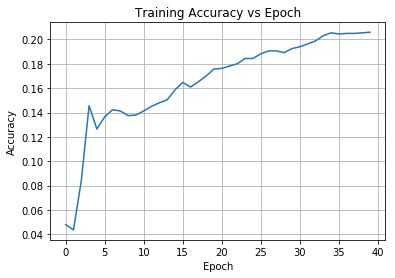

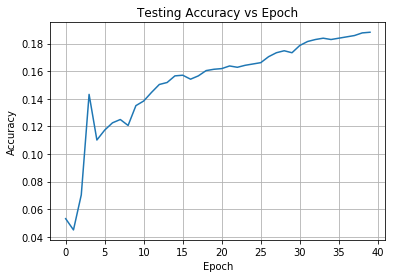

max test 0.18821838
max train @ max test 0.2059387
Hidden Units:  128
Momentum:  0
Epoch: 0001 cost=329.588760376
Epoch: 0002 cost=240.013758087
Epoch: 0003 cost=193.500789642
Epoch: 0004 cost=155.542704010
Epoch: 0005 cost=123.809669113
Epoch: 0006 cost=101.216722870
Epoch: 0007 cost=82.895652008
Epoch: 0008 cost=72.739019394
Epoch: 0009 cost=67.592025375
Epoch: 0010 cost=63.596271324
Epoch: 0011 cost=60.024135399
Epoch: 0012 cost=56.600796890
Epoch: 0013 cost=53.483303452
Epoch: 0014 cost=50.668560410
Epoch: 0015 cost=47.897537041
Epoch: 0016 cost=45.146008682
Epoch: 0017 cost=42.408196259
Epoch: 0018 cost=39.680942917
Epoch: 0019 cost=37.259825706
Epoch: 0020 cost=35.444481850
Epoch: 0021 cost=33.788464546
Epoch: 0022 cost=32.273268127
Epoch: 0023 cost=30.957718086
Epoch: 0024 cost=29.810822105
Epoch: 0025 cost=28.747477245
Epoch: 0026 cost=27.748494339
Epoch: 0027 cost=26.823501778
Epoch: 0028 cost=26.017766285
Epoch: 0029 cost=25.305178547
Epoch: 0030 cost=24.662737179
Epoch: 0031

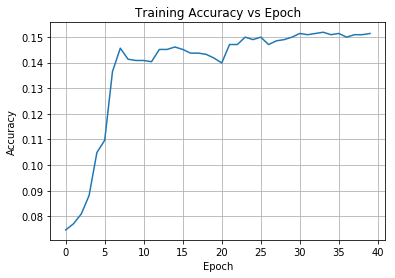

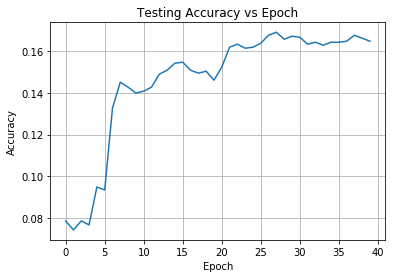

max test 0.1690613
max train @ max test 0.14846744
Hidden Units:  128
Momentum:  0.2
Epoch: 0001 cost=446.995440674
Epoch: 0002 cost=331.283984375
Epoch: 0003 cost=266.333956146
Epoch: 0004 cost=221.910740662
Epoch: 0005 cost=192.512008667
Epoch: 0006 cost=167.852669525
Epoch: 0007 cost=148.882727814
Epoch: 0008 cost=133.097669220
Epoch: 0009 cost=119.232004166
Epoch: 0010 cost=108.398007584
Epoch: 0011 cost=99.624552536
Epoch: 0012 cost=92.204607010
Epoch: 0013 cost=85.390603638
Epoch: 0014 cost=78.946581268
Epoch: 0015 cost=73.241421127
Epoch: 0016 cost=68.043500137
Epoch: 0017 cost=63.074090576
Epoch: 0018 cost=58.370863533
Epoch: 0019 cost=54.238495827
Epoch: 0020 cost=50.383175468
Epoch: 0021 cost=46.563862228
Epoch: 0022 cost=42.763729477
Epoch: 0023 cost=39.585086060
Epoch: 0024 cost=37.671004295
Epoch: 0025 cost=35.989840698
Epoch: 0026 cost=34.383863068
Epoch: 0027 cost=32.826960182
Epoch: 0028 cost=31.299613380
Epoch: 0029 cost=29.836632729
Epoch: 0030 cost=28.497518349
Epoch

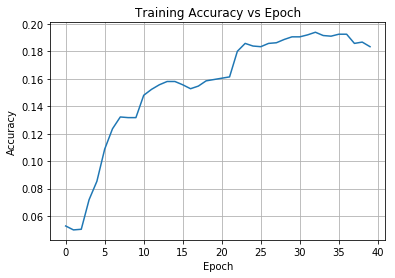

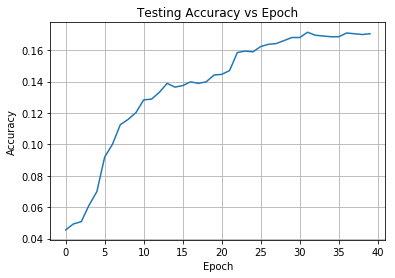

max test 0.17145593
max train @ max test 0.1920498
Hidden Units:  128
Momentum:  0.5
Epoch: 0001 cost=486.606956482
Epoch: 0002 cost=358.598603821
Epoch: 0003 cost=295.133154297
Epoch: 0004 cost=251.793303680
Epoch: 0005 cost=213.831683350
Epoch: 0006 cost=185.961130524
Epoch: 0007 cost=160.702674866
Epoch: 0008 cost=136.381732178
Epoch: 0009 cost=115.617379379
Epoch: 0010 cost=97.528911591
Epoch: 0011 cost=83.497562790
Epoch: 0012 cost=73.038138199
Epoch: 0013 cost=65.905300903
Epoch: 0014 cost=60.285346603
Epoch: 0015 cost=55.132524681
Epoch: 0016 cost=50.729998016
Epoch: 0017 cost=46.665778732
Epoch: 0018 cost=42.775960732
Epoch: 0019 cost=39.427592278
Epoch: 0020 cost=36.568405724
Epoch: 0021 cost=33.900848770
Epoch: 0022 cost=31.313828659
Epoch: 0023 cost=28.769263077
Epoch: 0024 cost=26.254557037
Epoch: 0025 cost=23.836339188
Epoch: 0026 cost=22.386217213
Epoch: 0027 cost=21.358236408
Epoch: 0028 cost=20.508361816
Epoch: 0029 cost=19.741465092
Epoch: 0030 cost=19.025101948
Epoch:

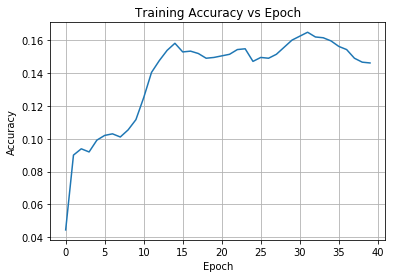

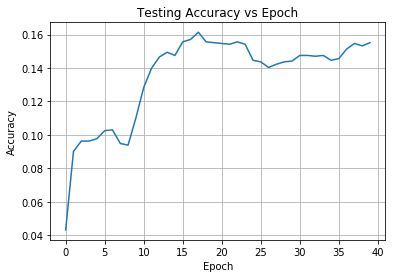

max test 0.16139847
max train @ max test 0.15181993
Hidden Units:  128
Momentum:  0.9
Epoch: 0001 cost=356.717439270
Epoch: 0002 cost=131.333131790
Epoch: 0003 cost=67.481949425
Epoch: 0004 cost=41.880656242
Epoch: 0005 cost=29.113161755
Epoch: 0006 cost=21.363187885
Epoch: 0007 cost=16.265545321
Epoch: 0008 cost=12.721237326
Epoch: 0009 cost=10.249209356
Epoch: 0010 cost=8.292677641
Epoch: 0011 cost=6.952842879
Epoch: 0012 cost=6.350109291
Epoch: 0013 cost=5.897400331
Epoch: 0014 cost=5.491260529
Epoch: 0015 cost=5.136434722
Epoch: 0016 cost=4.908816957
Epoch: 0017 cost=4.712881351
Epoch: 0018 cost=4.536441731
Epoch: 0019 cost=4.378214312
Epoch: 0020 cost=4.238338828
Epoch: 0021 cost=4.116458035
Epoch: 0022 cost=4.008365464
Epoch: 0023 cost=3.910215127
Epoch: 0024 cost=3.819688249
Epoch: 0025 cost=3.735438395
Epoch: 0026 cost=3.656660783
Epoch: 0027 cost=3.582611692
Epoch: 0028 cost=3.512507081
Epoch: 0029 cost=3.445838237
Epoch: 0030 cost=3.382391930
Epoch: 0031 cost=3.322116351
Epoc

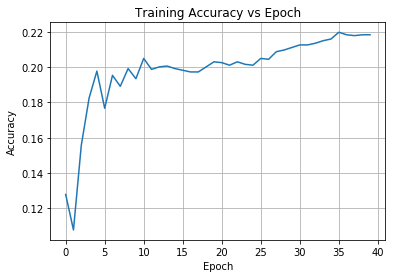

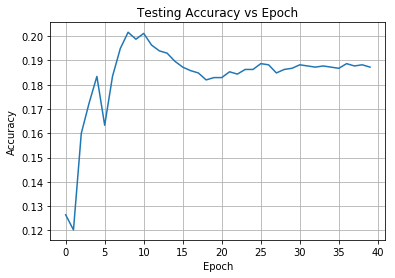

max test 0.20162836
max train @ max test 0.19923371


In [12]:
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("abalone.data", ",", 0.5, 0.0001, 40, 100, i, 1, j, ac_list, True, True)

In [14]:
out = np.argmax(np.array(ac_list)) +1
#print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
#print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Maximum Test Accuracy:  0.20162836


Hidden Units:  1
Momentum:  0
Epoch: 0001 cost=4.640566885
Epoch: 0002 cost=4.634176075
Epoch: 0003 cost=4.627874434
Epoch: 0004 cost=4.621659636
Epoch: 0005 cost=4.615530908
Epoch: 0006 cost=4.609486759
Epoch: 0007 cost=4.603525341
Epoch: 0008 cost=4.597645462
Epoch: 0009 cost=4.591845989
Epoch: 0010 cost=4.586125672
Epoch: 0011 cost=4.580482841
Epoch: 0012 cost=4.574916422
Epoch: 0013 cost=4.569425166
Epoch: 0014 cost=4.564007759
Epoch: 0015 cost=4.558663070
Epoch: 0016 cost=4.553389847
Epoch: 0017 cost=4.548187077
Epoch: 0018 cost=4.543053687
Epoch: 0019 cost=4.537988663
Epoch: 0020 cost=4.532991171
Epoch: 0021 cost=4.528059304
Epoch: 0022 cost=4.523192704
Epoch: 0023 cost=4.518390179
Epoch: 0024 cost=4.513650537
Epoch: 0025 cost=4.508973062
Epoch: 0026 cost=4.504356503
Epoch: 0027 cost=4.499800205
Epoch: 0028 cost=4.495303094
Epoch: 0029 cost=4.490864635
Epoch: 0030 cost=4.486483634
Epoch: 0031 cost=4.482158780
Epoch: 0032 cost=4.477889895
Epoch: 0033 cost=4.473675609
Epoch: 0034 c

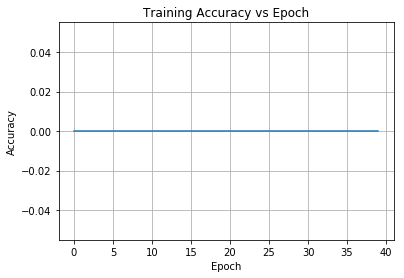

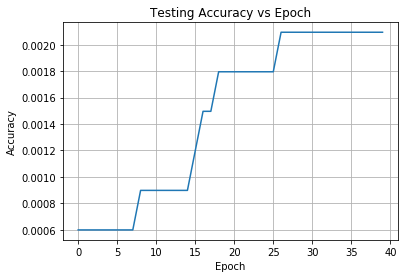

max test 0.002095181
max train @ max test 0.0
Hidden Units:  1
Momentum:  0.2
Epoch: 0001 cost=3.983377784
Epoch: 0002 cost=3.981756628
Epoch: 0003 cost=3.980141103
Epoch: 0004 cost=3.978538781
Epoch: 0005 cost=3.976949990
Epoch: 0006 cost=3.975374311
Epoch: 0007 cost=3.973811537
Epoch: 0008 cost=3.972261012
Epoch: 0009 cost=3.970723838
Epoch: 0010 cost=3.969198823
Epoch: 0011 cost=3.967685819
Epoch: 0012 cost=3.966184705
Epoch: 0013 cost=3.964695275
Epoch: 0014 cost=3.963217735
Epoch: 0015 cost=3.961751193
Epoch: 0016 cost=3.960296154
Epoch: 0017 cost=3.958851963
Epoch: 0018 cost=3.957419008
Epoch: 0019 cost=3.955996513
Epoch: 0020 cost=3.954584628
Epoch: 0021 cost=3.953183323
Epoch: 0022 cost=3.951792449
Epoch: 0023 cost=3.950411648
Epoch: 0024 cost=3.949040711
Epoch: 0025 cost=3.947679609
Epoch: 0026 cost=3.946328402
Epoch: 0027 cost=3.944986254
Epoch: 0028 cost=3.943653762
Epoch: 0029 cost=3.942330867
Epoch: 0030 cost=3.941017300
Epoch: 0031 cost=3.939713001
Epoch: 0032 cost=3.9384

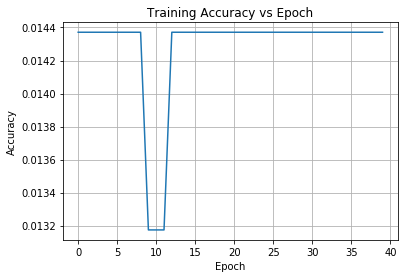

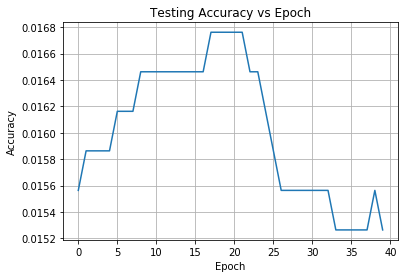

max test 0.016761448
max train @ max test 0.014371257
Hidden Units:  1
Momentum:  0.5
Epoch: 0001 cost=3.220490754
Epoch: 0002 cost=3.220194370
Epoch: 0003 cost=3.219888538
Epoch: 0004 cost=3.219583213
Epoch: 0005 cost=3.219278306
Epoch: 0006 cost=3.218973815
Epoch: 0007 cost=3.218669385
Epoch: 0008 cost=3.218365312
Epoch: 0009 cost=3.218061715
Epoch: 0010 cost=3.217758238
Epoch: 0011 cost=3.217454851
Epoch: 0012 cost=3.217152089
Epoch: 0013 cost=3.216849685
Epoch: 0014 cost=3.216547430
Epoch: 0015 cost=3.216245502
Epoch: 0016 cost=3.215943813
Epoch: 0017 cost=3.215642631
Epoch: 0018 cost=3.215341538
Epoch: 0019 cost=3.215040863
Epoch: 0020 cost=3.214740455
Epoch: 0021 cost=3.214440256
Epoch: 0022 cost=3.214140564
Epoch: 0023 cost=3.213841081
Epoch: 0024 cost=3.213541925
Epoch: 0025 cost=3.213242918
Epoch: 0026 cost=3.212944210
Epoch: 0027 cost=3.212645948
Epoch: 0028 cost=3.212347746
Epoch: 0029 cost=3.212049931
Epoch: 0030 cost=3.211752743
Epoch: 0031 cost=3.211455584
Epoch: 0032 cos

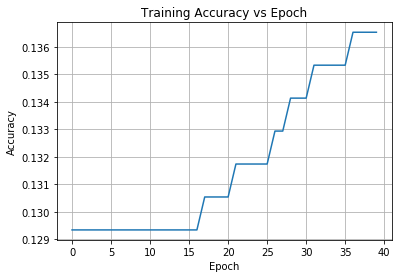

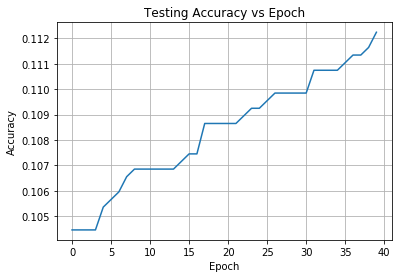

max test 0.11224184
max train @ max test 0.13652694
Hidden Units:  1
Momentum:  0.9
Epoch: 0001 cost=6.205653429
Epoch: 0002 cost=6.067552686
Epoch: 0003 cost=5.876278341
Epoch: 0004 cost=5.677501678
Epoch: 0005 cost=5.489828289
Epoch: 0006 cost=5.319666922
Epoch: 0007 cost=5.168249369
Epoch: 0008 cost=5.034743607
Epoch: 0009 cost=4.917593300
Epoch: 0010 cost=4.815074146
Epoch: 0011 cost=4.725514472
Epoch: 0012 cost=4.647371352
Epoch: 0013 cost=4.579252243
Epoch: 0014 cost=4.519912720
Epoch: 0015 cost=4.468248069
Epoch: 0016 cost=4.423280418
Epoch: 0017 cost=4.384146810
Epoch: 0018 cost=4.350086391
Epoch: 0019 cost=4.320431590
Epoch: 0020 cost=4.294598043
Epoch: 0021 cost=4.272074997
Epoch: 0022 cost=4.252416432
Epoch: 0023 cost=4.235235333
Epoch: 0024 cost=4.220194578
Epoch: 0025 cost=4.207002640
Epoch: 0026 cost=4.195406854
Epoch: 0027 cost=4.185188353
Epoch: 0028 cost=4.176158428
Epoch: 0029 cost=4.168153942
Epoch: 0030 cost=4.161034703
Epoch: 0031 cost=4.154679179
Epoch: 0032 cost=

In [ ]:
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("abalone.data", ",", 0.8, 0.0001, 40, 100, i, 1, j, ac_list, True, True)

In [ ]:
out = np.argmax(np.array(ac_list)) +1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

In [ ]:
# do the rest with the different hyperparameters, this si for winequality
hu_list = [1,2,4,8,32,128]
mom_list = [0,0.2,0.5,0.9]
ac_list = []
for i in hu_list:
    for j  in mom_list:
        print("Hidden Units: ", i)
        print("Momentum: ", j)
        nn("short_SUSY.csv", ",", 0.2, 0.01, 1, 1000, i, 1, j, ac_list, False, False)

Hidden Units:  1
Momentum:  0


In [10]:
out = np.argmax(np.array(ac_list)) + 1
print("Opt Hidden Units: ", hu_list[int(np.floor(out/len(mom_list)))])
print("Opt Momentum: ", mom_list[np.mod(out,len(mom_list))-1])
print("Maximum Test Accuracy: ", max(ac_list))

Opt Hidden Units:  1
Opt Momentum:  0.2
Maximum Test Accuracy:  0.5429
